In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools
from collections import defaultdict

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

from thesis.utils.metrics import *

Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
IS_SAMPLE = False

In [4]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234

In [5]:
NUMBER_INDICATOR = "number_inidicator"
CURRENCY_INDICATOR = "currency_inidicator"
CHEMICAL_INDICATOR = "chemical_inidicator"
MIN_WORD_COUNT = 100
MIN_SIZE = 0
NUM_CORES = 14

In [6]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [7]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"

In [8]:
NN_PARAMETER_SEARCH_PREFIX = "{}_batch_{}_nn_parameter_searches.pkl"

In [9]:
#training_file = "/home/local/shalaby/docs_output_sample_100.json"

root_location = "/mnt/data2/shalaby/"
exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(root_location, "parameter_search_doc2vec_models_new", "full")
nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search")
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

training_file = root_location + "docs_output.json"

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
classification_index_file = exports_location + "classification_index.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

preprocessed_location = root_location + "preprocessed_data/"

training_preprocessed_files_prefix = preprocessed_location + "training_docs_merged_data_preprocessed-"
training_preprocessed_docids_files_prefix = preprocessed_location + "training_docs_merged_docids_preprocessed-"
validation_preprocessed_files_prefix = preprocessed_location + "validation_docs_merged_data_preprocessed-"
validation_preprocessed_docids_files_prefix = preprocessed_location + "validation_docs_merged_docids_preprocessed-"

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

In [10]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
classifications_index = pickle.load(open(classification_index_file))
#test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 30.3 s, sys: 2.94 s, total: 33.3 s
Wall time: 33.3 s


In [11]:
len(training_docs_list)

1286325

In [12]:
len(validation_docs_list)

321473

In [13]:
def ensure_hdfs_location_exists(location):
    parent = os.path.dirname(location)
    os.system("hdfs dfs -mkdir -p " + location)

def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

In [14]:
def get_validation_docs_with_inference(doc2vec_model, doc_classification_map):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        info("===== Loading validation vectors")
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # do inference and store results in dict
        i = 0
        for (doc_id, doc_contents_array) in ValidationDocumentGenerator(training_file, validation_docs_list):
            i += 1
            if i % 1000 == 0: info("Finished: {}".format(str(i)))
            validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)

        # create matrix for the validation vectors
        for validation_doc_id in validation_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            validation_labels.append([classf for classf in doc_classification_map[validation_doc_id] if classf in sections])
        validation_vectors_matrix = np.array(validation_vectors)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix

In [15]:
def get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                           val_docs_list, val_preprocessed_files_prefix, val_preprocessed_docids_files_prefix):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """

    def infer_one_doc(doc_tuple):
        #doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
        doc_id, doc_tokens = doc_tuple
        rep = doc2vec_model.infer_vector(doc_tokens)
        return (doc_id, rep)

    one_hot_encoder = OneHotEncoder(classifications)
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        info("===== Loading validation vectors")
        validation_labels = []
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
        for validation_doc_id in val_docs_list:
            val_labels = [classf for classf in doc_classification_map[validation_doc_id] if classf in classifications]
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_labels = np.array(validation_labels)
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # Single-threaded inference
        # do inference and store results in dict
#         i = 0
        
#         validation_docs_iterator = DocumentBatchGenerator(val_preprocessed_files_prefix, 
#                                                         val_preprocessed_docids_files_prefix, batch_size=None)
#         for (doc_id, doc_contents_array) in validation_docs_iterator:
#             i += 1
#             if i % 1000 == 0: info("Finished: {}".format(str(i)))
#             validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)
        
        # Multi-threaded inference
        validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                          validation_preprocessed_docids_files_prefix, batch_size=None)
        generator_func = validation_docs_iterator.__iter__()
        pool = ThreadPool(NUM_CORES)
        # map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
        validation_documents_reps = {}
        mini_batch_size = 1000
        while True:
            threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(generator_func, mini_batch_size))
            info("Finished: {}".format(str(validation_docs_iterator.curr_index)))
            if threaded_reps_partial:
                #threaded_reps.extend(threaded_reps_partial)
                validation_documents_reps.update(threaded_reps_partial)
            else:
                break

                
        # create matrix for the validation vectors
        for validation_doc_id in val_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            val_labels = [classf for classf in doc_classification_map[validation_doc_id] if classf in classifications]
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_vectors_matrix = np.array(validation_vectors)
        validation_labels = np.array(validation_labels)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix, validation_labels

In [16]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector

def get_training_data(doc2vec_model, classifications):
    one_hot_encoder = OneHotEncoder(classifications)
    training_data = []
    training_labels = []
    for doc_id in training_docs_list:
        # converting from memmap to a normal array
        normal_array = []
        normal_array[:] = doc2vec_model.docvecs[doc_id][:]
        training_data.append(normal_array)
        eligible_classifications = [clssf for clssf in doc_classification_map[doc_id] if clssf in classifications]
        training_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))
    training_labels = np.array(training_labels)
    training_data = np.array(training_data)
    return training_data, training_labels

In [17]:
class TrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
                    
class DocumentBatchGenerator(object):
    def __init__(self, filename_prefix, filename_docids_prefix, batch_size=10000 ):
        """
        batch_size cant be > 10,000 due to a limitation in doc2vec training, 
        None means no batching (only use for inference)
        """
        assert batch_size <= 10000 or batch_size is None
        self.filename_prefix = filename_prefix
        self.filename_docids_prefix = filename_docids_prefix
        self.curr_lines = []
        self.curr_docids = []
        self.batch_size = batch_size
        self.curr_index = 0
        self.batch_end = -1
    def load_new_batch_in_memory(self):
        del self.curr_lines, self.curr_docids
        self.curr_lines, self.docids = [], []
        info("Loading new batch for index: {}".format(self.curr_index) )
        try:
            with open(self.filename_prefix + str(self.curr_index)) as preproc_file:
                for line in preproc_file:
                    self.curr_lines.append(line.split(" "))
#                     if i % 1000 == 0:
#                         print i
            self.curr_docids = pickle.load(open(self.filename_docids_prefix + str(self.curr_index), "r"))
            self.batch_end = self.curr_index + len(self.curr_lines) -1 
            info("Finished loading new batch")
        except IOError:
            info("No more batches to load, exiting at index: {}".format(self.curr_index))
            raise StopIteration()
    def __iter__(self):
        while True:
            if self.curr_index > self.batch_end:
                self.load_new_batch_in_memory()
            for (doc_id, tokens) in zip(self.curr_docids, self.curr_lines):
                if self.batch_size is not None:
                    curr_batch_iter = 0
                    # divide the document to batches according to the batch size
                    while curr_batch_iter < len(tokens):
                        yield LabeledSentence(words=tokens[curr_batch_iter: curr_batch_iter + self.batch_size], tags=[doc_id])
                        curr_batch_iter += self.batch_size
                else:
                    yield doc_id, tokens
                self.curr_index += 1

class Word2VecTrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield stemtokenizer(text)
                
class ValidationDocumentGenerator(object):
    def __init__(self, filename, validation_docs_list):
        self.filename = filename
        self.validation_docs_list = validation_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.validation_docs_list:
                    yield doc_id, stemtokenizer(text)
                    
class StochasticDocumentGenerator(object):
    """
    Randomly shuffle rows while reading them
    """
    def __init__(self, filename, training_docs_list, line_positions):
        self.filename = filename
        self.training_docs_list = training_docs_list
        self.line_positions = line_positions
        self.lines = set(line_positions.keys())
    def __iter__(self):
        with open(self.filename) as file_obj:
            while len(self.lines) > 0:
                random_line = random.sample(self.lines,1)[0]
                self.lines.remove(random_line)
                file_obj.seek(self.line_positions[random_line])
                line = file_obj.readline()
                if not line.strip(): continue
#                 print random_line, self.line_positions[random_line], line[:30]
                (doc_id, text) = eval(line)
                # print random_line , doc_id
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
#                     yield doc_id

## Loading Specific Doc2vec Model

### Doc2vec and SVM Parameters

In [33]:
DOC2VEC_SIZE = 1000
DOC2VEC_WINDOW = 8
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 0
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 1
DOC2VEC_MEAN = 0
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 20
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 10000 # report vocab progress every x documents

In [34]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")
placeholder_model_name

'doc2vec_size_1000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_{}'

In [20]:
best_epochs = {
    'doc2vec_size_50_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None': 8,
    'doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None': 14,
    'doc2vec_size_200_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None': 6
}

In [49]:
# vocab_counts = {k:doc2vec_model.vocab[k].count for k in doc2vec_model.vocab.keys()}
# dd = sorted(vocab_counts, key=vocab_counts.get)

In [50]:
classifications = sections
classifications_type = 'sections'

In [56]:
epoch = 6
GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
info("****************** Epoch {} --- Loading {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))

# if we have the model, just load it, otherwise train the previous model
if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
    doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
    GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

info('Getting training Data')
X, y = get_training_data(doc2vec_model, classifications)

info('Getting Validation Embeddings')
Xv, yv = get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                                validation_docs_list, validation_preprocessed_files_prefix,
                                                validation_preprocessed_docids_files_prefix)

2017-01-31 21:58:29,865 : INFO : ****************** Epoch 6 --- Loading doc2vec_size_200_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6 *******************
2017-01-31 21:58:29,868 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_200_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model
2017-01-31 21:58:35,926 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_200_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.docvecs.* with mmap=None
2017-01-31 21:58:35,928 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_200_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-31 21:58:37,843 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search

In [57]:
# create nn parameter search directory
if not os.path.exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME)):
    os.makedirs(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

## NN Specific Functions

In [25]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from sklearn.model_selection import ParameterSampler
import keras

Using Theano backend.


In [26]:
def create_keras_nn_model(input_size, output_size, 
                          first_hidden_layer_size, first_hidden_layer_activation, 
                          second_hidden_layer_size, second_hidden_layer_activation, 
                          input_dropout_do, hidden_dropout_do):
    
    doc_input = Input(shape=(DOC2VEC_SIZE,), name='doc_input')
    if input_dropout_do:
        hidden = Dropout(0.7)(doc_input)
    hidden = Dense(first_hidden_layer_size, activation=first_hidden_layer_activation, 
                   name='hidden_layer_{}'.format(first_hidden_layer_activation))(doc_input if not input_dropout_do else hidden)
    if hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    if second_hidden_layer_size is not None:
        hidden = Dense(second_hidden_layer_size, activation=second_hidden_layer_activation, 
                       name='hidden_layer2_{}'.format(second_hidden_layer_activation))(hidden)
    softmax_output = Dense(output_size, activation='sigmoid', name='softmax_output')(hidden)

    model = Model(input=doc_input, output=softmax_output)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    
    return model

In [27]:
VALIDATION_METRICS_FILENAME= '{}_validation_metrics.pkl'.format(classifications_type)
TRAINING_METRICS_FILENAME = '{}_training_metrics.pkl'.format(classifications_type)
METRICS_FIG_PNG_FILENAME = '{}_validation_metrics.png'.format(classifications_type)
METRICS_FIG_PDF_FILENAME = '{}_validation_metrics.pdf'.format(classifications_type)
WORD2VEC_METRICS_FILENAME = 'word2vec_metrics.pkl'

# for epoch in range(DOC2VEC_MAX_EPOCHS):
#     GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
#     ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                              GLOBAL_VARS.SVM_MODEL_NAME))
#     pickle.dump(metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, GLOBAL_VARS.SVM_MODEL_NAME, METRICS), 'w'))
# fig_save_location = placeholder_model_name.format('run')
# plt.savefig(os.path.join(fig_save_location))

In [28]:
get_binary_0_5 = lambda x: 1 if x > 0.5 else 0
get_binary_0_5 = np.vectorize(get_binary_0_5)

In [29]:
NN_OUTPUT_NEURONS = len(classifications)
NN_MAX_EPOCHS = 100
NN_BATCH_SIZE = 1024
NN_RANDOM_SEARCH_BUDGET = 20
NN_PARAM_SAMPLE_SEED = 1234

first_hidden_layer_sizes = [200,500]
second_hidden_layer_sizes = [None,50,200,500,1000]
first_hidden_layer_activations = ['relu','sigmoid', 'tanh', 'softmax']
second_hidden_layer_activations = ['relu','sigmoid', 'tanh', 'softmax']
# first_hidden_layer_activations = ['relu']
# second_hidden_layer_activations = ['relu']
input_dropout_options = [False, True]
hidden_dropout_options = [False, True]

## Evaluate Batch Sizes

In [65]:
batch_dict = {}
for batch_sz in [64,128,256,512,1024,2048]:
# for batch_sz in [2048]:
    NN_BATCH_SIZE = batch_sz
    batch_dict[batch_sz] = {}
    start_time = time.time()
    param_sampler = ParameterSampler({
            'first_hidden_layer_size':first_hidden_layer_sizes,
            'first_hidden_layer_activation':first_hidden_layer_activations,
            'second_hidden_layer_size':second_hidden_layer_sizes,
            'second_hidden_layer_activation':second_hidden_layer_activations,
            'input_dropout':input_dropout_options,
            'hidden_dropout':hidden_dropout_options
        }, n_iter=NN_RANDOM_SEARCH_BUDGET, random_state=NN_PARAM_SAMPLE_SEED)
    for parameters in param_sampler:
        first_hidden_layer_size = parameters['first_hidden_layer_size']
        first_hidden_layer_activation = parameters['first_hidden_layer_activation']
        second_hidden_layer_size = parameters['second_hidden_layer_size']
        second_hidden_layer_activation = parameters['second_hidden_layer_activation']
        input_dropout_do = parameters['input_dropout']
        hidden_dropout_do = parameters['hidden_dropout']

        print ("===================================================================================\n" + \
              "========== 1st Layer Size: {}, 1st Layer Activation: {}, \n 2nd Layer Size: {}, 2nd Layer Activation: {}, \n" + \
              "Input Dropout: {}, Hidden Dropout: {} \n" + \
              "==========================").format(first_hidden_layer_size, first_hidden_layer_activation, 
                                                    second_hidden_layer_size, second_hidden_layer_activation, 
                                                    input_dropout_do, hidden_dropout_do)

        GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-act_{}_2nd-size_{}_2nd-act_{}_in-drop_{}_hid-drop_{}'.format(
            first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
            second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
        )

        model = create_keras_nn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                                      first_hidden_layer_size, first_hidden_layer_activation, 
                                      second_hidden_layer_size, second_hidden_layer_activation, 
                                      input_dropout_do, hidden_dropout_do)
        model.summary()
        
        batch_dict[batch_sz]['metrics'] = []
        batch_dict[batch_sz]['history'] = []

        for nn_epoch in range(1, NN_MAX_EPOCHS+1):
            info('======= NN Epoch: {} =========='.format(nn_epoch)) 
            %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, nb_epoch=1, verbose=1, callbacks=[early_stopper])
    #         info('Evaluating on Training Data')
    #         yp = model.predict(X, batch_size=NN_BATCH_SIZE)
    #         yp_binary = get_binary_0_5(yp)
    #         #print yp
    #         info('Generating Training Metrics')
    #         training_metrics = get_metrics(y, yp, yp_binary)
    #         print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    #             training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
    #             training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
    #             training_metrics['f1_micro'],training_metrics['f1_macro'],  training_metrics['total_positive'])

            info('Evaluating on Validation Data')
            yvp = model.predict(Xv)
            yvp_binary = get_binary_0_5(yvp)
            #print yvp
            info('Generating Validation Metrics')
            validation_metrics = get_metrics(yv, yvp, yvp_binary)
            print "****** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
                validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
                validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
                validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive'])
            
            batch_dict[batch_sz]['metrics'].append(validation_metrics)
            batch_dict[batch_sz]['history'].append(history)
            
        break
    duration = time.time() - start_time
    batch_dict[batch_sz]['duration'] =  duration


========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: True 
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_29 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       dropout_29[0][0]                 
____________________________________________________________________________________________________
dropout_30 (Dropout)             (Non

2017-01-22 23:18:08,422 : INFO : ======= NN Epoch: 1 ==========


Total params: 124708
____________________________________________________________________________________________________
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 749s - loss: 0.2799 - val_loss: 0.2113

2017-01-22 23:30:46,709 : INFO : Evaluating on Validation Data



CPU times: user 1min 22s, sys: 52.7 s, total: 2min 15s
Wall time: 12min 37s


2017-01-22 23:30:56,551 : INFO : Generating Validation Metrics
2017-01-22 23:31:14,674 : INFO : ======= NN Epoch: 2 ==========


****** Validation Metrics: Cov Err: 1.709, Avg Labels: 1.150, 
		 Top 1: 0.705, Top 3: 0.932, Top 5: 0.986, 
		 F1 Micro: 0.633, F1 Macro: 0.416, Total Pos: 266,589
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 109s - loss: 0.2730 - val_loss: 0.2065

2017-01-22 23:33:03,732 : INFO : Evaluating on Validation Data



CPU times: user 1min 5s, sys: 38.6 s, total: 1min 44s
Wall time: 1min 49s


2017-01-22 23:33:10,364 : INFO : Generating Validation Metrics
2017-01-22 23:33:26,903 : INFO : ======= NN Epoch: 3 ==========


****** Validation Metrics: Cov Err: 1.664, Avg Labels: 1.150, 
		 Top 1: 0.721, Top 3: 0.943, Top 5: 0.987, 
		 F1 Micro: 0.627, F1 Macro: 0.455, Total Pos: 245,299
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 109s - loss: 0.2724 - val_loss: 0.2082

2017-01-22 23:35:16,033 : INFO : Evaluating on Validation Data



CPU times: user 1min 4s, sys: 38.4 s, total: 1min 42s
Wall time: 1min 49s


2017-01-22 23:35:23,493 : INFO : Generating Validation Metrics
2017-01-22 23:35:39,934 : INFO : ======= NN Epoch: 4 ==========


****** Validation Metrics: Cov Err: 1.684, Avg Labels: 1.150, 
		 Top 1: 0.707, Top 3: 0.938, Top 5: 0.988, 
		 F1 Micro: 0.634, F1 Macro: 0.436, Total Pos: 269,296
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 93s - loss: 0.2721 - val_loss: 0.2077

2017-01-22 23:37:13,820 : INFO : Evaluating on Validation Data



CPU times: user 58.6 s, sys: 34.1 s, total: 1min 32s
Wall time: 1min 33s


2017-01-22 23:37:19,295 : INFO : Generating Validation Metrics
2017-01-22 23:37:28,746 : INFO : ======= NN Epoch: 5 ==========


****** Validation Metrics: Cov Err: 1.688, Avg Labels: 1.150, 
		 Top 1: 0.710, Top 3: 0.936, Top 5: 0.987, 
		 F1 Micro: 0.631, F1 Macro: 0.433, Total Pos: 261,761
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 61s - loss: 0.2719 - val_loss: 0.2030

2017-01-22 23:38:29,795 : INFO : Evaluating on Validation Data



CPU times: user 44.5 s, sys: 28 s, total: 1min 12s
Wall time: 1min 1s


2017-01-22 23:38:34,949 : INFO : Generating Validation Metrics
2017-01-22 23:38:45,755 : INFO : ======= NN Epoch: 6 ==========


****** Validation Metrics: Cov Err: 1.675, Avg Labels: 1.150, 
		 Top 1: 0.722, Top 3: 0.936, Top 5: 0.986, 
		 F1 Micro: 0.647, F1 Macro: 0.446, Total Pos: 260,299
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 64s - loss: 0.2720 - val_loss: 0.2034

2017-01-22 23:39:50,345 : INFO : Evaluating on Validation Data



CPU times: user 47 s, sys: 29.7 s, total: 1min 16s
Wall time: 1min 4s


2017-01-22 23:39:55,424 : INFO : Generating Validation Metrics
2017-01-22 23:40:06,470 : INFO : ======= NN Epoch: 7 ==========


****** Validation Metrics: Cov Err: 1.676, Avg Labels: 1.150, 
		 Top 1: 0.726, Top 3: 0.935, Top 5: 0.986, 
		 F1 Micro: 0.648, F1 Macro: 0.434, Total Pos: 255,847
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 61s - loss: 0.2721 - val_loss: 0.2062

2017-01-22 23:41:07,572 : INFO : Evaluating on Validation Data



CPU times: user 44.4 s, sys: 28.2 s, total: 1min 12s
Wall time: 1min 1s


2017-01-22 23:41:12,301 : INFO : Generating Validation Metrics
2017-01-22 23:41:20,732 : INFO : ======= NN Epoch: 8 ==========


****** Validation Metrics: Cov Err: 1.708, Avg Labels: 1.150, 
		 Top 1: 0.712, Top 3: 0.930, Top 5: 0.985, 
		 F1 Micro: 0.641, F1 Macro: 0.439, Total Pos: 259,504
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 63s - loss: 0.2721 - val_loss: 0.2062

2017-01-22 23:42:24,126 : INFO : Evaluating on Validation Data



CPU times: user 44.9 s, sys: 31.9 s, total: 1min 16s
Wall time: 1min 3s


2017-01-22 23:42:29,017 : INFO : Generating Validation Metrics
2017-01-22 23:42:37,494 : INFO : ======= NN Epoch: 9 ==========


****** Validation Metrics: Cov Err: 1.676, Avg Labels: 1.150, 
		 Top 1: 0.728, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.650, F1 Macro: 0.460, Total Pos: 259,484
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 63s - loss: 0.2720 - val_loss: 0.2038

2017-01-22 23:43:40,568 : INFO : Evaluating on Validation Data



CPU times: user 45.9 s, sys: 30.4 s, total: 1min 16s
Wall time: 1min 3s


2017-01-22 23:43:45,346 : INFO : Generating Validation Metrics
2017-01-22 23:43:56,554 : INFO : ======= NN Epoch: 10 ==========


****** Validation Metrics: Cov Err: 1.660, Avg Labels: 1.150, 
		 Top 1: 0.724, Top 3: 0.941, Top 5: 0.987, 
		 F1 Micro: 0.642, F1 Macro: 0.459, Total Pos: 261,635
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 62s - loss: 0.2722 - val_loss: 0.2044

2017-01-22 23:44:58,610 : INFO : Evaluating on Validation Data



CPU times: user 44.8 s, sys: 30.2 s, total: 1min 14s
Wall time: 1min 2s


2017-01-22 23:45:03,627 : INFO : Generating Validation Metrics
2017-01-22 23:45:13,198 : INFO : ======= NN Epoch: 11 ==========


****** Validation Metrics: Cov Err: 1.665, Avg Labels: 1.150, 
		 Top 1: 0.725, Top 3: 0.940, Top 5: 0.987, 
		 F1 Micro: 0.658, F1 Macro: 0.435, Total Pos: 277,230
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 124s - loss: 0.2722 - val_loss: 0.2054

2017-01-22 23:47:17,397 : INFO : Evaluating on Validation Data



CPU times: user 1min 26s, sys: 47.6 s, total: 2min 13s
Wall time: 2min 4s


2017-01-22 23:47:28,524 : INFO : Generating Validation Metrics
2017-01-22 23:47:43,417 : INFO : ======= NN Epoch: 12 ==========


****** Validation Metrics: Cov Err: 1.669, Avg Labels: 1.150, 
		 Top 1: 0.727, Top 3: 0.939, Top 5: 0.986, 
		 F1 Micro: 0.650, F1 Macro: 0.482, Total Pos: 266,918
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 212s - loss: 0.2721 - val_loss: 0.2075

2017-01-22 23:51:16,274 : INFO : Evaluating on Validation Data



CPU times: user 2min 32s, sys: 1min 18s, total: 3min 51s
Wall time: 3min 32s


2017-01-22 23:51:32,942 : INFO : Generating Validation Metrics
2017-01-22 23:51:55,045 : INFO : ======= NN Epoch: 13 ==========


****** Validation Metrics: Cov Err: 1.691, Avg Labels: 1.150, 
		 Top 1: 0.719, Top 3: 0.934, Top 5: 0.984, 
		 F1 Micro: 0.632, F1 Macro: 0.423, Total Pos: 255,122
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 263s - loss: 0.2722 - val_loss: 0.2097

2017-01-22 23:56:18,726 : INFO : Evaluating on Validation Data



CPU times: user 3min 5s, sys: 1min 53s, total: 4min 59s
Wall time: 4min 23s


2017-01-22 23:56:36,108 : INFO : Generating Validation Metrics
2017-01-22 23:56:59,743 : INFO : ======= NN Epoch: 14 ==========


****** Validation Metrics: Cov Err: 1.711, Avg Labels: 1.150, 
		 Top 1: 0.720, Top 3: 0.927, Top 5: 0.981, 
		 F1 Micro: 0.605, F1 Macro: 0.421, Total Pos: 219,893
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 226s - loss: 0.2724 - val_loss: 0.2049

2017-01-23 00:00:46,496 : INFO : Evaluating on Validation Data



CPU times: user 2min 39s, sys: 1min 35s, total: 4min 14s
Wall time: 3min 46s


2017-01-23 00:01:03,139 : INFO : Generating Validation Metrics
2017-01-23 00:01:26,373 : INFO : ======= NN Epoch: 15 ==========


****** Validation Metrics: Cov Err: 1.676, Avg Labels: 1.150, 
		 Top 1: 0.719, Top 3: 0.938, Top 5: 0.986, 
		 F1 Micro: 0.637, F1 Macro: 0.451, Total Pos: 253,115
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 267s - loss: 0.2724 - val_loss: 0.2065

2017-01-23 00:05:54,353 : INFO : Evaluating on Validation Data



CPU times: user 3min 6s, sys: 1min 51s, total: 4min 57s
Wall time: 4min 27s


2017-01-23 00:06:03,468 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.700, Avg Labels: 1.150, 
		 Top 1: 0.721, Top 3: 0.932, Top 5: 0.982, 
		 F1 Micro: 0.663, F1 Macro: 0.458, Total Pos: 286,271
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: True 
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_31 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       dropout

2017-01-23 00:06:28,943 : INFO : ======= NN Epoch: 1 ==========


Total params: 124708
____________________________________________________________________________________________________
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 165s - loss: 0.2801 - val_loss: 0.2087

2017-01-23 00:09:21,241 : INFO : Evaluating on Validation Data



CPU times: user 1min 56s, sys: 1min 14s, total: 3min 10s
Wall time: 2min 52s


2017-01-23 00:09:40,226 : INFO : Generating Validation Metrics
2017-01-23 00:10:05,799 : INFO : ======= NN Epoch: 2 ==========


****** Validation Metrics: Cov Err: 1.686, Avg Labels: 1.150, 
		 Top 1: 0.721, Top 3: 0.935, Top 5: 0.984, 
		 F1 Micro: 0.630, F1 Macro: 0.424, Total Pos: 249,069
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 160s - loss: 0.2710 - val_loss: 0.2030

2017-01-23 00:12:45,850 : INFO : Evaluating on Validation Data



CPU times: user 1min 41s, sys: 1min, total: 2min 42s
Wall time: 2min 40s


2017-01-23 00:13:03,894 : INFO : Generating Validation Metrics
2017-01-23 00:13:23,840 : INFO : ======= NN Epoch: 3 ==========


****** Validation Metrics: Cov Err: 1.647, Avg Labels: 1.150, 
		 Top 1: 0.729, Top 3: 0.943, Top 5: 0.988, 
		 F1 Micro: 0.645, F1 Macro: 0.444, Total Pos: 259,649
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 135s - loss: 0.2697 - val_loss: 0.2030

2017-01-23 00:15:39,372 : INFO : Evaluating on Validation Data



CPU times: user 1min 29s, sys: 53.3 s, total: 2min 22s
Wall time: 2min 15s


2017-01-23 00:15:54,793 : INFO : Generating Validation Metrics
2017-01-23 00:16:10,639 : INFO : ======= NN Epoch: 4 ==========


****** Validation Metrics: Cov Err: 1.665, Avg Labels: 1.150, 
		 Top 1: 0.725, Top 3: 0.939, Top 5: 0.986, 
		 F1 Micro: 0.643, F1 Macro: 0.448, Total Pos: 257,832
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 165s - loss: 0.2692 - val_loss: 0.2024

2017-01-23 00:18:55,909 : INFO : Evaluating on Validation Data



CPU times: user 1min 48s, sys: 1min 3s, total: 2min 51s
Wall time: 2min 45s


2017-01-23 00:19:03,646 : INFO : Generating Validation Metrics
2017-01-23 00:19:29,019 : INFO : ======= NN Epoch: 5 ==========


****** Validation Metrics: Cov Err: 1.668, Avg Labels: 1.150, 
		 Top 1: 0.720, Top 3: 0.938, Top 5: 0.987, 
		 F1 Micro: 0.641, F1 Macro: 0.450, Total Pos: 264,452
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 155s - loss: 0.2691 - val_loss: 0.2019

2017-01-23 00:22:04,072 : INFO : Evaluating on Validation Data



CPU times: user 1min 42s, sys: 1min, total: 2min 42s
Wall time: 2min 35s


2017-01-23 00:22:21,785 : INFO : Generating Validation Metrics
2017-01-23 00:22:45,764 : INFO : ======= NN Epoch: 6 ==========


****** Validation Metrics: Cov Err: 1.668, Avg Labels: 1.150, 
		 Top 1: 0.726, Top 3: 0.938, Top 5: 0.985, 
		 F1 Micro: 0.660, F1 Macro: 0.445, Total Pos: 275,878
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 157s - loss: 0.2686 - val_loss: 0.2033

2017-01-23 00:25:23,683 : INFO : Evaluating on Validation Data



CPU times: user 1min 44s, sys: 1min 1s, total: 2min 45s
Wall time: 2min 37s


2017-01-23 00:25:41,829 : INFO : Generating Validation Metrics
2017-01-23 00:25:59,425 : INFO : ======= NN Epoch: 7 ==========


****** Validation Metrics: Cov Err: 1.649, Avg Labels: 1.150, 
		 Top 1: 0.733, Top 3: 0.940, Top 5: 0.987, 
		 F1 Micro: 0.648, F1 Macro: 0.505, Total Pos: 258,654
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 154s - loss: 0.2684 - val_loss: 0.2029

2017-01-23 00:28:33,752 : INFO : Evaluating on Validation Data



CPU times: user 1min 40s, sys: 1min 2s, total: 2min 42s
Wall time: 2min 34s


2017-01-23 00:28:38,341 : INFO : Generating Validation Metrics
2017-01-23 00:28:50,079 : INFO : ======= NN Epoch: 8 ==========


****** Validation Metrics: Cov Err: 1.691, Avg Labels: 1.150, 
		 Top 1: 0.709, Top 3: 0.936, Top 5: 0.986, 
		 F1 Micro: 0.645, F1 Macro: 0.416, Total Pos: 274,392
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 160s - loss: 0.2684 - val_loss: 0.2083

2017-01-23 00:31:30,955 : INFO : Evaluating on Validation Data



CPU times: user 1min 41s, sys: 1min, total: 2min 41s
Wall time: 2min 40s


2017-01-23 00:31:40,319 : INFO : Generating Validation Metrics
2017-01-23 00:32:02,290 : INFO : ======= NN Epoch: 9 ==========


****** Validation Metrics: Cov Err: 1.745, Avg Labels: 1.150, 
		 Top 1: 0.695, Top 3: 0.924, Top 5: 0.984, 
		 F1 Micro: 0.645, F1 Macro: 0.410, Total Pos: 288,486
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 158s - loss: 0.2684 - val_loss: 0.2008

2017-01-23 00:34:41,296 : INFO : Evaluating on Validation Data



CPU times: user 1min 44s, sys: 1min 3s, total: 2min 48s
Wall time: 2min 38s


2017-01-23 00:34:59,535 : INFO : Generating Validation Metrics
2017-01-23 00:35:24,281 : INFO : ======= NN Epoch: 10 ==========


****** Validation Metrics: Cov Err: 1.656, Avg Labels: 1.150, 
		 Top 1: 0.722, Top 3: 0.942, Top 5: 0.988, 
		 F1 Micro: 0.635, F1 Macro: 0.441, Total Pos: 246,453
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 163s - loss: 0.2682 - val_loss: 0.2007

2017-01-23 00:38:08,185 : INFO : Evaluating on Validation Data



CPU times: user 1min 47s, sys: 1min 2s, total: 2min 49s
Wall time: 2min 43s


2017-01-23 00:38:25,722 : INFO : Generating Validation Metrics
2017-01-23 00:38:47,390 : INFO : ======= NN Epoch: 11 ==========


****** Validation Metrics: Cov Err: 1.628, Avg Labels: 1.150, 
		 Top 1: 0.742, Top 3: 0.944, Top 5: 0.987, 
		 F1 Micro: 0.651, F1 Macro: 0.507, Total Pos: 252,998
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 162s - loss: 0.2681 - val_loss: 0.1976

2017-01-23 00:41:30,379 : INFO : Evaluating on Validation Data



CPU times: user 1min 46s, sys: 1min 2s, total: 2min 49s
Wall time: 2min 42s


2017-01-23 00:41:40,981 : INFO : Generating Validation Metrics
2017-01-23 00:42:02,913 : INFO : ======= NN Epoch: 12 ==========


****** Validation Metrics: Cov Err: 1.646, Avg Labels: 1.150, 
		 Top 1: 0.733, Top 3: 0.941, Top 5: 0.988, 
		 F1 Micro: 0.666, F1 Macro: 0.499, Total Pos: 277,265
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 139s - loss: 0.2681 - val_loss: 0.1998

2017-01-23 00:44:22,267 : INFO : Evaluating on Validation Data



CPU times: user 1min 31s, sys: 55 s, total: 2min 26s
Wall time: 2min 19s


2017-01-23 00:44:36,492 : INFO : Generating Validation Metrics
2017-01-23 00:44:56,939 : INFO : ======= NN Epoch: 13 ==========


****** Validation Metrics: Cov Err: 1.656, Avg Labels: 1.150, 
		 Top 1: 0.727, Top 3: 0.941, Top 5: 0.988, 
		 F1 Micro: 0.634, F1 Macro: 0.442, Total Pos: 240,993
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 153s - loss: 0.2680 - val_loss: 0.1981

2017-01-23 00:47:30,293 : INFO : Evaluating on Validation Data



CPU times: user 1min 41s, sys: 1min, total: 2min 42s
Wall time: 2min 33s


2017-01-23 00:47:48,031 : INFO : Generating Validation Metrics
2017-01-23 00:48:12,449 : INFO : ======= NN Epoch: 14 ==========


****** Validation Metrics: Cov Err: 1.643, Avg Labels: 1.150, 
		 Top 1: 0.735, Top 3: 0.941, Top 5: 0.988, 
		 F1 Micro: 0.667, F1 Macro: 0.494, Total Pos: 274,374
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 152s - loss: 0.2684 - val_loss: 0.1994

2017-01-23 00:50:45,372 : INFO : Evaluating on Validation Data



CPU times: user 1min 36s, sys: 58.5 s, total: 2min 35s
Wall time: 2min 32s


2017-01-23 00:51:03,675 : INFO : Generating Validation Metrics
2017-01-23 00:51:28,183 : INFO : ======= NN Epoch: 15 ==========


****** Validation Metrics: Cov Err: 1.650, Avg Labels: 1.150, 
		 Top 1: 0.734, Top 3: 0.942, Top 5: 0.985, 
		 F1 Micro: 0.672, F1 Macro: 0.465, Total Pos: 286,275
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 150s - loss: 0.2679 - val_loss: 0.2027

2017-01-23 00:53:59,101 : INFO : Evaluating on Validation Data



CPU times: user 1min 40s, sys: 59.4 s, total: 2min 39s
Wall time: 2min 30s


2017-01-23 00:54:16,237 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.660, Avg Labels: 1.150, 
		 Top 1: 0.728, Top 3: 0.939, Top 5: 0.987, 
		 F1 Micro: 0.677, F1 Macro: 0.506, Total Pos: 304,618
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: True 
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_33 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       dropout

2017-01-23 00:54:39,255 : INFO : ======= NN Epoch: 1 ==========


Total params: 124708
____________________________________________________________________________________________________
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 94s - loss: 0.2822 - val_loss: 0.2092

2017-01-23 01:07:49,442 : INFO : Evaluating on Validation Data



CPU times: user 1min 17s, sys: 54.8 s, total: 2min 12s
Wall time: 13min 10s


2017-01-23 01:08:10,668 : INFO : Generating Validation Metrics
2017-01-23 01:08:35,401 : INFO : ======= NN Epoch: 2 ==========


****** Validation Metrics: Cov Err: 1.677, Avg Labels: 1.150, 
		 Top 1: 0.718, Top 3: 0.938, Top 5: 0.987, 
		 F1 Micro: 0.630, F1 Macro: 0.413, Total Pos: 251,200
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 90s - loss: 0.2702 - val_loss: 0.2063

2017-01-23 01:10:05,911 : INFO : Evaluating on Validation Data



CPU times: user 55.7 s, sys: 38.1 s, total: 1min 33s
Wall time: 1min 30s


2017-01-23 01:10:25,051 : INFO : Generating Validation Metrics
2017-01-23 01:10:49,649 : INFO : ======= NN Epoch: 3 ==========


****** Validation Metrics: Cov Err: 1.685, Avg Labels: 1.150, 
		 Top 1: 0.723, Top 3: 0.936, Top 5: 0.984, 
		 F1 Micro: 0.640, F1 Macro: 0.404, Total Pos: 258,544
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 60s - loss: 0.2681 - val_loss: 0.2027

2017-01-23 01:11:50,271 : INFO : Evaluating on Validation Data



CPU times: user 38.6 s, sys: 27.4 s, total: 1min 6s
Wall time: 1min


2017-01-23 01:12:07,764 : INFO : Generating Validation Metrics
2017-01-23 01:12:31,861 : INFO : ======= NN Epoch: 4 ==========


****** Validation Metrics: Cov Err: 1.658, Avg Labels: 1.150, 
		 Top 1: 0.730, Top 3: 0.940, Top 5: 0.985, 
		 F1 Micro: 0.662, F1 Macro: 0.461, Total Pos: 279,292
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 91s - loss: 0.2674 - val_loss: 0.1999

2017-01-23 01:14:03,790 : INFO : Evaluating on Validation Data



CPU times: user 57.3 s, sys: 39.8 s, total: 1min 37s
Wall time: 1min 31s


2017-01-23 01:14:10,741 : INFO : Generating Validation Metrics
2017-01-23 01:14:34,977 : INFO : ======= NN Epoch: 5 ==========


****** Validation Metrics: Cov Err: 1.629, Avg Labels: 1.150, 
		 Top 1: 0.735, Top 3: 0.947, Top 5: 0.988, 
		 F1 Micro: 0.651, F1 Macro: 0.479, Total Pos: 262,190
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 90s - loss: 0.2668 - val_loss: 0.2006

2017-01-23 01:16:05,388 : INFO : Evaluating on Validation Data



CPU times: user 55 s, sys: 38.1 s, total: 1min 33s
Wall time: 1min 30s


2017-01-23 01:16:22,853 : INFO : Generating Validation Metrics
2017-01-23 01:16:40,009 : INFO : ======= NN Epoch: 6 ==========


****** Validation Metrics: Cov Err: 1.626, Avg Labels: 1.150, 
		 Top 1: 0.739, Top 3: 0.947, Top 5: 0.989, 
		 F1 Micro: 0.651, F1 Macro: 0.468, Total Pos: 257,948
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 93s - loss: 0.2665 - val_loss: 0.2032

2017-01-23 01:18:13,399 : INFO : Evaluating on Validation Data



CPU times: user 58.3 s, sys: 38.5 s, total: 1min 36s
Wall time: 1min 33s


2017-01-23 01:18:30,724 : INFO : Generating Validation Metrics
2017-01-23 01:18:54,928 : INFO : ======= NN Epoch: 7 ==========


****** Validation Metrics: Cov Err: 1.685, Avg Labels: 1.150, 
		 Top 1: 0.714, Top 3: 0.935, Top 5: 0.986, 
		 F1 Micro: 0.651, F1 Macro: 0.405, Total Pos: 277,088
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 90s - loss: 0.2662 - val_loss: 0.1993

2017-01-23 01:20:25,444 : INFO : Evaluating on Validation Data



CPU times: user 56.7 s, sys: 37.4 s, total: 1min 34s
Wall time: 1min 30s


2017-01-23 01:20:40,609 : INFO : Generating Validation Metrics
2017-01-23 01:20:56,343 : INFO : ======= NN Epoch: 8 ==========


****** Validation Metrics: Cov Err: 1.637, Avg Labels: 1.150, 
		 Top 1: 0.735, Top 3: 0.943, Top 5: 0.988, 
		 F1 Micro: 0.656, F1 Macro: 0.489, Total Pos: 266,847
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 95s - loss: 0.2662 - val_loss: 0.2008

2017-01-23 01:22:32,201 : INFO : Evaluating on Validation Data



CPU times: user 1min, sys: 39 s, total: 1min 39s
Wall time: 1min 35s


2017-01-23 01:22:50,243 : INFO : Generating Validation Metrics
2017-01-23 01:23:14,582 : INFO : ======= NN Epoch: 9 ==========


****** Validation Metrics: Cov Err: 1.639, Avg Labels: 1.150, 
		 Top 1: 0.730, Top 3: 0.944, Top 5: 0.989, 
		 F1 Micro: 0.654, F1 Macro: 0.465, Total Pos: 269,813
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 95s - loss: 0.2661 - val_loss: 0.1995

2017-01-23 01:24:50,411 : INFO : Evaluating on Validation Data



CPU times: user 59.6 s, sys: 39.2 s, total: 1min 38s
Wall time: 1min 35s


2017-01-23 01:24:56,108 : INFO : Generating Validation Metrics
2017-01-23 01:25:04,870 : INFO : ======= NN Epoch: 10 ==========


****** Validation Metrics: Cov Err: 1.640, Avg Labels: 1.150, 
		 Top 1: 0.733, Top 3: 0.943, Top 5: 0.989, 
		 F1 Micro: 0.650, F1 Macro: 0.447, Total Pos: 256,639
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 91s - loss: 0.2658 - val_loss: 0.1980

2017-01-23 01:26:36,664 : INFO : Evaluating on Validation Data



CPU times: user 57.2 s, sys: 37.9 s, total: 1min 35s
Wall time: 1min 31s


2017-01-23 01:26:54,972 : INFO : Generating Validation Metrics
2017-01-23 01:27:19,805 : INFO : ======= NN Epoch: 11 ==========


****** Validation Metrics: Cov Err: 1.625, Avg Labels: 1.150, 
		 Top 1: 0.740, Top 3: 0.946, Top 5: 0.988, 
		 F1 Micro: 0.668, F1 Macro: 0.484, Total Pos: 282,533
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 98s - loss: 0.2658 - val_loss: 0.1975

2017-01-23 01:28:58,246 : INFO : Evaluating on Validation Data



CPU times: user 1min 2s, sys: 39.8 s, total: 1min 42s
Wall time: 1min 38s


2017-01-23 01:29:05,446 : INFO : Generating Validation Metrics
2017-01-23 01:29:30,099 : INFO : ======= NN Epoch: 12 ==========


****** Validation Metrics: Cov Err: 1.631, Avg Labels: 1.150, 
		 Top 1: 0.733, Top 3: 0.946, Top 5: 0.989, 
		 F1 Micro: 0.661, F1 Macro: 0.471, Total Pos: 276,097
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 96s - loss: 0.2657 - val_loss: 0.1985

2017-01-23 01:31:06,169 : INFO : Evaluating on Validation Data



CPU times: user 57.7 s, sys: 39.9 s, total: 1min 37s
Wall time: 1min 36s


2017-01-23 01:31:25,112 : INFO : Generating Validation Metrics
2017-01-23 01:31:48,517 : INFO : ======= NN Epoch: 13 ==========


****** Validation Metrics: Cov Err: 1.660, Avg Labels: 1.150, 
		 Top 1: 0.732, Top 3: 0.938, Top 5: 0.986, 
		 F1 Micro: 0.672, F1 Macro: 0.449, Total Pos: 295,226
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 97s - loss: 0.2655 - val_loss: 0.1960

2017-01-23 01:33:26,108 : INFO : Evaluating on Validation Data



CPU times: user 1min 1s, sys: 46.9 s, total: 1min 48s
Wall time: 1min 37s


2017-01-23 01:33:45,391 : INFO : Generating Validation Metrics
2017-01-23 01:34:09,936 : INFO : ======= NN Epoch: 14 ==========


****** Validation Metrics: Cov Err: 1.612, Avg Labels: 1.150, 
		 Top 1: 0.749, Top 3: 0.947, Top 5: 0.988, 
		 F1 Micro: 0.673, F1 Macro: 0.510, Total Pos: 269,819
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 99s - loss: 0.2651 - val_loss: 0.1957

2017-01-23 01:35:49,897 : INFO : Evaluating on Validation Data



CPU times: user 1min 2s, sys: 46 s, total: 1min 48s
Wall time: 1min 39s


2017-01-23 01:36:08,525 : INFO : Generating Validation Metrics
2017-01-23 01:36:27,175 : INFO : ======= NN Epoch: 15 ==========


****** Validation Metrics: Cov Err: 1.620, Avg Labels: 1.150, 
		 Top 1: 0.744, Top 3: 0.945, Top 5: 0.989, 
		 F1 Micro: 0.676, F1 Macro: 0.518, Total Pos: 281,954
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 97s - loss: 0.2653 - val_loss: 0.1963

2017-01-23 01:38:04,205 : INFO : Evaluating on Validation Data



CPU times: user 1min 2s, sys: 45.6 s, total: 1min 47s
Wall time: 1min 37s


2017-01-23 01:38:22,405 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.641, Avg Labels: 1.150, 
		 Top 1: 0.730, Top 3: 0.945, Top 5: 0.988, 
		 F1 Micro: 0.668, F1 Macro: 0.487, Total Pos: 286,206
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: True 
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_35 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       dropout

2017-01-23 01:38:48,043 : INFO : ======= NN Epoch: 1 ==========


Total params: 124708
____________________________________________________________________________________________________
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 45s - loss: 0.2864 - val_loss: 0.2188

2017-01-23 01:39:39,214 : INFO : Evaluating on Validation Data



CPU times: user 31.6 s, sys: 23.6 s, total: 55.2 s
Wall time: 51.2 s


2017-01-23 01:39:58,108 : INFO : Generating Validation Metrics
2017-01-23 01:40:23,756 : INFO : ======= NN Epoch: 2 ==========


****** Validation Metrics: Cov Err: 1.782, Avg Labels: 1.150, 
		 Top 1: 0.686, Top 3: 0.917, Top 5: 0.980, 
		 F1 Micro: 0.638, F1 Macro: 0.367, Total Pos: 286,361
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 59s - loss: 0.2709 - val_loss: 0.2045

2017-01-23 01:41:23,096 : INFO : Evaluating on Validation Data



CPU times: user 35.2 s, sys: 28.9 s, total: 1min 4s
Wall time: 59.3 s


2017-01-23 01:41:41,620 : INFO : Generating Validation Metrics
2017-01-23 01:42:06,420 : INFO : ======= NN Epoch: 3 ==========


****** Validation Metrics: Cov Err: 1.656, Avg Labels: 1.150, 
		 Top 1: 0.727, Top 3: 0.941, Top 5: 0.988, 
		 F1 Micro: 0.637, F1 Macro: 0.432, Total Pos: 249,573
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 61s - loss: 0.2681 - val_loss: 0.2051

2017-01-23 01:43:07,921 : INFO : Evaluating on Validation Data



CPU times: user 36.5 s, sys: 29.7 s, total: 1min 6s
Wall time: 1min 1s


2017-01-23 01:43:25,772 : INFO : Generating Validation Metrics
2017-01-23 01:43:45,194 : INFO : ======= NN Epoch: 4 ==========


****** Validation Metrics: Cov Err: 1.657, Avg Labels: 1.150, 
		 Top 1: 0.724, Top 3: 0.942, Top 5: 0.988, 
		 F1 Micro: 0.647, F1 Macro: 0.475, Total Pos: 268,660
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 60s - loss: 0.2666 - val_loss: 0.2021

2017-01-23 01:44:45,645 : INFO : Evaluating on Validation Data



CPU times: user 35.2 s, sys: 28.7 s, total: 1min 3s
Wall time: 1min


2017-01-23 01:44:59,910 : INFO : Generating Validation Metrics
2017-01-23 01:45:23,521 : INFO : ======= NN Epoch: 5 ==========


****** Validation Metrics: Cov Err: 1.667, Avg Labels: 1.150, 
		 Top 1: 0.719, Top 3: 0.941, Top 5: 0.986, 
		 F1 Micro: 0.647, F1 Macro: 0.415, Total Pos: 274,404
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 54s - loss: 0.2658 - val_loss: 0.2002

2017-01-23 01:46:18,473 : INFO : Evaluating on Validation Data



CPU times: user 32 s, sys: 26.5 s, total: 58.5 s
Wall time: 54.9 s


2017-01-23 01:46:36,167 : INFO : Generating Validation Metrics
2017-01-23 01:47:00,643 : INFO : ======= NN Epoch: 6 ==========


****** Validation Metrics: Cov Err: 1.625, Avg Labels: 1.150, 
		 Top 1: 0.740, Top 3: 0.946, Top 5: 0.989, 
		 F1 Micro: 0.664, F1 Macro: 0.498, Total Pos: 276,415
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 61s - loss: 0.2652 - val_loss: 0.2020

2017-01-23 01:48:02,497 : INFO : Evaluating on Validation Data



CPU times: user 36.2 s, sys: 29.3 s, total: 1min 5s
Wall time: 1min 1s


2017-01-23 01:48:20,189 : INFO : Generating Validation Metrics
2017-01-23 01:48:43,755 : INFO : ======= NN Epoch: 7 ==========


****** Validation Metrics: Cov Err: 1.677, Avg Labels: 1.150, 
		 Top 1: 0.721, Top 3: 0.936, Top 5: 0.986, 
		 F1 Micro: 0.663, F1 Macro: 0.436, Total Pos: 286,090
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 60s - loss: 0.2649 - val_loss: 0.1969

2017-01-23 01:49:44,177 : INFO : Evaluating on Validation Data



CPU times: user 35 s, sys: 28.7 s, total: 1min 3s
Wall time: 1min


2017-01-23 01:50:02,758 : INFO : Generating Validation Metrics
2017-01-23 01:50:23,157 : INFO : ======= NN Epoch: 8 ==========


****** Validation Metrics: Cov Err: 1.626, Avg Labels: 1.150, 
		 Top 1: 0.741, Top 3: 0.945, Top 5: 0.988, 
		 F1 Micro: 0.685, F1 Macro: 0.507, Total Pos: 299,021
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 66s - loss: 0.2646 - val_loss: 0.1982

2017-01-23 01:51:30,141 : INFO : Evaluating on Validation Data



CPU times: user 37.1 s, sys: 28.6 s, total: 1min 5s
Wall time: 1min 6s


2017-01-23 01:51:41,871 : INFO : Generating Validation Metrics
2017-01-23 01:52:06,573 : INFO : ======= NN Epoch: 9 ==========


****** Validation Metrics: Cov Err: 1.626, Avg Labels: 1.150, 
		 Top 1: 0.741, Top 3: 0.946, Top 5: 0.987, 
		 F1 Micro: 0.653, F1 Macro: 0.473, Total Pos: 261,249
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 58s - loss: 0.2643 - val_loss: 0.1972

2017-01-23 01:53:05,190 : INFO : Evaluating on Validation Data



CPU times: user 33.5 s, sys: 26.5 s, total: 1min
Wall time: 58.6 s


2017-01-23 01:53:09,850 : INFO : Generating Validation Metrics
2017-01-23 01:53:25,166 : INFO : ======= NN Epoch: 10 ==========


****** Validation Metrics: Cov Err: 1.638, Avg Labels: 1.150, 
		 Top 1: 0.732, Top 3: 0.945, Top 5: 0.987, 
		 F1 Micro: 0.664, F1 Macro: 0.449, Total Pos: 283,275
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 64s - loss: 0.2643 - val_loss: 0.1968

2017-01-23 01:54:30,013 : INFO : Evaluating on Validation Data



CPU times: user 36.7 s, sys: 28.8 s, total: 1min 5s
Wall time: 1min 4s


2017-01-23 01:54:38,033 : INFO : Generating Validation Metrics
2017-01-23 01:55:02,352 : INFO : ======= NN Epoch: 11 ==========


****** Validation Metrics: Cov Err: 1.629, Avg Labels: 1.150, 
		 Top 1: 0.740, Top 3: 0.944, Top 5: 0.989, 
		 F1 Micro: 0.665, F1 Macro: 0.481, Total Pos: 268,183
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 58s - loss: 0.2641 - val_loss: 0.2022

2017-01-23 01:56:01,005 : INFO : Evaluating on Validation Data



CPU times: user 33.5 s, sys: 26.8 s, total: 1min
Wall time: 58.6 s


2017-01-23 01:56:18,842 : INFO : Generating Validation Metrics
2017-01-23 01:56:43,028 : INFO : ======= NN Epoch: 12 ==========


****** Validation Metrics: Cov Err: 1.674, Avg Labels: 1.150, 
		 Top 1: 0.719, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.668, F1 Macro: 0.454, Total Pos: 301,568
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 53s - loss: 0.2639 - val_loss: 0.1963

2017-01-23 01:57:36,894 : INFO : Evaluating on Validation Data



CPU times: user 31.8 s, sys: 24.9 s, total: 56.7 s
Wall time: 53.9 s


2017-01-23 01:57:55,832 : INFO : Generating Validation Metrics
2017-01-23 01:58:20,534 : INFO : ======= NN Epoch: 13 ==========


****** Validation Metrics: Cov Err: 1.622, Avg Labels: 1.150, 
		 Top 1: 0.737, Top 3: 0.948, Top 5: 0.990, 
		 F1 Micro: 0.646, F1 Macro: 0.457, Total Pos: 252,998
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 55s - loss: 0.2639 - val_loss: 0.2000

2017-01-23 01:59:15,712 : INFO : Evaluating on Validation Data



CPU times: user 32.1 s, sys: 25.2 s, total: 57.3 s
Wall time: 55.2 s


2017-01-23 01:59:34,166 : INFO : Generating Validation Metrics
2017-01-23 01:59:58,807 : INFO : ======= NN Epoch: 14 ==========


****** Validation Metrics: Cov Err: 1.659, Avg Labels: 1.150, 
		 Top 1: 0.725, Top 3: 0.940, Top 5: 0.988, 
		 F1 Micro: 0.659, F1 Macro: 0.441, Total Pos: 276,067
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 59s - loss: 0.2640 - val_loss: 0.1978

2017-01-23 02:00:58,178 : INFO : Evaluating on Validation Data



CPU times: user 35.2 s, sys: 26.1 s, total: 1min 1s
Wall time: 59.4 s


2017-01-23 02:01:16,349 : INFO : Generating Validation Metrics
2017-01-23 02:01:32,056 : INFO : ======= NN Epoch: 15 ==========


****** Validation Metrics: Cov Err: 1.643, Avg Labels: 1.150, 
		 Top 1: 0.725, Top 3: 0.944, Top 5: 0.989, 
		 F1 Micro: 0.654, F1 Macro: 0.457, Total Pos: 276,519
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 65s - loss: 0.2638 - val_loss: 0.1969

2017-01-23 02:02:37,802 : INFO : Evaluating on Validation Data



CPU times: user 38 s, sys: 28.6 s, total: 1min 6s
Wall time: 1min 5s


2017-01-23 02:02:49,256 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.643, Avg Labels: 1.150, 
		 Top 1: 0.736, Top 3: 0.942, Top 5: 0.987, 
		 F1 Micro: 0.671, F1 Macro: 0.455, Total Pos: 290,945
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: True 
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_37 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       dropout

2017-01-23 02:03:14,123 : INFO : ======= NN Epoch: 1 ==========


Total params: 124708
____________________________________________________________________________________________________
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 43s - loss: 0.2922 - val_loss: 0.2192

2017-01-23 02:04:03,649 : INFO : Evaluating on Validation Data



CPU times: user 29.6 s, sys: 20.5 s, total: 50.1 s
Wall time: 49.5 s


2017-01-23 02:04:15,782 : INFO : Generating Validation Metrics
2017-01-23 02:04:37,479 : INFO : ======= NN Epoch: 2 ==========


****** Validation Metrics: Cov Err: 1.748, Avg Labels: 1.150, 
		 Top 1: 0.684, Top 3: 0.928, Top 5: 0.984, 
		 F1 Micro: 0.600, F1 Macro: 0.359, Total Pos: 244,661
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 41s - loss: 0.2726 - val_loss: 0.2115

2017-01-23 02:05:19,100 : INFO : Evaluating on Validation Data



CPU times: user 23 s, sys: 19.5 s, total: 42.5 s
Wall time: 41.6 s


2017-01-23 02:05:32,660 : INFO : Generating Validation Metrics
2017-01-23 02:05:51,639 : INFO : ======= NN Epoch: 3 ==========


****** Validation Metrics: Cov Err: 1.689, Avg Labels: 1.150, 
		 Top 1: 0.718, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.623, F1 Macro: 0.412, Total Pos: 245,614
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 41s - loss: 0.2689 - val_loss: 0.2092

2017-01-23 02:06:33,550 : INFO : Evaluating on Validation Data



CPU times: user 23.3 s, sys: 19.1 s, total: 42.4 s
Wall time: 41.9 s


2017-01-23 02:06:50,593 : INFO : Generating Validation Metrics
2017-01-23 02:07:00,402 : INFO : ======= NN Epoch: 4 ==========


****** Validation Metrics: Cov Err: 1.711, Avg Labels: 1.150, 
		 Top 1: 0.700, Top 3: 0.933, Top 5: 0.986, 
		 F1 Micro: 0.629, F1 Macro: 0.400, Total Pos: 274,559
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 32s - loss: 0.2670 - val_loss: 0.2063

2017-01-23 02:07:32,519 : INFO : Evaluating on Validation Data



CPU times: user 17.3 s, sys: 16.5 s, total: 33.8 s
Wall time: 32.1 s


2017-01-23 02:07:49,688 : INFO : Generating Validation Metrics
2017-01-23 02:08:13,042 : INFO : ======= NN Epoch: 5 ==========


****** Validation Metrics: Cov Err: 1.690, Avg Labels: 1.150, 
		 Top 1: 0.717, Top 3: 0.932, Top 5: 0.986, 
		 F1 Micro: 0.636, F1 Macro: 0.413, Total Pos: 253,934
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 33s - loss: 0.2660 - val_loss: 0.2010

2017-01-23 02:08:46,644 : INFO : Evaluating on Validation Data



CPU times: user 18.8 s, sys: 17 s, total: 35.8 s
Wall time: 33.6 s


2017-01-23 02:09:03,835 : INFO : Generating Validation Metrics
2017-01-23 02:09:27,080 : INFO : ======= NN Epoch: 6 ==========


****** Validation Metrics: Cov Err: 1.654, Avg Labels: 1.150, 
		 Top 1: 0.729, Top 3: 0.941, Top 5: 0.988, 
		 F1 Micro: 0.646, F1 Macro: 0.438, Total Pos: 260,230
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 29s - loss: 0.2652 - val_loss: 0.1971

2017-01-23 02:09:56,737 : INFO : Evaluating on Validation Data



CPU times: user 16.3 s, sys: 15.8 s, total: 32 s
Wall time: 29.6 s


2017-01-23 02:10:06,870 : INFO : Generating Validation Metrics
2017-01-23 02:10:20,406 : INFO : ======= NN Epoch: 7 ==========


****** Validation Metrics: Cov Err: 1.619, Avg Labels: 1.150, 
		 Top 1: 0.746, Top 3: 0.946, Top 5: 0.987, 
		 F1 Micro: 0.668, F1 Macro: 0.469, Total Pos: 273,493
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.2645 - val_loss: 0.1986

2017-01-23 02:10:45,235 : INFO : Evaluating on Validation Data



CPU times: user 14.1 s, sys: 13.9 s, total: 28 s
Wall time: 24.8 s


2017-01-23 02:10:54,238 : INFO : Generating Validation Metrics
2017-01-23 02:11:11,006 : INFO : ======= NN Epoch: 8 ==========


****** Validation Metrics: Cov Err: 1.660, Avg Labels: 1.150, 
		 Top 1: 0.722, Top 3: 0.940, Top 5: 0.988, 
		 F1 Micro: 0.652, F1 Macro: 0.445, Total Pos: 269,235
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 38s - loss: 0.2643 - val_loss: 0.1965

2017-01-23 02:11:49,853 : INFO : Evaluating on Validation Data



CPU times: user 21 s, sys: 18.1 s, total: 39.1 s
Wall time: 38.8 s


2017-01-23 02:12:01,856 : INFO : Generating Validation Metrics
2017-01-23 02:12:19,188 : INFO : ======= NN Epoch: 9 ==========


****** Validation Metrics: Cov Err: 1.641, Avg Labels: 1.150, 
		 Top 1: 0.735, Top 3: 0.942, Top 5: 0.987, 
		 F1 Micro: 0.667, F1 Macro: 0.462, Total Pos: 278,876
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 38s - loss: 0.2640 - val_loss: 0.1968

2017-01-23 02:12:57,716 : INFO : Evaluating on Validation Data



CPU times: user 21.1 s, sys: 17.9 s, total: 39 s
Wall time: 38.5 s


2017-01-23 02:13:13,181 : INFO : Generating Validation Metrics
2017-01-23 02:13:28,550 : INFO : ======= NN Epoch: 10 ==========


****** Validation Metrics: Cov Err: 1.638, Avg Labels: 1.150, 
		 Top 1: 0.730, Top 3: 0.944, Top 5: 0.989, 
		 F1 Micro: 0.668, F1 Macro: 0.475, Total Pos: 288,099
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 37s - loss: 0.2638 - val_loss: 0.1963

2017-01-23 02:14:06,369 : INFO : Evaluating on Validation Data



CPU times: user 21 s, sys: 17.5 s, total: 38.6 s
Wall time: 37.8 s


2017-01-23 02:14:22,775 : INFO : Generating Validation Metrics
2017-01-23 02:14:36,397 : INFO : ======= NN Epoch: 11 ==========


****** Validation Metrics: Cov Err: 1.619, Avg Labels: 1.150, 
		 Top 1: 0.738, Top 3: 0.948, Top 5: 0.990, 
		 F1 Micro: 0.654, F1 Macro: 0.464, Total Pos: 260,415
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 37s - loss: 0.2634 - val_loss: 0.2001

2017-01-23 02:15:13,795 : INFO : Evaluating on Validation Data



CPU times: user 20.9 s, sys: 18 s, total: 38.9 s
Wall time: 37.4 s


2017-01-23 02:15:29,749 : INFO : Generating Validation Metrics
2017-01-23 02:15:44,320 : INFO : ======= NN Epoch: 12 ==========


****** Validation Metrics: Cov Err: 1.641, Avg Labels: 1.150, 
		 Top 1: 0.731, Top 3: 0.944, Top 5: 0.988, 
		 F1 Micro: 0.659, F1 Macro: 0.462, Total Pos: 282,548
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 35s - loss: 0.2635 - val_loss: 0.1935

2017-01-23 02:16:19,948 : INFO : Evaluating on Validation Data



CPU times: user 18.9 s, sys: 17.5 s, total: 36.4 s
Wall time: 35.6 s


2017-01-23 02:16:35,021 : INFO : Generating Validation Metrics
2017-01-23 02:16:52,729 : INFO : ======= NN Epoch: 13 ==========


****** Validation Metrics: Cov Err: 1.602, Avg Labels: 1.150, 
		 Top 1: 0.747, Top 3: 0.950, Top 5: 0.990, 
		 F1 Micro: 0.678, F1 Macro: 0.502, Total Pos: 290,620
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 30s - loss: 0.2632 - val_loss: 0.1947

2017-01-23 02:17:23,331 : INFO : Evaluating on Validation Data



CPU times: user 16.2 s, sys: 16 s, total: 32.3 s
Wall time: 30.6 s


2017-01-23 02:17:38,766 : INFO : Generating Validation Metrics
2017-01-23 02:18:01,393 : INFO : ======= NN Epoch: 14 ==========


****** Validation Metrics: Cov Err: 1.621, Avg Labels: 1.150, 
		 Top 1: 0.738, Top 3: 0.947, Top 5: 0.990, 
		 F1 Micro: 0.658, F1 Macro: 0.469, Total Pos: 266,806
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 30s - loss: 0.2630 - val_loss: 0.1956

2017-01-23 02:18:31,849 : INFO : Evaluating on Validation Data



CPU times: user 15.7 s, sys: 16.5 s, total: 32.3 s
Wall time: 30.4 s


2017-01-23 02:18:47,231 : INFO : Generating Validation Metrics
2017-01-23 02:19:09,777 : INFO : ======= NN Epoch: 15 ==========


****** Validation Metrics: Cov Err: 1.610, Avg Labels: 1.150, 
		 Top 1: 0.742, Top 3: 0.950, Top 5: 0.990, 
		 F1 Micro: 0.650, F1 Macro: 0.502, Total Pos: 255,701
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 20s - loss: 0.2629 - val_loss: 0.1984

2017-01-23 02:19:30,602 : INFO : Evaluating on Validation Data



CPU times: user 11.1 s, sys: 13.1 s, total: 24.1 s
Wall time: 20.8 s


2017-01-23 02:19:45,517 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.612, Avg Labels: 1.150, 
		 Top 1: 0.744, Top 3: 0.948, Top 5: 0.990, 
		 F1 Micro: 0.661, F1 Macro: 0.518, Total Pos: 264,403
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: True 
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_39 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       dropout

2017-01-23 02:20:09,190 : INFO : ======= NN Epoch: 1 ==========


Total params: 124708
____________________________________________________________________________________________________
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 18s - loss: 0.3015 - val_loss: 0.2350

2017-01-23 02:20:31,995 : INFO : Evaluating on Validation Data



CPU times: user 13.9 s, sys: 10.2 s, total: 24.1 s
Wall time: 22.8 s


2017-01-23 02:20:41,434 : INFO : Generating Validation Metrics
2017-01-23 02:21:04,015 : INFO : ======= NN Epoch: 2 ==========


****** Validation Metrics: Cov Err: 1.797, Avg Labels: 1.150, 
		 Top 1: 0.676, Top 3: 0.917, Top 5: 0.980, 
		 F1 Micro: 0.527, F1 Macro: 0.246, Total Pos: 209,201
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 21s - loss: 0.2775 - val_loss: 0.2228

2017-01-23 02:21:25,732 : INFO : Evaluating on Validation Data



CPU times: user 12 s, sys: 10.8 s, total: 22.8 s
Wall time: 21.7 s


2017-01-23 02:21:37,779 : INFO : Generating Validation Metrics
2017-01-23 02:21:55,280 : INFO : ======= NN Epoch: 3 ==========


****** Validation Metrics: Cov Err: 1.774, Avg Labels: 1.150, 
		 Top 1: 0.658, Top 3: 0.929, Top 5: 0.986, 
		 F1 Micro: 0.590, F1 Macro: 0.364, Total Pos: 262,715
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 21s - loss: 0.2717 - val_loss: 0.2108

2017-01-23 02:22:16,570 : INFO : Evaluating on Validation Data



CPU times: user 11.4 s, sys: 11.1 s, total: 22.4 s
Wall time: 21.3 s


2017-01-23 02:22:30,670 : INFO : Generating Validation Metrics
2017-01-23 02:22:49,712 : INFO : ======= NN Epoch: 4 ==========


****** Validation Metrics: Cov Err: 1.708, Avg Labels: 1.150, 
		 Top 1: 0.712, Top 3: 0.931, Top 5: 0.985, 
		 F1 Micro: 0.643, F1 Macro: 0.376, Total Pos: 280,861
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 16s - loss: 0.2692 - val_loss: 0.2108

2017-01-23 02:23:06,700 : INFO : Evaluating on Validation Data



CPU times: user 8.64 s, sys: 9.77 s, total: 18.4 s
Wall time: 17 s


2017-01-23 02:23:20,964 : INFO : Generating Validation Metrics
2017-01-23 02:23:43,813 : INFO : ======= NN Epoch: 5 ==========


****** Validation Metrics: Cov Err: 1.706, Avg Labels: 1.150, 
		 Top 1: 0.697, Top 3: 0.936, Top 5: 0.986, 
		 F1 Micro: 0.627, F1 Macro: 0.393, Total Pos: 273,790
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.2673 - val_loss: 0.2031

2017-01-23 02:24:00,878 : INFO : Evaluating on Validation Data



CPU times: user 9.3 s, sys: 9.83 s, total: 19.1 s
Wall time: 17 s


2017-01-23 02:24:15,105 : INFO : Generating Validation Metrics
2017-01-23 02:24:37,815 : INFO : ======= NN Epoch: 6 ==========


****** Validation Metrics: Cov Err: 1.656, Avg Labels: 1.150, 
		 Top 1: 0.726, Top 3: 0.943, Top 5: 0.986, 
		 F1 Micro: 0.652, F1 Macro: 0.459, Total Pos: 275,756
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 21s - loss: 0.2661 - val_loss: 0.2020

2017-01-23 02:24:58,839 : INFO : Evaluating on Validation Data



CPU times: user 11.2 s, sys: 11.2 s, total: 22.4 s
Wall time: 21 s


2017-01-23 02:25:06,465 : INFO : Generating Validation Metrics
2017-01-23 02:25:26,638 : INFO : ======= NN Epoch: 7 ==========


****** Validation Metrics: Cov Err: 1.652, Avg Labels: 1.150, 
		 Top 1: 0.732, Top 3: 0.941, Top 5: 0.987, 
		 F1 Micro: 0.644, F1 Macro: 0.429, Total Pos: 260,530
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 21s - loss: 0.2653 - val_loss: 0.2043

2017-01-23 02:25:48,177 : INFO : Evaluating on Validation Data



CPU times: user 11.2 s, sys: 11 s, total: 22.2 s
Wall time: 21.5 s


2017-01-23 02:26:02,180 : INFO : Generating Validation Metrics
2017-01-23 02:26:16,608 : INFO : ======= NN Epoch: 8 ==========


****** Validation Metrics: Cov Err: 1.673, Avg Labels: 1.150, 
		 Top 1: 0.714, Top 3: 0.941, Top 5: 0.989, 
		 F1 Micro: 0.640, F1 Macro: 0.422, Total Pos: 270,169
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 19s - loss: 0.2649 - val_loss: 0.1973

2017-01-23 02:26:35,772 : INFO : Evaluating on Validation Data



CPU times: user 10.2 s, sys: 10.3 s, total: 20.5 s
Wall time: 19.2 s


2017-01-23 02:26:49,889 : INFO : Generating Validation Metrics
2017-01-23 02:27:12,696 : INFO : ======= NN Epoch: 9 ==========


****** Validation Metrics: Cov Err: 1.626, Avg Labels: 1.150, 
		 Top 1: 0.737, Top 3: 0.948, Top 5: 0.989, 
		 F1 Micro: 0.658, F1 Macro: 0.473, Total Pos: 268,516
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.2642 - val_loss: 0.2025

2017-01-23 02:27:30,309 : INFO : Evaluating on Validation Data



CPU times: user 9.38 s, sys: 10.3 s, total: 19.7 s
Wall time: 17.6 s


2017-01-23 02:27:43,264 : INFO : Generating Validation Metrics
2017-01-23 02:28:05,710 : INFO : ======= NN Epoch: 10 ==========


****** Validation Metrics: Cov Err: 1.665, Avg Labels: 1.150, 
		 Top 1: 0.727, Top 3: 0.939, Top 5: 0.985, 
		 F1 Micro: 0.666, F1 Macro: 0.479, Total Pos: 296,239
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 20s - loss: 0.2638 - val_loss: 0.1985

2017-01-23 02:28:26,167 : INFO : Evaluating on Validation Data



CPU times: user 11.1 s, sys: 11.3 s, total: 22.3 s
Wall time: 20.4 s


2017-01-23 02:28:35,890 : INFO : Generating Validation Metrics
2017-01-23 02:28:55,270 : INFO : ======= NN Epoch: 11 ==========


****** Validation Metrics: Cov Err: 1.661, Avg Labels: 1.150, 
		 Top 1: 0.719, Top 3: 0.940, Top 5: 0.989, 
		 F1 Micro: 0.656, F1 Macro: 0.445, Total Pos: 285,264
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 20s - loss: 0.2638 - val_loss: 0.1965

2017-01-23 02:29:15,812 : INFO : Evaluating on Validation Data



CPU times: user 11.2 s, sys: 11.3 s, total: 22.5 s
Wall time: 20.5 s


2017-01-23 02:29:29,942 : INFO : Generating Validation Metrics
2017-01-23 02:29:45,537 : INFO : ======= NN Epoch: 12 ==========


****** Validation Metrics: Cov Err: 1.640, Avg Labels: 1.150, 
		 Top 1: 0.731, Top 3: 0.944, Top 5: 0.989, 
		 F1 Micro: 0.664, F1 Macro: 0.443, Total Pos: 285,562
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 18s - loss: 0.2635 - val_loss: 0.1988

2017-01-23 02:30:03,898 : INFO : Evaluating on Validation Data



CPU times: user 9.66 s, sys: 10.1 s, total: 19.8 s
Wall time: 18.4 s


2017-01-23 02:30:11,597 : INFO : Generating Validation Metrics
2017-01-23 02:30:24,512 : INFO : ======= NN Epoch: 13 ==========


****** Validation Metrics: Cov Err: 1.642, Avg Labels: 1.150, 
		 Top 1: 0.730, Top 3: 0.943, Top 5: 0.990, 
		 F1 Micro: 0.671, F1 Macro: 0.466, Total Pos: 303,967
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 13s - loss: 0.2631 - val_loss: 0.1949

2017-01-23 02:30:38,081 : INFO : Evaluating on Validation Data



CPU times: user 7.46 s, sys: 7.78 s, total: 15.2 s
Wall time: 13.6 s


2017-01-23 02:30:49,630 : INFO : Generating Validation Metrics
2017-01-23 02:30:59,570 : INFO : ======= NN Epoch: 14 ==========


****** Validation Metrics: Cov Err: 1.607, Avg Labels: 1.150, 
		 Top 1: 0.746, Top 3: 0.949, Top 5: 0.990, 
		 F1 Micro: 0.661, F1 Macro: 0.488, Total Pos: 265,989
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 14s - loss: 0.2632 - val_loss: 0.1991

2017-01-23 02:31:13,962 : INFO : Evaluating on Validation Data



CPU times: user 7.29 s, sys: 8.3 s, total: 15.6 s
Wall time: 14.4 s


2017-01-23 02:31:28,660 : INFO : Generating Validation Metrics
2017-01-23 02:31:51,300 : INFO : ======= NN Epoch: 15 ==========


****** Validation Metrics: Cov Err: 1.625, Avg Labels: 1.150, 
		 Top 1: 0.738, Top 3: 0.948, Top 5: 0.988, 
		 F1 Micro: 0.651, F1 Macro: 0.464, Total Pos: 267,543
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 20s - loss: 0.2630 - val_loss: 0.1998

2017-01-23 02:32:11,581 : INFO : Evaluating on Validation Data



CPU times: user 11.4 s, sys: 9.79 s, total: 21.2 s
Wall time: 20.3 s


2017-01-23 02:32:18,510 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.676, Avg Labels: 1.150, 
		 Top 1: 0.731, Top 3: 0.935, Top 5: 0.983, 
		 F1 Micro: 0.677, F1 Macro: 0.433, Total Pos: 308,801


In [92]:
for sz in sorted(batch_dict.keys()):
    print '========== Batch Size: {}'.format(sz)
    print 'Duration => {}'.format(batch_dict[sz]['duration'])
    print 'Loss History => {}'.format([round(hist.history['loss'][0],3) for hist in batch_dict[sz]['history']])
    print 'Val Loss Hist => {}'.format([round(hist.history['val_loss'][0],3) for hist in batch_dict[sz]['history']])
    cov_error_history = [round(metrics['coverage_error'],3) for metrics in batch_dict[sz]['metrics']]
    f1_micro_history = [round(metrics['f1_micro'],3) for metrics in batch_dict[sz]['metrics']]
    f1_macro_history = [round(metrics['f1_macro'],3) for metrics in batch_dict[sz]['metrics']]
    print 'Cov Erro Hist=> {}'.format(cov_error_history)
    print 'F1 Micro Hist=> {}'.format(f1_micro_history)
    print 'F1 Macro Hist=> {}'.format(f1_macro_history)
    print 'Coverage Error Max: {} => {} | F1 Micro Max: {} => {} | F1 Macro Max: {} => {}'.format(np.argmin(cov_error_history),
                                                                                                np.min(cov_error_history),
                                                                                                np.argmax(f1_micro_history),
                                                                                                np.max(f1_micro_history), 
                                                                                                np.argmax(f1_macro_history),
                                                                                                np.max(f1_macro_history))

========== Batch Size: 64
Duration => 2902.9390409
Loss History => [0.28, 0.273, 0.272, 0.272, 0.272, 0.272, 0.272, 0.272, 0.272, 0.272, 0.272, 0.272, 0.272, 0.272, 0.272]
Val Loss Hist => [0.211, 0.207, 0.208, 0.208, 0.203, 0.203, 0.206, 0.206, 0.204, 0.204, 0.205, 0.207, 0.21, 0.205, 0.206]
Cov Erro Hist=> [1.709, 1.664, 1.684, 1.688, 1.675, 1.676, 1.708, 1.676, 1.66, 1.665, 1.669, 1.691, 1.711, 1.676, 1.7]
F1 Micro Hist=> [0.633, 0.627, 0.634, 0.631, 0.647, 0.648, 0.641, 0.65, 0.642, 0.658, 0.65, 0.632, 0.605, 0.637, 0.663]
F1 Macro Hist=> [0.416, 0.455, 0.436, 0.433, 0.446, 0.434, 0.439, 0.46, 0.459, 0.435, 0.482, 0.423, 0.421, 0.451, 0.458]
Coverage Error Max: 8 => 1.66 | F1 Micro Max: 14 => 0.663 | F1 Macro Max: 10 => 0.482
========== Batch Size: 128
Duration => 2890.55074692
Loss History => [0.28, 0.271, 0.27, 0.269, 0.269, 0.269, 0.268, 0.268, 0.268, 0.268, 0.268, 0.268, 0.268, 0.268, 0.268]
Val Loss Hist => [0.209, 0.203, 0.203, 0.202, 0.202, 0.203, 0.203, 0.208, 0.201, 0.201,

In [186]:
pickle.dump(batch_dict, open('/mnt/data2/shalaby/exported_data/nn_batch_sizes.pkl','w'))

## Actual Parameter searches for NN

In [59]:
early_stopper_deltas = {
    'sections': 0.0001,
    'classes': 0.00001,
    'subclasses': 0.00001
}
early_stopper_patience = {
    'sections': 5,
    'classes': 10,
    'subclasses': 10
}
epochs_before_validation = {
    'sections': 10,
    'classes': 50,
    'subclasses': 50
}

In [31]:
NN_OUTPUT_NEURONS = len(classifications)
EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

In [32]:
NN_BATCH_SIZE = 1024

In [60]:
class MetricsCallback(keras.callbacks.Callback):
    
    EPOCHS_BEFORE_VALIDATION = epochs_before_validation[classifications_type]
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
            print '\r    \r' # to remove the previous line of verbose output of model fit
            time.sleep(0.2)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallback.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                yvp = self.model.predict(Xv)
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics


In [34]:
param_sampler = ParameterSampler({
        'first_hidden_layer_size':first_hidden_layer_sizes,
        'first_hidden_layer_activation':first_hidden_layer_activations,
        'second_hidden_layer_size':second_hidden_layer_sizes,
        'second_hidden_layer_activation':second_hidden_layer_activations,
        'input_dropout':input_dropout_options,
        'hidden_dropout':hidden_dropout_options
    }, n_iter=NN_RANDOM_SEARCH_BUDGET, random_state=NN_PARAM_SAMPLE_SEED)

In [51]:
for parameters in param_sampler:
    start_time = time.time()
    first_hidden_layer_size = parameters['first_hidden_layer_size']
    first_hidden_layer_activation = parameters['first_hidden_layer_activation']
    second_hidden_layer_size = parameters['second_hidden_layer_size']
    second_hidden_layer_activation = parameters['second_hidden_layer_activation']
    input_dropout_do = parameters['input_dropout']
    hidden_dropout_do = parameters['hidden_dropout']

    dd = 'nn_1st-size_{}_1st-act_{}_2nd-size_{}_2nd-act_{}_in-drop_{}_hid-drop_{}'.format(
        first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
        second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
    )
    print dd
    

nn_1st-size_200_1st-act_tanh_2nd-size_500_2nd-act_tanh_in-drop_True_hid-drop_True
nn_1st-size_500_1st-act_softmax_2nd-size_None_2nd-act_softmax_in-drop_True_hid-drop_False
nn_1st-size_200_1st-act_tanh_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True
nn_1st-size_500_1st-act_tanh_2nd-size_50_2nd-act_sigmoid_in-drop_False_hid-drop_True
nn_1st-size_500_1st-act_sigmoid_2nd-size_None_2nd-act_relu_in-drop_True_hid-drop_True
nn_1st-size_200_1st-act_tanh_2nd-size_1000_2nd-act_relu_in-drop_False_hid-drop_True
nn_1st-size_200_1st-act_sigmoid_2nd-size_None_2nd-act_relu_in-drop_False_hid-drop_False
nn_1st-size_500_1st-act_sigmoid_2nd-size_500_2nd-act_sigmoid_in-drop_True_hid-drop_False
nn_1st-size_200_1st-act_sigmoid_2nd-size_None_2nd-act_relu_in-drop_True_hid-drop_True
nn_1st-size_200_1st-act_sigmoid_2nd-size_50_2nd-act_softmax_in-drop_False_hid-drop_False
nn_1st-size_500_1st-act_softmax_2nd-size_None_2nd-act_sigmoid_in-drop_False_hid-drop_False
nn_1st-size_200_1st-act_tanh_2nd-size_500_2nd-a

In [33]:
param_results_dict = {}

Load param results if needed to continue

In [35]:
%%time
param_results_dict = pickle.load(open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE)))))

In [35]:
to_skip = []
to_skip = ['nn_1st-size_500_1st-act_softmax_2nd-size_None_2nd-act_softmax_in-drop_True_hid-drop_False']

In [ ]:
for parameters in param_sampler:
    start_time = time.time()
    first_hidden_layer_size = parameters['first_hidden_layer_size']
    first_hidden_layer_activation = parameters['first_hidden_layer_activation']
    second_hidden_layer_size = parameters['second_hidden_layer_size']
    second_hidden_layer_activation = parameters['second_hidden_layer_activation']
    input_dropout_do = parameters['input_dropout']
    hidden_dropout_do = parameters['hidden_dropout']

#     print "===================================================================================\n" + \
#           "========== 1st Layer Size: {}, 1st Layer Activation: {}, \n 2nd Layer Size: {}, 2nd Layer Activation: {}, \n" + \
#           "Input Dropout: {}, Hidden Dropout: {} \n" + \
#           "==========================".format(first_hidden_layer_size, first_hidden_layer_activation, 
#                                                 second_hidden_layer_size, second_hidden_layer_activation, 
#                                                 input_dropout_do, hidden_dropout_do)

    GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-act_{}_2nd-size_{}_2nd-act_{}_in-drop_{}_hid-drop_{}'.format(
        first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
        second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
    )
    if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
        print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
        continue
    if input_dropout_do:
        print "skipping: {} due to input dropout".format(GLOBAL_VARS.NN_MODEL_NAME)
        continue
    
    info('***************************************************************************************')
    info(GLOBAL_VARS.NN_MODEL_NAME)
    
    model = create_keras_nn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                                  first_hidden_layer_size, first_hidden_layer_activation, 
                                  second_hidden_layer_size, second_hidden_layer_activation, 
                                  input_dropout_do, hidden_dropout_do)
    model.summary()
    
    early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                                  patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
    metrics_callback = MetricsCallback()

    # Model Fitting
    %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=4096, \
                              nb_epoch=NN_MAX_EPOCHS, verbose=1, callbacks=[early_stopper, metrics_callback])
    
#     info('Evaluating on Training Data')
#     yp = model.predict(X, batch_size=NN_BATCH_SIZE)
#     yp_binary = get_binary_0_5(yp)
#     #print yp
#     info('Generating Training Metrics')
#     training_metrics = get_metrics(y, yp, yp_binary)
#     print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
#         training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
#         training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
#         training_metrics['f1_micro'],training_metrics['f1_macro'],  training_metrics['total_positive'])

    info('Evaluating on Validation Data using last weights')
    yvp = model.predict(Xv)
    yvp_binary = get_binary_0_5(yvp)
    #print yvp
    info('Generating Validation Metrics')
    validation_metrics = get_metrics(yv, yvp, yvp_binary)
    print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
        validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'])
    last_validation_metrics = validation_metrics

    # using the recorded weights of the best recorded validation loss
    last_model_weights = model.get_weights()
    info('Evaluating on Validation Data using saved best weights')
    model.set_weights(metrics_callback.best_weights)
    yvp = model.predict(Xv)
    yvp_binary = get_binary_0_5(yvp)
    #print yvp
    info('Generating Validation Metrics')
    validation_metrics = get_metrics(yv, yvp, yvp_binary)
    print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
        validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'])
    best_validation_metrics = validation_metrics

    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
#     param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_metrics'] = training_metrics
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['last_validation_metrics'] = last_validation_metrics
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
#     param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['history'] = history
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['last_weights'] = last_model_weights
    
    duration = time.time() - start_time
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration
    
    # setting the model weights to the best weights
    model.set_weights(metrics_callback.best_weights)
    
    ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                             GLOBAL_VARS.NN_MODEL_NAME))
    
#     pickle.dump(model, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                             GLOBAL_VARS.NN_MODEL_NAME, CLASSIFIER), 'w'))
    
    pickle.dump(best_validation_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.NN_MODEL_NAME, VALIDATION_METRICS_FILENAME), 'w'))

    del history, last_model_weights
    
pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))

2017-01-31 16:30:23,291 : INFO : ***************************************************************************************
2017-01-31 16:30:23,292 : INFO : nn_1st-size_500_1st-act_softmax_2nd-size_None_2nd-act_sigmoid_in-drop_False_hid-drop_False


skipping: nn_1st-size_200_1st-act_tanh_2nd-size_500_2nd-act_tanh_in-drop_True_hid-drop_True due to input dropout
skipping: nn_1st-size_500_1st-act_softmax_2nd-size_None_2nd-act_softmax_in-drop_True_hid-drop_False
skipping: nn_1st-size_200_1st-act_tanh_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True
skipping: nn_1st-size_500_1st-act_tanh_2nd-size_50_2nd-act_sigmoid_in-drop_False_hid-drop_True
skipping: nn_1st-size_500_1st-act_sigmoid_2nd-size_None_2nd-act_relu_in-drop_True_hid-drop_True due to input dropout
skipping: nn_1st-size_200_1st-act_tanh_2nd-size_1000_2nd-act_relu_in-drop_False_hid-drop_True
skipping: nn_1st-size_200_1st-act_sigmoid_2nd-size_None_2nd-act_relu_in-drop_False_hid-drop_False
skipping: nn_1st-size_500_1st-act_sigmoid_2nd-size_500_2nd-act_sigmoid_in-drop_True_hid-drop_False due to input dropout
skipping: nn_1st-size_200_1st-act_sigmoid_2nd-size_None_2nd-act_relu_in-drop_True_hid-drop_True due to input dropout
skipping: nn_1st-size_200_1st-act_sigmoid_2nd-size_50

2017-01-31 16:30:54,102 : INFO : Found lower val loss for epoch 1 => 0.41663


1286325/1286325 [==============================] - 25s - loss: 0.5433 - val_loss: 0.4166
Epoch 2/100
    


2017-01-31 16:31:18,789 : INFO : Found lower val loss for epoch 2 => 0.24105


1286325/1286325 [==============================] - 24s - loss: 0.3220 - val_loss: 0.2410
Epoch 3/100
    


2017-01-31 16:31:42,942 : INFO : Found lower val loss for epoch 3 => 0.13767


1286325/1286325 [==============================] - 24s - loss: 0.1853 - val_loss: 0.1377
Epoch 4/100
    


2017-01-31 16:32:07,699 : INFO : Found lower val loss for epoch 4 => 0.07834


1286325/1286325 [==============================] - 24s - loss: 0.1054 - val_loss: 0.0783
Epoch 5/100
    


2017-01-31 16:32:32,919 : INFO : Found lower val loss for epoch 5 => 0.04537


1286325/1286325 [==============================] - 25s - loss: 0.0603 - val_loss: 0.0454
Epoch 6/100
    


2017-01-31 16:32:58,110 : INFO : Found lower val loss for epoch 6 => 0.02747


1286325/1286325 [==============================] - 25s - loss: 0.0355 - val_loss: 0.0275
Epoch 7/100
    


2017-01-31 16:33:21,933 : INFO : Found lower val loss for epoch 7 => 0.01797


1286325/1286325 [==============================] - 23s - loss: 0.0222 - val_loss: 0.0180
Epoch 8/100
    


2017-01-31 16:33:47,220 : INFO : Found lower val loss for epoch 8 => 0.01304


1286325/1286325 [==============================] - 25s - loss: 0.0152 - val_loss: 0.0130
Epoch 9/100
    


2017-01-31 16:34:12,374 : INFO : Found lower val loss for epoch 9 => 0.01053


1286325/1286325 [==============================] - 25s - loss: 0.0116 - val_loss: 0.0105
Epoch 10/100
    


2017-01-31 16:34:37,619 : INFO : Found lower val loss for epoch 10 => 0.00928


1286325/1286325 [==============================] - 25s - loss: 0.0098 - val_loss: 0.0093
Epoch 11/100
    


2017-01-31 16:35:02,274 : INFO : Found lower val loss for epoch 11 => 0.00867


1286325/1286325 [==============================] - 24s - loss: 0.0089 - val_loss: 0.0087
Epoch 12/100
    


2017-01-31 16:35:26,834 : INFO : Found lower val loss for epoch 12 => 0.00838


1286325/1286325 [==============================] - 24s - loss: 0.0085 - val_loss: 0.0084
Epoch 13/100
    


2017-01-31 16:35:51,288 : INFO : Found lower val loss for epoch 13 => 0.00824


1286325/1286325 [==============================] - 24s - loss: 0.0083 - val_loss: 0.0082
Epoch 14/100
    


2017-01-31 16:36:16,023 : INFO : Found lower val loss for epoch 14 => 0.00817


1286325/1286325 [==============================] - 24s - loss: 0.0082 - val_loss: 0.0082
Epoch 15/100
    


2017-01-31 16:36:41,214 : INFO : Found lower val loss for epoch 15 => 0.00814


1286325/1286325 [==============================] - 25s - loss: 0.0082 - val_loss: 0.0081
Epoch 16/100
    


2017-01-31 16:37:06,312 : INFO : Found lower val loss for epoch 16 => 0.00812


1286325/1286325 [==============================] - 25s - loss: 0.0081 - val_loss: 0.0081
Epoch 17/100
    


2017-01-31 16:37:31,333 : INFO : Found lower val loss for epoch 17 => 0.00811


1286325/1286325 [==============================] - 25s - loss: 0.0081 - val_loss: 0.0081
Epoch 18/100
    


2017-01-31 16:37:56,477 : INFO : Found lower val loss for epoch 18 => 0.00811


1286325/1286325 [==============================] - 25s - loss: 0.0081 - val_loss: 0.0081
Epoch 19/100
    


2017-01-31 16:38:21,529 : INFO : Found lower val loss for epoch 19 => 0.00811


1286325/1286325 [==============================] - 25s - loss: 0.0081 - val_loss: 0.0081
Epoch 20/100
    


2017-01-31 16:38:46,671 : INFO : Found lower val loss for epoch 20 => 0.0081
2017-01-31 16:38:46,673 : INFO : Validation Loss Reduced 20 times
2017-01-31 16:38:46,674 : INFO : Evaluating on Validation Data
2017-01-31 16:39:52,959 : INFO : Generating Validation Metrics
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

****** Validation Metrics: Cov Err: 75.110 | Top 3: 0.186 | Top 5: 0.238 | F1 Micro: 0.000 | F1 Macro: 0.000
1286325/1286325 [==============================] - 486s - loss: 0.0081 - val_loss: 0.0081
Epoch 21/100
    


2017-01-31 16:46:53,197 : INFO : Found lower val loss for epoch 21 => 0.0081


1286325/1286325 [==============================] - 25s - loss: 0.0081 - val_loss: 0.0081
Epoch 22/100
    


2017-01-31 16:47:19,752 : INFO : Found lower val loss for epoch 22 => 0.0081


1286325/1286325 [==============================] - 26s - loss: 0.0081 - val_loss: 0.0081
Epoch 23/100
    


2017-01-31 16:47:44,396 : INFO : Found lower val loss for epoch 23 => 0.0081


1286325/1286325 [==============================] - 24s - loss: 0.0081 - val_loss: 0.0081
Epoch 24/100
    


2017-01-31 16:48:08,421 : INFO : Found lower val loss for epoch 24 => 0.0081


1286325/1286325 [==============================] - 24s - loss: 0.0081 - val_loss: 0.0081
Epoch 25/100
    


2017-01-31 16:48:32,268 : INFO : Found lower val loss for epoch 25 => 0.0081


1286325/1286325 [==============================] - 23s - loss: 0.0081 - val_loss: 0.0081
Epoch 26/100
    


2017-01-31 16:48:56,822 : INFO : Found lower val loss for epoch 26 => 0.0081


1286325/1286325 [==============================] - 24s - loss: 0.0081 - val_loss: 0.0081
Epoch 27/100
    


2017-01-31 16:49:20,402 : INFO : Found lower val loss for epoch 27 => 0.0081


1286325/1286325 [==============================] - 23s - loss: 0.0081 - val_loss: 0.0081
Epoch 28/100
1286325/1286325 [==============================] - 23s - loss: 0.0081 - val_loss: 0.0081
Epoch 29/100
1286325/1286325 [==============================] - 23s - loss: 0.0081 - val_loss: 0.0081

2017-01-31 16:50:07,558 : INFO : Evaluating on Validation Data using last weights



Epoch 00028: early stopping
CPU times: user 13min 10s, sys: 6min 57s, total: 20min 7s
Wall time: 19min 41s


2017-01-31 16:51:08,970 : INFO : Generating Validation Metrics
2017-01-31 16:57:31,299 : INFO : Evaluating on Validation Data using saved best weights


****** Validation Metrics: Cov Err: 75.086 | Top 3: 0.187 | Top 5: 0.238 | F1 Micro: 0.000 | F1 Macro: 0.000


2017-01-31 16:58:27,675 : INFO : Generating Validation Metrics
2017-01-31 17:04:48,228 : INFO : ***************************************************************************************
2017-01-31 17:04:48,230 : INFO : nn_1st-size_200_1st-act_tanh_2nd-size_500_2nd-act_softmax_in-drop_False_hid-drop_True


****** Validation Metrics: Cov Err: 75.082 | Top 3: 0.187 | Top 5: 0.238 | F1 Micro: 0.000 | F1 Macro: 0.000
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 200)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           40200       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 200)           0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_softmax (Dense)    (None, 500)           100500      dropout_1[0][0] 

2017-01-31 17:05:18,922 : INFO : Found lower val loss for epoch 1 => 0.4126


1286325/1286325 [==============================] - 28s - loss: 0.5347 - val_loss: 0.4126
Epoch 2/100
    


2017-01-31 17:05:48,620 : INFO : Found lower val loss for epoch 2 => 0.24363


1286325/1286325 [==============================] - 29s - loss: 0.3222 - val_loss: 0.2436
Epoch 3/100
    


2017-01-31 17:06:15,603 : INFO : Found lower val loss for epoch 3 => 0.13995


1286325/1286325 [==============================] - 26s - loss: 0.1876 - val_loss: 0.1399
Epoch 4/100
    


2017-01-31 17:06:42,020 : INFO : Found lower val loss for epoch 4 => 0.07977


1286325/1286325 [==============================] - 26s - loss: 0.1072 - val_loss: 0.0798
Epoch 5/100
    


2017-01-31 17:07:08,290 : INFO : Found lower val loss for epoch 5 => 0.04616


1286325/1286325 [==============================] - 26s - loss: 0.0614 - val_loss: 0.0462
Epoch 6/100
    


2017-01-31 17:07:34,954 : INFO : Found lower val loss for epoch 6 => 0.02789


1286325/1286325 [==============================] - 26s - loss: 0.0361 - val_loss: 0.0279
Epoch 7/100
    


2017-01-31 17:08:01,319 : INFO : Found lower val loss for epoch 7 => 0.0182


1286325/1286325 [==============================] - 26s - loss: 0.0226 - val_loss: 0.0182
Epoch 8/100
    


2017-01-31 17:08:27,504 : INFO : Found lower val loss for epoch 8 => 0.01315


1286325/1286325 [==============================] - 26s - loss: 0.0154 - val_loss: 0.0132
Epoch 9/100
    


2017-01-31 17:08:53,737 : INFO : Found lower val loss for epoch 9 => 0.01059


1286325/1286325 [==============================] - 26s - loss: 0.0117 - val_loss: 0.0106
Epoch 10/100
    


2017-01-31 17:09:20,633 : INFO : Found lower val loss for epoch 10 => 0.00931


1286325/1286325 [==============================] - 26s - loss: 0.0099 - val_loss: 0.0093
Epoch 11/100
    


2017-01-31 17:09:47,341 : INFO : Found lower val loss for epoch 11 => 0.00868


1286325/1286325 [==============================] - 26s - loss: 0.0090 - val_loss: 0.0087
Epoch 12/100
    


2017-01-31 17:10:13,569 : INFO : Found lower val loss for epoch 12 => 0.00838


1286325/1286325 [==============================] - 26s - loss: 0.0085 - val_loss: 0.0084
Epoch 13/100
    


2017-01-31 17:10:39,007 : INFO : Found lower val loss for epoch 13 => 0.00824


1286325/1286325 [==============================] - 25s - loss: 0.0083 - val_loss: 0.0082
Epoch 14/100
    


2017-01-31 17:11:05,337 : INFO : Found lower val loss for epoch 14 => 0.00817


1286325/1286325 [==============================] - 26s - loss: 0.0082 - val_loss: 0.0082
Epoch 15/100
    


2017-01-31 17:11:31,866 : INFO : Found lower val loss for epoch 15 => 0.00814


1286325/1286325 [==============================] - 26s - loss: 0.0082 - val_loss: 0.0081
Epoch 16/100
    


2017-01-31 17:11:58,433 : INFO : Found lower val loss for epoch 16 => 0.00812


1286325/1286325 [==============================] - 26s - loss: 0.0081 - val_loss: 0.0081
Epoch 17/100
    


2017-01-31 17:12:24,962 : INFO : Found lower val loss for epoch 17 => 0.00811


1286325/1286325 [==============================] - 26s - loss: 0.0081 - val_loss: 0.0081
Epoch 18/100
    


2017-01-31 17:12:51,487 : INFO : Found lower val loss for epoch 18 => 0.00811


1286325/1286325 [==============================] - 26s - loss: 0.0081 - val_loss: 0.0081
Epoch 19/100
    


2017-01-31 17:13:17,440 : INFO : Found lower val loss for epoch 19 => 0.00811


1286325/1286325 [==============================] - 25s - loss: 0.0081 - val_loss: 0.0081
Epoch 20/100
    


2017-01-31 17:13:44,208 : INFO : Found lower val loss for epoch 20 => 0.0081
2017-01-31 17:13:44,210 : INFO : Validation Loss Reduced 20 times
2017-01-31 17:13:44,211 : INFO : Evaluating on Validation Data
2017-01-31 17:14:45,496 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 75.101 | Top 3: 0.187 | Top 5: 0.238 | F1 Micro: 0.000 | F1 Macro: 0.000
1286325/1286325 [==============================] - 480s - loss: 0.0081 - val_loss: 0.0081
Epoch 21/100
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0081

2017-01-31 17:21:45,172 : INFO : Found lower val loss for epoch 21 => 0.0081


    
1286325/1286325 [==============================] - 27s - loss: 0.0081 - val_loss: 0.0081
Epoch 22/100
    


2017-01-31 17:22:13,217 : INFO : Found lower val loss for epoch 22 => 0.0081


1286325/1286325 [==============================] - 28s - loss: 0.0081 - val_loss: 0.0081
Epoch 23/100
    


2017-01-31 17:22:39,862 : INFO : Found lower val loss for epoch 23 => 0.0081


1286325/1286325 [==============================] - 26s - loss: 0.0081 - val_loss: 0.0081
Epoch 24/100
    


2017-01-31 17:23:06,529 : INFO : Found lower val loss for epoch 24 => 0.0081


1286325/1286325 [==============================] - 26s - loss: 0.0081 - val_loss: 0.0081
Epoch 25/100
    


2017-01-31 17:23:33,284 : INFO : Found lower val loss for epoch 25 => 0.0081


1286325/1286325 [==============================] - 26s - loss: 0.0081 - val_loss: 0.0081
Epoch 26/100
    


2017-01-31 17:24:00,511 : INFO : Found lower val loss for epoch 26 => 0.0081


1286325/1286325 [==============================] - 27s - loss: 0.0081 - val_loss: 0.0081
Epoch 27/100
    


2017-01-31 17:24:27,302 : INFO : Found lower val loss for epoch 27 => 0.0081


1286325/1286325 [==============================] - 26s - loss: 0.0081 - val_loss: 0.0081
Epoch 28/100
    


2017-01-31 17:24:54,153 : INFO : Found lower val loss for epoch 28 => 0.0081


1286325/1286325 [==============================] - 26s - loss: 0.0081 - val_loss: 0.0081
Epoch 29/100
1286325/1286325 [==============================] - 26s - loss: 0.0081 - val_loss: 0.0081

2017-01-31 17:25:20,522 : INFO : Evaluating on Validation Data using last weights



Epoch 00028: early stopping
CPU times: user 13min 27s, sys: 7min 30s, total: 20min 57s
Wall time: 20min 31s


2017-01-31 17:26:24,136 : INFO : Generating Validation Metrics
2017-01-31 17:32:48,984 : INFO : Evaluating on Validation Data using saved best weights


****** Validation Metrics: Cov Err: 75.096 | Top 3: 0.186 | Top 5: 0.238 | F1 Micro: 0.000 | F1 Macro: 0.000


2017-01-31 17:33:41,248 : INFO : Generating Validation Metrics
2017-01-31 17:39:59,992 : INFO : ***************************************************************************************
2017-01-31 17:39:59,994 : INFO : nn_1st-size_500_1st-act_tanh_2nd-size_200_2nd-act_relu_in-drop_False_hid-drop_False


****** Validation Metrics: Cov Err: 75.084 | Top 3: 0.187 | Top 5: 0.238 | F1 Micro: 0.000 | F1 Macro: 0.000
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 200)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 500)           100500      doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 200)           100200      hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 940)           188940      hidden_layer2_re

2017-01-31 17:40:24,260 : INFO : Found lower val loss for epoch 1 => 0.00509


1286325/1286325 [==============================] - 22s - loss: 0.0148 - val_loss: 0.0051
Epoch 2/100
    


2017-01-31 17:40:47,101 : INFO : Found lower val loss for epoch 2 => 0.00419


1286325/1286325 [==============================] - 22s - loss: 0.0043 - val_loss: 0.0042
Epoch 3/100
    


2017-01-31 17:41:09,290 : INFO : Found lower val loss for epoch 3 => 0.00392


1286325/1286325 [==============================] - 22s - loss: 0.0038 - val_loss: 0.0039
Epoch 4/100
    


2017-01-31 17:41:30,001 : INFO : Found lower val loss for epoch 4 => 0.00379


1286325/1286325 [==============================] - 20s - loss: 0.0036 - val_loss: 0.0038
Epoch 5/100
    


2017-01-31 17:41:50,134 : INFO : Found lower val loss for epoch 5 => 0.00376


1286325/1286325 [==============================] - 20s - loss: 0.0035 - val_loss: 0.0038
Epoch 6/100
    


2017-01-31 17:42:09,955 : INFO : Found lower val loss for epoch 6 => 0.00373


1286325/1286325 [==============================] - 19s - loss: 0.0035 - val_loss: 0.0037
Epoch 7/100
    


2017-01-31 17:42:29,867 : INFO : Found lower val loss for epoch 7 => 0.00367


1286325/1286325 [==============================] - 19s - loss: 0.0035 - val_loss: 0.0037
Epoch 8/100
1286325/1286325 [==============================] - 19s - loss: 0.0034 - val_loss: 0.0037
Epoch 9/100
    


2017-01-31 17:43:09,790 : INFO : Found lower val loss for epoch 9 => 0.00363


1286325/1286325 [==============================] - 20s - loss: 0.0034 - val_loss: 0.0036
Epoch 10/100
1286325/1286325 [==============================] - 19s - loss: 0.0034 - val_loss: 0.0036
Epoch 11/100
1286325/1286325 [==============================] - 18s - loss: 0.0034 - val_loss: 0.0036
Epoch 12/100
1286325/1286325 [==============================] - 19s - loss: 0.0033 - val_loss: 0.0037
Epoch 13/100
    


2017-01-31 17:44:27,934 : INFO : Found lower val loss for epoch 13 => 0.00361


1286325/1286325 [==============================] - 20s - loss: 0.0033 - val_loss: 0.0036
Epoch 14/100
    


2017-01-31 17:44:47,325 : INFO : Found lower val loss for epoch 14 => 0.00359


1286325/1286325 [==============================] - 19s - loss: 0.0033 - val_loss: 0.0036
Epoch 15/100
1286325/1286325 [==============================] - 19s - loss: 0.0033 - val_loss: 0.0036
Epoch 16/100
1286325/1286325 [==============================] - 19s - loss: 0.0033 - val_loss: 0.0036
Epoch 17/100
1286325/1286325 [==============================] - 19s - loss: 0.0033 - val_loss: 0.0036
Epoch 18/100
    


2017-01-31 17:46:06,108 : INFO : Found lower val loss for epoch 18 => 0.00358


1286325/1286325 [==============================] - 19s - loss: 0.0033 - val_loss: 0.0036
Epoch 19/100
1286325/1286325 [==============================] - 19s - loss: 0.0033 - val_loss: 0.0036
Epoch 20/100
1286325/1286325 [==============================] - 19s - loss: 0.0033 - val_loss: 0.0036
Epoch 21/100
1286325/1286325 [==============================] - 19s - loss: 0.0033 - val_loss: 0.0036
Epoch 22/100
1286325/1286325 [==============================] - 19s - loss: 0.0033 - val_loss: 0.0036
Epoch 23/100
1286325/1286325 [==============================] - 19s - loss: 0.0032 - val_loss: 0.0036
Epoch 24/100
1286325/1286325 [==============================] - 19s - loss: 0.0032 - val_loss: 0.0036
Epoch 25/100
    


2017-01-31 17:48:23,610 : INFO : Found lower val loss for epoch 25 => 0.00355


1286325/1286325 [==============================] - 19s - loss: 0.0032 - val_loss: 0.0036
Epoch 26/100
1286325/1286325 [==============================] - 19s - loss: 0.0032 - val_loss: 0.0036
Epoch 27/100
1286325/1286325 [==============================] - 20s - loss: 0.0032 - val_loss: 0.0036
Epoch 28/100
    


2017-01-31 17:49:23,752 : INFO : Found lower val loss for epoch 28 => 0.00354


1286325/1286325 [==============================] - 20s - loss: 0.0032 - val_loss: 0.0035
Epoch 29/100
1286325/1286325 [==============================] - 19s - loss: 0.0032 - val_loss: 0.0035
Epoch 30/100
1286325/1286325 [==============================] - 20s - loss: 0.0032 - val_loss: 0.0035
Epoch 31/100
1286325/1286325 [==============================] - 18s - loss: 0.0032 - val_loss: 0.0035
Epoch 32/100
1286325/1286325 [==============================] - 18s - loss: 0.0032 - val_loss: 0.0036
Epoch 33/100
1286325/1286325 [==============================] - 20s - loss: 0.0032 - val_loss: 0.0036
Epoch 34/100
1286325/1286325 [==============================] - 19s - loss: 0.0032 - val_loss: 0.0036
Epoch 35/100
1286325/1286325 [==============================] - 19s - loss: 0.0032 - val_loss: 0.0036
Epoch 36/100
1286325/1286325 [==============================] - 19s - loss: 0.0032 - val_loss: 0.0036
Epoch 37/100
1286325/1286325 [==============================] - 19s - loss: 0.0032 - val_loss: 

2017-01-31 17:52:59,864 : INFO : Evaluating on Validation Data using last weights



Epoch 00038: early stopping
CPU times: user 7min 12s, sys: 6min 24s, total: 13min 37s
Wall time: 12min 59s


2017-01-31 17:53:57,587 : INFO : Generating Validation Metrics
2017-01-31 18:00:52,189 : INFO : Evaluating on Validation Data using saved best weights


****** Validation Metrics: Cov Err: 7.414 | Top 3: 0.724 | Top 5: 0.808 | F1 Micro: 0.493 | F1 Macro: 0.115


2017-01-31 18:01:47,254 : INFO : Generating Validation Metrics
2017-01-31 18:08:33,636 : INFO : ***************************************************************************************
2017-01-31 18:08:33,638 : INFO : nn_1st-size_200_1st-act_relu_2nd-size_500_2nd-act_softmax_in-drop_False_hid-drop_True


****** Validation Metrics: Cov Err: 7.396 | Top 3: 0.725 | Top 5: 0.808 | F1 Micro: 0.501 | F1 Macro: 0.131
skipping: nn_1st-size_200_1st-act_sigmoid_2nd-size_50_2nd-act_relu_in-drop_True_hid-drop_True due to input dropout
skipping: nn_1st-size_500_1st-act_relu_2nd-size_500_2nd-act_sigmoid_in-drop_True_hid-drop_True due to input dropout
skipping: nn_1st-size_500_1st-act_relu_2nd-size_50_2nd-act_sigmoid_in-drop_True_hid-drop_True due to input dropout
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 200)           0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 200)           40200       doc_input[0][0]                  
_________________________________________

2017-01-31 18:09:04,029 : INFO : Found lower val loss for epoch 1 => 0.41353


1286325/1286325 [==============================] - 28s - loss: 0.5356 - val_loss: 0.4135
Epoch 2/100
    


2017-01-31 18:09:34,068 : INFO : Found lower val loss for epoch 2 => 0.24421


1286325/1286325 [==============================] - 30s - loss: 0.3230 - val_loss: 0.2442
Epoch 3/100
    


2017-01-31 18:10:01,188 : INFO : Found lower val loss for epoch 3 => 0.14029


1286325/1286325 [==============================] - 27s - loss: 0.1881 - val_loss: 0.1403
Epoch 4/100
    


2017-01-31 18:10:27,780 : INFO : Found lower val loss for epoch 4 => 0.07996


1286325/1286325 [==============================] - 26s - loss: 0.1075 - val_loss: 0.0800
Epoch 5/100
    


2017-01-31 18:10:53,820 : INFO : Found lower val loss for epoch 5 => 0.04626


1286325/1286325 [==============================] - 26s - loss: 0.0615 - val_loss: 0.0463
Epoch 6/100
    


2017-01-31 18:11:20,840 : INFO : Found lower val loss for epoch 6 => 0.02795


1286325/1286325 [==============================] - 27s - loss: 0.0362 - val_loss: 0.0279
Epoch 7/100
    


2017-01-31 18:11:48,266 : INFO : Found lower val loss for epoch 7 => 0.01822


1286325/1286325 [==============================] - 27s - loss: 0.0226 - val_loss: 0.0182
Epoch 8/100
    


2017-01-31 18:12:15,251 : INFO : Found lower val loss for epoch 8 => 0.01317


1286325/1286325 [==============================] - 26s - loss: 0.0154 - val_loss: 0.0132
Epoch 9/100
    


2017-01-31 18:12:41,764 : INFO : Found lower val loss for epoch 9 => 0.01059


1286325/1286325 [==============================] - 26s - loss: 0.0117 - val_loss: 0.0106
Epoch 10/100
    


2017-01-31 18:13:08,673 : INFO : Found lower val loss for epoch 10 => 0.00931


1286325/1286325 [==============================] - 26s - loss: 0.0099 - val_loss: 0.0093
Epoch 11/100
    


2017-01-31 18:13:35,276 : INFO : Found lower val loss for epoch 11 => 0.00868


1286325/1286325 [==============================] - 26s - loss: 0.0090 - val_loss: 0.0087
Epoch 12/100
    


2017-01-31 18:14:02,740 : INFO : Found lower val loss for epoch 12 => 0.00838


1286325/1286325 [==============================] - 27s - loss: 0.0085 - val_loss: 0.0084
Epoch 13/100
    


2017-01-31 18:14:30,488 : INFO : Found lower val loss for epoch 13 => 0.00824


1286325/1286325 [==============================] - 27s - loss: 0.0083 - val_loss: 0.0082
Epoch 14/100
    


2017-01-31 18:14:57,300 : INFO : Found lower val loss for epoch 14 => 0.00817


1286325/1286325 [==============================] - 26s - loss: 0.0082 - val_loss: 0.0082
Epoch 15/100
    


2017-01-31 18:15:24,293 : INFO : Found lower val loss for epoch 15 => 0.00814


1286325/1286325 [==============================] - 26s - loss: 0.0082 - val_loss: 0.0081
Epoch 16/100
    


2017-01-31 18:15:51,381 : INFO : Found lower val loss for epoch 16 => 0.00812


1286325/1286325 [==============================] - 27s - loss: 0.0081 - val_loss: 0.0081
Epoch 17/100
    


2017-01-31 18:16:18,335 : INFO : Found lower val loss for epoch 17 => 0.00811


1286325/1286325 [==============================] - 26s - loss: 0.0081 - val_loss: 0.0081
Epoch 18/100
    


2017-01-31 18:16:45,186 : INFO : Found lower val loss for epoch 18 => 0.00811


1286325/1286325 [==============================] - 26s - loss: 0.0081 - val_loss: 0.0081
Epoch 19/100
    


2017-01-31 18:17:11,588 : INFO : Found lower val loss for epoch 19 => 0.00811


1286325/1286325 [==============================] - 26s - loss: 0.0081 - val_loss: 0.0081
Epoch 20/100
    


2017-01-31 18:17:38,490 : INFO : Found lower val loss for epoch 20 => 0.0081
2017-01-31 18:17:38,492 : INFO : Validation Loss Reduced 20 times
2017-01-31 18:17:38,492 : INFO : Evaluating on Validation Data
2017-01-31 18:18:41,194 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 75.088 | Top 3: 0.187 | Top 5: 0.238 | F1 Micro: 0.000 | F1 Macro: 0.000
1286325/1286325 [==============================] - 486s - loss: 0.0081 - val_loss: 0.0081
Epoch 21/100
    


2017-01-31 18:25:46,911 : INFO : Found lower val loss for epoch 21 => 0.0081


1286325/1286325 [==============================] - 28s - loss: 0.0081 - val_loss: 0.0081
Epoch 22/100
    


2017-01-31 18:26:16,852 : INFO : Found lower val loss for epoch 22 => 0.0081


1286325/1286325 [==============================] - 29s - loss: 0.0081 - val_loss: 0.0081
Epoch 23/100
    


2017-01-31 18:26:44,421 : INFO : Found lower val loss for epoch 23 => 0.0081


1286325/1286325 [==============================] - 27s - loss: 0.0081 - val_loss: 0.0081
Epoch 24/100
    


2017-01-31 18:27:10,895 : INFO : Found lower val loss for epoch 24 => 0.0081


1286325/1286325 [==============================] - 26s - loss: 0.0081 - val_loss: 0.0081
Epoch 25/100
    


2017-01-31 18:27:37,599 : INFO : Found lower val loss for epoch 25 => 0.0081


1286325/1286325 [==============================] - 26s - loss: 0.0081 - val_loss: 0.0081
Epoch 26/100
    


2017-01-31 18:28:04,553 : INFO : Found lower val loss for epoch 26 => 0.0081


1286325/1286325 [==============================] - 26s - loss: 0.0081 - val_loss: 0.0081
Epoch 27/100
    


2017-01-31 18:28:32,278 : INFO : Found lower val loss for epoch 27 => 0.0081


1286325/1286325 [==============================] - 27s - loss: 0.0081 - val_loss: 0.0081
Epoch 28/100
    


2017-01-31 18:28:58,952 : INFO : Found lower val loss for epoch 28 => 0.0081


1286325/1286325 [==============================] - 26s - loss: 0.0081 - val_loss: 0.0081
Epoch 29/100
1286325/1286325 [==============================] - 26s - loss: 0.0081 - val_loss: 0.0081

2017-01-31 18:29:25,248 : INFO : Evaluating on Validation Data using last weights



Epoch 00028: early stopping
CPU times: user 13min 29s, sys: 7min 43s, total: 21min 13s
Wall time: 20min 51s


2017-01-31 18:30:30,549 : INFO : Generating Validation Metrics
2017-01-31 18:36:56,583 : INFO : Evaluating on Validation Data using saved best weights


****** Validation Metrics: Cov Err: 75.092 | Top 3: 0.187 | Top 5: 0.238 | F1 Micro: 0.000 | F1 Macro: 0.000


2017-01-31 18:37:48,881 : INFO : Generating Validation Metrics
2017-01-31 18:44:08,939 : INFO : ***************************************************************************************
2017-01-31 18:44:08,940 : INFO : nn_1st-size_200_1st-act_tanh_2nd-size_50_2nd-act_relu_in-drop_False_hid-drop_False


****** Validation Metrics: Cov Err: 75.112 | Top 3: 0.186 | Top 5: 0.238 | F1 Micro: 0.000 | F1 Macro: 0.000
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 200)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           40200       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 50)            10050       hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 940)           47940       hidden_layer2_re

2017-01-31 18:44:30,805 : INFO : Found lower val loss for epoch 1 => 0.00588


1286325/1286325 [==============================] - 20s - loss: 0.0247 - val_loss: 0.0059
Epoch 2/100
    


2017-01-31 18:44:51,418 : INFO : Found lower val loss for epoch 2 => 0.00472


1286325/1286325 [==============================] - 20s - loss: 0.0050 - val_loss: 0.0047
Epoch 3/100
    


2017-01-31 18:45:11,070 : INFO : Found lower val loss for epoch 3 => 0.00431


1286325/1286325 [==============================] - 19s - loss: 0.0043 - val_loss: 0.0043
Epoch 4/100
    


2017-01-31 18:45:29,099 : INFO : Found lower val loss for epoch 4 => 0.00421


1286325/1286325 [==============================] - 18s - loss: 0.0041 - val_loss: 0.0042
Epoch 5/100
    


2017-01-31 18:45:47,441 : INFO : Found lower val loss for epoch 5 => 0.00407


1286325/1286325 [==============================] - 18s - loss: 0.0039 - val_loss: 0.0041
Epoch 6/100
    


2017-01-31 18:46:04,671 : INFO : Found lower val loss for epoch 6 => 0.004


1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0040
Epoch 7/100
    


2017-01-31 18:46:23,315 : INFO : Found lower val loss for epoch 7 => 0.00397


1286325/1286325 [==============================] - 18s - loss: 0.0038 - val_loss: 0.0040
Epoch 8/100
    


2017-01-31 18:46:41,045 : INFO : Found lower val loss for epoch 8 => 0.00393


1286325/1286325 [==============================] - 17s - loss: 0.0038 - val_loss: 0.0039
Epoch 9/100
    


2017-01-31 18:46:58,818 : INFO : Found lower val loss for epoch 9 => 0.00389


1286325/1286325 [==============================] - 17s - loss: 0.0037 - val_loss: 0.0039
Epoch 10/100
    


2017-01-31 18:47:17,104 : INFO : Found lower val loss for epoch 10 => 0.00388


1286325/1286325 [==============================] - 18s - loss: 0.0037 - val_loss: 0.0039
Epoch 11/100
    


2017-01-31 18:47:34,273 : INFO : Found lower val loss for epoch 11 => 0.00386


1286325/1286325 [==============================] - 17s - loss: 0.0037 - val_loss: 0.0039
Epoch 12/100
    


2017-01-31 18:47:51,907 : INFO : Found lower val loss for epoch 12 => 0.00385


1286325/1286325 [==============================] - 17s - loss: 0.0037 - val_loss: 0.0039
Epoch 13/100
    


2017-01-31 18:48:09,259 : INFO : Found lower val loss for epoch 13 => 0.00382


1286325/1286325 [==============================] - 17s - loss: 0.0037 - val_loss: 0.0038
Epoch 14/100
1286325/1286325 [==============================] - 16s - loss: 0.0036 - val_loss: 0.0039
Epoch 15/100
1286325/1286325 [==============================] - 17s - loss: 0.0036 - val_loss: 0.0038
Epoch 16/100
    


2017-01-31 18:49:01,413 : INFO : Found lower val loss for epoch 16 => 0.00381


1286325/1286325 [==============================] - 17s - loss: 0.0036 - val_loss: 0.0038
Epoch 17/100
    


2017-01-31 18:49:19,126 : INFO : Found lower val loss for epoch 17 => 0.0038


1286325/1286325 [==============================] - 17s - loss: 0.0036 - val_loss: 0.0038
Epoch 18/100
    


2017-01-31 18:49:36,719 : INFO : Found lower val loss for epoch 18 => 0.00378


1286325/1286325 [==============================] - 17s - loss: 0.0036 - val_loss: 0.0038
Epoch 19/100
    


2017-01-31 18:49:54,414 : INFO : Found lower val loss for epoch 19 => 0.00377


1286325/1286325 [==============================] - 17s - loss: 0.0036 - val_loss: 0.0038
Epoch 20/100
1286325/1286325 [==============================] - 17s - loss: 0.0036 - val_loss: 0.0038
Epoch 21/100
1286325/1286325 [==============================] - 16s - loss: 0.0036 - val_loss: 0.0038
Epoch 22/100
1286325/1286325 [==============================] - 17s - loss: 0.0036 - val_loss: 0.0038
Epoch 23/100
    


2017-01-31 18:51:04,118 : INFO : Found lower val loss for epoch 23 => 0.00373


1286325/1286325 [==============================] - 18s - loss: 0.0036 - val_loss: 0.0037
Epoch 24/100
1286325/1286325 [==============================] - 16s - loss: 0.0035 - val_loss: 0.0038
Epoch 25/100
1286325/1286325 [==============================] - 16s - loss: 0.0035 - val_loss: 0.0037
Epoch 26/100
1286325/1286325 [==============================] - 17s - loss: 0.0035 - val_loss: 0.0037
Epoch 27/100
    


2017-01-31 18:52:13,149 : INFO : Found lower val loss for epoch 27 => 0.00372


1286325/1286325 [==============================] - 17s - loss: 0.0035 - val_loss: 0.0037
Epoch 28/100
1286325/1286325 [==============================] - 17s - loss: 0.0035 - val_loss: 0.0037
Epoch 29/100
1286325/1286325 [==============================] - 17s - loss: 0.0035 - val_loss: 0.0037
Epoch 30/100
1286325/1286325 [==============================] - 17s - loss: 0.0035 - val_loss: 0.0037
Epoch 31/100
    


2017-01-31 18:53:23,932 : INFO : Found lower val loss for epoch 31 => 0.00371
2017-01-31 18:53:23,935 : INFO : Validation Loss Reduced 20 times
2017-01-31 18:53:23,936 : INFO : Evaluating on Validation Data
2017-01-31 18:54:31,985 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 8.269 | Top 3: 0.703 | Top 5: 0.788 | F1 Micro: 0.482 | F1 Macro: 0.099
1286325/1286325 [==============================] - 511s - loss: 0.0035 - val_loss: 0.0037
Epoch 32/100
    


2017-01-31 19:01:55,424 : INFO : Found lower val loss for epoch 32 => 0.0037


1286325/1286325 [==============================] - 18s - loss: 0.0035 - val_loss: 0.0037
Epoch 33/100
1286325/1286325 [==============================] - 19s - loss: 0.0035 - val_loss: 0.0037
Epoch 34/100
1286325/1286325 [==============================] - 17s - loss: 0.0035 - val_loss: 0.0037
Epoch 35/100
1286325/1286325 [==============================] - 17s - loss: 0.0035 - val_loss: 0.0038
Epoch 36/100
1286325/1286325 [==============================] - 18s - loss: 0.0035 - val_loss: 0.0037
Epoch 37/100
    


2017-01-31 19:03:24,916 : INFO : Found lower val loss for epoch 37 => 0.0037


1286325/1286325 [==============================] - 17s - loss: 0.0035 - val_loss: 0.0037
Epoch 38/100
1286325/1286325 [==============================] - 17s - loss: 0.0035 - val_loss: 0.0037
Epoch 39/100
    


2017-01-31 19:03:59,832 : INFO : Found lower val loss for epoch 39 => 0.00369


1286325/1286325 [==============================] - 17s - loss: 0.0035 - val_loss: 0.0037
Epoch 40/100
1286325/1286325 [==============================] - 17s - loss: 0.0035 - val_loss: 0.0037
Epoch 41/100
1286325/1286325 [==============================] - 17s - loss: 0.0035 - val_loss: 0.0037
Epoch 42/100
1286325/1286325 [==============================] - 17s - loss: 0.0035 - val_loss: 0.0037
Epoch 43/100
1286325/1286325 [==============================] - 17s - loss: 0.0035 - val_loss: 0.0037
Epoch 44/100
    


2017-01-31 19:05:27,028 : INFO : Found lower val loss for epoch 44 => 0.00368


1286325/1286325 [==============================] - 17s - loss: 0.0035 - val_loss: 0.0037
Epoch 45/100
1286325/1286325 [==============================] - 18s - loss: 0.0035 - val_loss: 0.0037
Epoch 46/100
1286325/1286325 [==============================] - 17s - loss: 0.0035 - val_loss: 0.0037
Epoch 47/100
1286325/1286325 [==============================] - 17s - loss: 0.0035 - val_loss: 0.0037
Epoch 48/100
1286325/1286325 [==============================] - 18s - loss: 0.0035 - val_loss: 0.0037
Epoch 49/100
1286325/1286325 [==============================] - 17s - loss: 0.0035 - val_loss: 0.0037
Epoch 50/100
    


2017-01-31 19:07:13,407 : INFO : Found lower val loss for epoch 50 => 0.00368


1286325/1286325 [==============================] - 16s - loss: 0.0035 - val_loss: 0.0037

2017-01-31 19:07:13,412 : INFO : Evaluating on Validation Data using last weights



Epoch 00049: early stopping
CPU times: user 16min 9s, sys: 7min 43s, total: 23min 52s
Wall time: 23min 4s


2017-01-31 19:08:25,189 : INFO : Generating Validation Metrics
2017-01-31 19:15:16,377 : INFO : Evaluating on Validation Data using saved best weights


****** Validation Metrics: Cov Err: 8.153 | Top 3: 0.707 | Top 5: 0.792 | F1 Micro: 0.469 | F1 Macro: 0.093


2017-01-31 19:16:12,029 : INFO : Generating Validation Metrics
2017-01-31 19:22:59,553 : INFO : ***************************************************************************************
2017-01-31 19:22:59,555 : INFO : nn_1st-size_200_1st-act_sigmoid_2nd-size_50_2nd-act_sigmoid_in-drop_False_hid-drop_True


****** Validation Metrics: Cov Err: 8.153 | Top 3: 0.707 | Top 5: 0.792 | F1 Micro: 0.469 | F1 Macro: 0.093
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 200)           0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 200)           40200       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 200)           0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 50)            10050       dropout_3[0][0]  

2017-01-31 19:23:21,154 : INFO : Found lower val loss for epoch 1 => 0.00812


1286325/1286325 [==============================] - 19s - loss: 0.0549 - val_loss: 0.0081
Epoch 2/100
    


2017-01-31 19:23:41,099 : INFO : Found lower val loss for epoch 2 => 0.00811


1286325/1286325 [==============================] - 19s - loss: 0.0081 - val_loss: 0.0081
Epoch 3/100
    


2017-01-31 19:24:00,344 : INFO : Found lower val loss for epoch 3 => 0.00799


1286325/1286325 [==============================] - 19s - loss: 0.0081 - val_loss: 0.0080
Epoch 4/100
    


2017-01-31 19:24:18,707 : INFO : Found lower val loss for epoch 4 => 0.00731


1286325/1286325 [==============================] - 18s - loss: 0.0076 - val_loss: 0.0073
Epoch 5/100
    


2017-01-31 19:24:38,049 : INFO : Found lower val loss for epoch 5 => 0.00669


1286325/1286325 [==============================] - 19s - loss: 0.0070 - val_loss: 0.0067
Epoch 6/100
    


2017-01-31 19:24:56,670 : INFO : Found lower val loss for epoch 6 => 0.00622


1286325/1286325 [==============================] - 18s - loss: 0.0064 - val_loss: 0.0062
Epoch 7/100
    


2017-01-31 19:25:15,235 : INFO : Found lower val loss for epoch 7 => 0.00572


1286325/1286325 [==============================] - 18s - loss: 0.0060 - val_loss: 0.0057
Epoch 8/100
    


2017-01-31 19:25:34,615 : INFO : Found lower val loss for epoch 8 => 0.00533


1286325/1286325 [==============================] - 19s - loss: 0.0055 - val_loss: 0.0053
Epoch 9/100
    


2017-01-31 19:25:53,625 : INFO : Found lower val loss for epoch 9 => 0.00506


1286325/1286325 [==============================] - 19s - loss: 0.0052 - val_loss: 0.0051
Epoch 10/100
    


2017-01-31 19:26:11,969 : INFO : Found lower val loss for epoch 10 => 0.00487


1286325/1286325 [==============================] - 18s - loss: 0.0050 - val_loss: 0.0049
Epoch 11/100
    


2017-01-31 19:26:30,735 : INFO : Found lower val loss for epoch 11 => 0.00471


1286325/1286325 [==============================] - 18s - loss: 0.0049 - val_loss: 0.0047
Epoch 12/100
    


2017-01-31 19:26:49,258 : INFO : Found lower val loss for epoch 12 => 0.00458


1286325/1286325 [==============================] - 18s - loss: 0.0047 - val_loss: 0.0046
Epoch 13/100
    


2017-01-31 19:27:08,134 : INFO : Found lower val loss for epoch 13 => 0.00449


1286325/1286325 [==============================] - 18s - loss: 0.0046 - val_loss: 0.0045
Epoch 14/100
    


2017-01-31 19:27:27,073 : INFO : Found lower val loss for epoch 14 => 0.0044


1286325/1286325 [==============================] - 18s - loss: 0.0046 - val_loss: 0.0044
Epoch 15/100
    


2017-01-31 19:27:45,653 : INFO : Found lower val loss for epoch 15 => 0.00434


1286325/1286325 [==============================] - 18s - loss: 0.0045 - val_loss: 0.0043
Epoch 16/100
    


2017-01-31 19:28:04,975 : INFO : Found lower val loss for epoch 16 => 0.00428


1286325/1286325 [==============================] - 19s - loss: 0.0045 - val_loss: 0.0043
Epoch 17/100
    


2017-01-31 19:28:23,534 : INFO : Found lower val loss for epoch 17 => 0.00423


1286325/1286325 [==============================] - 18s - loss: 0.0044 - val_loss: 0.0042
Epoch 18/100
    


2017-01-31 19:28:42,368 : INFO : Found lower val loss for epoch 18 => 0.00419


1286325/1286325 [==============================] - 18s - loss: 0.0044 - val_loss: 0.0042
Epoch 19/100
    


2017-01-31 19:29:01,152 : INFO : Found lower val loss for epoch 19 => 0.00415


1286325/1286325 [==============================] - 18s - loss: 0.0044 - val_loss: 0.0042
Epoch 20/100
    


2017-01-31 19:29:20,837 : INFO : Found lower val loss for epoch 20 => 0.00412
2017-01-31 19:29:20,838 : INFO : Validation Loss Reduced 20 times
2017-01-31 19:29:20,839 : INFO : Evaluating on Validation Data
2017-01-31 19:30:31,118 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 11.305 | Top 3: 0.638 | Top 5: 0.727 | F1 Micro: 0.410 | F1 Macro: 0.029
1286325/1286325 [==============================] - 502s - loss: 0.0043 - val_loss: 0.0041
Epoch 21/100
    


2017-01-31 19:37:41,259 : INFO : Found lower val loss for epoch 21 => 0.00409


1286325/1286325 [==============================] - 17s - loss: 0.0043 - val_loss: 0.0041
Epoch 22/100
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-01-31 19:38:00,079 : INFO : Found lower val loss for epoch 22 => 0.00407


    
1286325/1286325 [==============================] - 18s - loss: 0.0043 - val_loss: 0.0041
Epoch 23/100
    


2017-01-31 19:38:20,985 : INFO : Found lower val loss for epoch 23 => 0.00405


1286325/1286325 [==============================] - 20s - loss: 0.0043 - val_loss: 0.0041
Epoch 24/100
    


2017-01-31 19:38:39,828 : INFO : Found lower val loss for epoch 24 => 0.00403


1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0040
Epoch 25/100
    


2017-01-31 19:38:59,088 : INFO : Found lower val loss for epoch 25 => 0.00401


1286325/1286325 [==============================] - 19s - loss: 0.0042 - val_loss: 0.0040
Epoch 26/100
    


2017-01-31 19:39:17,782 : INFO : Found lower val loss for epoch 26 => 0.004


1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0040
Epoch 27/100
    


2017-01-31 19:39:36,744 : INFO : Found lower val loss for epoch 27 => 0.00398


1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0040
Epoch 28/100
    


2017-01-31 19:39:55,046 : INFO : Found lower val loss for epoch 28 => 0.00397


1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0040
Epoch 29/100
    


2017-01-31 19:40:13,655 : INFO : Found lower val loss for epoch 29 => 0.00396


1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0040
Epoch 30/100
    


2017-01-31 19:40:31,973 : INFO : Found lower val loss for epoch 30 => 0.00394


1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0039
Epoch 31/100
    


2017-01-31 19:40:50,127 : INFO : Found lower val loss for epoch 31 => 0.00393


1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0039
Epoch 32/100
    


2017-01-31 19:41:08,782 : INFO : Found lower val loss for epoch 32 => 0.00393


1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0039
Epoch 33/100
    


2017-01-31 19:41:27,337 : INFO : Found lower val loss for epoch 33 => 0.00392


1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0039
Epoch 34/100
    


2017-01-31 19:41:46,224 : INFO : Found lower val loss for epoch 34 => 0.00391


1286325/1286325 [==============================] - 18s - loss: 0.0041 - val_loss: 0.0039
Epoch 35/100
    


2017-01-31 19:42:05,471 : INFO : Found lower val loss for epoch 35 => 0.0039


1286325/1286325 [==============================] - 19s - loss: 0.0041 - val_loss: 0.0039
Epoch 36/100
    


2017-01-31 19:42:23,870 : INFO : Found lower val loss for epoch 36 => 0.00389


1286325/1286325 [==============================] - 18s - loss: 0.0041 - val_loss: 0.0039
Epoch 37/100
    


2017-01-31 19:42:42,275 : INFO : Found lower val loss for epoch 37 => 0.00389


1286325/1286325 [==============================] - 18s - loss: 0.0041 - val_loss: 0.0039
Epoch 38/100
    


2017-01-31 19:43:00,714 : INFO : Found lower val loss for epoch 38 => 0.00388


1286325/1286325 [==============================] - 18s - loss: 0.0041 - val_loss: 0.0039
Epoch 39/100
    


2017-01-31 19:43:19,639 : INFO : Found lower val loss for epoch 39 => 0.00388


1286325/1286325 [==============================] - 18s - loss: 0.0041 - val_loss: 0.0039
Epoch 40/100
    


2017-01-31 19:43:37,847 : INFO : Found lower val loss for epoch 40 => 0.00387
2017-01-31 19:43:37,849 : INFO : Validation Loss Reduced 40 times
2017-01-31 19:43:37,850 : INFO : Evaluating on Validation Data
2017-01-31 19:44:49,978 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 9.313 | Top 3: 0.673 | Top 5: 0.761 | F1 Micro: 0.450 | F1 Macro: 0.046
1286325/1286325 [==============================] - 504s - loss: 0.0041 - val_loss: 0.0039
Epoch 41/100
    


2017-01-31 19:52:01,444 : INFO : Found lower val loss for epoch 41 => 0.00386


1286325/1286325 [==============================] - 17s - loss: 0.0041 - val_loss: 0.0039
Epoch 42/100
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-01-31 19:52:21,501 : INFO : Found lower val loss for epoch 42 => 0.00386


    
1286325/1286325 [==============================] - 20s - loss: 0.0041 - val_loss: 0.0039
Epoch 43/100
    


2017-01-31 19:52:36,991 : INFO : Found lower val loss for epoch 43 => 0.00386


1286325/1286325 [==============================] - 15s - loss: 0.0041 - val_loss: 0.0039
Epoch 44/100
    


2017-01-31 19:52:51,684 : INFO : Found lower val loss for epoch 44 => 0.00385


1286325/1286325 [==============================] - 14s - loss: 0.0041 - val_loss: 0.0039
Epoch 45/100
    


2017-01-31 19:53:05,791 : INFO : Found lower val loss for epoch 45 => 0.00385


1286325/1286325 [==============================] - 14s - loss: 0.0041 - val_loss: 0.0038
Epoch 46/100
    


2017-01-31 19:53:19,541 : INFO : Found lower val loss for epoch 46 => 0.00384


1286325/1286325 [==============================] - 13s - loss: 0.0041 - val_loss: 0.0038
Epoch 47/100
    


2017-01-31 19:53:33,916 : INFO : Found lower val loss for epoch 47 => 0.00384


1286325/1286325 [==============================] - 14s - loss: 0.0041 - val_loss: 0.0038
Epoch 48/100
    


2017-01-31 19:53:48,128 : INFO : Found lower val loss for epoch 48 => 0.00384


1286325/1286325 [==============================] - 14s - loss: 0.0041 - val_loss: 0.0038
Epoch 49/100
    


2017-01-31 19:54:01,858 : INFO : Found lower val loss for epoch 49 => 0.00383


1286325/1286325 [==============================] - 13s - loss: 0.0041 - val_loss: 0.0038
Epoch 50/100
    


2017-01-31 19:54:17,985 : INFO : Found lower val loss for epoch 50 => 0.00383


1286325/1286325 [==============================] - 16s - loss: 0.0041 - val_loss: 0.0038
Epoch 51/100
    


2017-01-31 19:54:34,285 : INFO : Found lower val loss for epoch 51 => 0.00383


1286325/1286325 [==============================] - 16s - loss: 0.0041 - val_loss: 0.0038
Epoch 52/100
    


2017-01-31 19:54:50,387 : INFO : Found lower val loss for epoch 52 => 0.00382


1286325/1286325 [==============================] - 16s - loss: 0.0041 - val_loss: 0.0038
Epoch 53/100
    


2017-01-31 19:55:05,037 : INFO : Found lower val loss for epoch 53 => 0.00382


1286325/1286325 [==============================] - 14s - loss: 0.0041 - val_loss: 0.0038
Epoch 54/100
1286325/1286325 [==============================] - 14s - loss: 0.0041 - val_loss: 0.0038
Epoch 55/100
    


2017-01-31 19:55:33,832 : INFO : Found lower val loss for epoch 55 => 0.00382


1286325/1286325 [==============================] - 14s - loss: 0.0041 - val_loss: 0.0038
Epoch 56/100
    


2017-01-31 19:55:48,753 : INFO : Found lower val loss for epoch 56 => 0.00381


1286325/1286325 [==============================] - 14s - loss: 0.0041 - val_loss: 0.0038
Epoch 57/100
1286325/1286325 [==============================] - 15s - loss: 0.0041 - val_loss: 0.0038
Epoch 58/100
    


2017-01-31 19:56:20,396 : INFO : Found lower val loss for epoch 58 => 0.00381


1286325/1286325 [==============================] - 16s - loss: 0.0041 - val_loss: 0.0038
Epoch 59/100
    


2017-01-31 19:56:35,991 : INFO : Found lower val loss for epoch 59 => 0.00381


1286325/1286325 [==============================] - 15s - loss: 0.0041 - val_loss: 0.0038
Epoch 60/100
    


2017-01-31 19:56:51,867 : INFO : Found lower val loss for epoch 60 => 0.00381


1286325/1286325 [==============================] - 15s - loss: 0.0041 - val_loss: 0.0038
Epoch 61/100
    


2017-01-31 19:57:07,544 : INFO : Found lower val loss for epoch 61 => 0.0038


1286325/1286325 [==============================] - 15s - loss: 0.0041 - val_loss: 0.0038
Epoch 62/100
    


2017-01-31 19:57:24,182 : INFO : Found lower val loss for epoch 62 => 0.0038
2017-01-31 19:57:24,184 : INFO : Validation Loss Reduced 60 times
2017-01-31 19:57:24,185 : INFO : Evaluating on Validation Data
2017-01-31 19:58:36,327 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 8.818 | Top 3: 0.683 | Top 5: 0.770 | F1 Micro: 0.459 | F1 Macro: 0.055
1286325/1286325 [==============================] - 651s - loss: 0.0041 - val_loss: 0.0038
Epoch 63/100
1286325/1286325 [==============================] - 17s - loss: 0.0041 - val_loss: 0.0038
Epoch 64/100
    


2017-01-31 20:08:32,135 : INFO : Found lower val loss for epoch 64 => 0.0038


1286325/1286325 [==============================] - 15s - loss: 0.0041 - val_loss: 0.0038
Epoch 65/100
    


2017-01-31 20:08:47,349 : INFO : Found lower val loss for epoch 65 => 0.00379


1286325/1286325 [==============================] - 15s - loss: 0.0041 - val_loss: 0.0038
Epoch 66/100
    


2017-01-31 20:09:02,819 : INFO : Found lower val loss for epoch 66 => 0.00379


1286325/1286325 [==============================] - 15s - loss: 0.0041 - val_loss: 0.0038
Epoch 67/100
    


2017-01-31 20:09:17,932 : INFO : Found lower val loss for epoch 67 => 0.00379


1286325/1286325 [==============================] - 15s - loss: 0.0040 - val_loss: 0.0038
Epoch 68/100
    


2017-01-31 20:09:32,408 : INFO : Found lower val loss for epoch 68 => 0.00379


1286325/1286325 [==============================] - 14s - loss: 0.0040 - val_loss: 0.0038
Epoch 69/100
    


2017-01-31 20:09:46,705 : INFO : Found lower val loss for epoch 69 => 0.00379


1286325/1286325 [==============================] - 14s - loss: 0.0040 - val_loss: 0.0038
Epoch 70/100
    


2017-01-31 20:10:01,479 : INFO : Found lower val loss for epoch 70 => 0.00379


1286325/1286325 [==============================] - 14s - loss: 0.0040 - val_loss: 0.0038
Epoch 71/100
1286325/1286325 [==============================] - 13s - loss: 0.0040 - val_loss: 0.0038
Epoch 72/100
    


2017-01-31 20:10:28,849 : INFO : Found lower val loss for epoch 72 => 0.00378


1286325/1286325 [==============================] - 13s - loss: 0.0040 - val_loss: 0.0038
Epoch 73/100
1286325/1286325 [==============================] - 14s - loss: 0.0040 - val_loss: 0.0038
Epoch 74/100
    


2017-01-31 20:10:58,272 : INFO : Found lower val loss for epoch 74 => 0.00378


1286325/1286325 [==============================] - 15s - loss: 0.0040 - val_loss: 0.0038
Epoch 75/100
    


2017-01-31 20:11:15,310 : INFO : Found lower val loss for epoch 75 => 0.00378


1286325/1286325 [==============================] - 17s - loss: 0.0040 - val_loss: 0.0038
Epoch 76/100
    


2017-01-31 20:11:31,724 : INFO : Found lower val loss for epoch 76 => 0.00378


1286325/1286325 [==============================] - 16s - loss: 0.0040 - val_loss: 0.0038
Epoch 77/100
    


2017-01-31 20:11:47,328 : INFO : Found lower val loss for epoch 77 => 0.00378


1286325/1286325 [==============================] - 15s - loss: 0.0040 - val_loss: 0.0038
Epoch 78/100
    


2017-01-31 20:12:04,193 : INFO : Found lower val loss for epoch 78 => 0.00378


1286325/1286325 [==============================] - 16s - loss: 0.0040 - val_loss: 0.0038
Epoch 79/100
1286325/1286325 [==============================] - 16s - loss: 0.0040 - val_loss: 0.0038
Epoch 80/100
    


2017-01-31 20:12:36,523 : INFO : Found lower val loss for epoch 80 => 0.00378


1286325/1286325 [==============================] - 15s - loss: 0.0040 - val_loss: 0.0038
Epoch 81/100
    


2017-01-31 20:12:52,329 : INFO : Found lower val loss for epoch 81 => 0.00377


1286325/1286325 [==============================] - 15s - loss: 0.0040 - val_loss: 0.0038
Epoch 82/100
1286325/1286325 [==============================] - 16s - loss: 0.0040 - val_loss: 0.0038
Epoch 83/100
1286325/1286325 [==============================] - 14s - loss: 0.0040 - val_loss: 0.0038
Epoch 84/100
1286325/1286325 [==============================] - 14s - loss: 0.0040 - val_loss: 0.0038
Epoch 85/100
    


2017-01-31 20:13:52,619 : INFO : Found lower val loss for epoch 85 => 0.00377


1286325/1286325 [==============================] - 14s - loss: 0.0040 - val_loss: 0.0038
Epoch 86/100
1286325/1286325 [==============================] - 13s - loss: 0.0040 - val_loss: 0.0038
Epoch 87/100
1286325/1286325 [==============================] - 14s - loss: 0.0040 - val_loss: 0.0038
Epoch 88/100
1286325/1286325 [==============================] - 15s - loss: 0.0040 - val_loss: 0.0038
Epoch 89/100
    


2017-01-31 20:14:51,796 : INFO : Found lower val loss for epoch 89 => 0.00377


1286325/1286325 [==============================] - 15s - loss: 0.0040 - val_loss: 0.0038
Epoch 90/100
    


2017-01-31 20:15:07,962 : INFO : Found lower val loss for epoch 90 => 0.00376


1286325/1286325 [==============================] - 16s - loss: 0.0040 - val_loss: 0.0038
Epoch 91/100
1286325/1286325 [==============================] - 16s - loss: 0.0040 - val_loss: 0.0038
Epoch 92/100
    


2017-01-31 20:15:40,613 : INFO : Found lower val loss for epoch 92 => 0.00376


1286325/1286325 [==============================] - 16s - loss: 0.0040 - val_loss: 0.0038
Epoch 93/100
1286325/1286325 [==============================] - 16s - loss: 0.0040 - val_loss: 0.0038
Epoch 94/100
1286325/1286325 [==============================] - 16s - loss: 0.0040 - val_loss: 0.0038
Epoch 95/100
1286325/1286325 [==============================] - 16s - loss: 0.0040 - val_loss: 0.0038
Epoch 96/100
    


2017-01-31 20:16:47,191 : INFO : Found lower val loss for epoch 96 => 0.00376
2017-01-31 20:16:47,193 : INFO : Validation Loss Reduced 80 times
2017-01-31 20:16:47,194 : INFO : Evaluating on Validation Data
2017-01-31 20:18:40,124 : INFO : Generating Validation Metrics


In [37]:
print len(param_results_dict)

5


## Fix old param_results_dict

In [35]:
classifications_type = 'subclasses'

In [36]:
NN_BATCH_SIZE = 4096

In [37]:
epoch = 6
GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)

In [38]:
param_results_dict = pickle.load(open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE)))))

Check if this is an old param_results_dict (it would have history and metrics_callback in that case)

In [39]:
for key in param_results_dict:
    print param_results_dict[key].keys()

['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration'

In [40]:
%%time
for key in param_results_dict:
    print param_results_dict[key].keys()
    if param_results_dict[key].get('history') is not None:
        val = param_results_dict[key]
        param_results_dict[key]['epochs'] = len(val['history'].history['val_loss'])
        param_results_dict[key]['best_weights'] = val['metrics_callback'].best_weights
        del param_results_dict[key]['metrics_callback']
        del param_results_dict[key]['history']
    # delete last_weights to save more disk space
    if param_results_dict[key].get('last_weights') is not None:
        del param_results_dict[key]['last_weights']

pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))

['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights']
['epochs', 'best_validation_metrics', 'duration', 'best_weights', 'last_weights']
['epochs', 'best_validation_metrics', 'duration'

In [96]:
for key in param_results_dict.keys():
    print('========== NN: {}'.format(key))
    val = param_results_dict[key]
    val_metrics = val['last_validation_metrics']
    val_metrics2 =  val['best_validation_metrics']
    
    print('Epochs => {}'.format(len(val['history'].history['val_loss'])))
    print('Best Val Loss => {}'.format(val["metrics_callback"].best_val_loss))
    print('Last Val: Coverage Error => {:.4f} | F1 Micro => {:.4f} | F1 Macro => {:.4f} | Top 3 => {:.4f}'.format(val_metrics['coverage_error'], 
                                                                                        val_metrics['f1_micro'], val_metrics['f1_macro'],
                                                                                        val_metrics['top_3']))
    print('Best Val: Coverage Error => {:.4f} | F1 Micro => {:.4f} | F1 Macro => {:.4f} | Top 3 => {:.4f}'.format(val_metrics2['coverage_error'], 
                                                                                        val_metrics2['f1_micro'], val_metrics2['f1_macro'],
                                                                                        val_metrics2['top_3']))

========== NN: nn_1st-size_500_1st-act_softmax_2nd-size_None_2nd-act_softmax_in-drop_True_hid-drop_False
Epochs => 94
Best Val Loss => 0.00629693473944
Last Val: Coverage Error => 36.5203 | F1 Micro => 0.1340 | F1 Macro => 0.0016 | Top 3 => 0.3576
Best Val: Coverage Error => 36.4996 | F1 Micro => 0.1360 | F1 Macro => 0.0016 | Top 3 => 0.3572
========== NN: nn_1st-size_200_1st-act_tanh_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True
Epochs => 24
Best Val Loss => 0.00362682105919
Last Val: Coverage Error => 8.3420 | F1 Micro => 0.4929 | F1 Macro => 0.0873 | Top 3 => 0.7135
Best Val: Coverage Error => 8.2455 | F1 Micro => 0.4931 | F1 Macro => 0.0844 | Top 3 => 0.7162
========== NN: nn_1st-size_200_1st-act_tanh_2nd-size_500_2nd-act_tanh_in-drop_True_hid-drop_True
Epochs => 59
Best Val Loss => 0.00416292175067
Last Val: Coverage Error => 11.2393 | F1 Micro => 0.3981 | F1 Macro => 0.0350 | Top 3 => 0.6518
Best Val: Coverage Error => 11.1370 | F1 Micro => 0.3986 | F1 Macro => 0.0325 | T

## Run network for specific configuration

In [61]:
start_time = time.time()
first_hidden_layer_size = 500
first_hidden_layer_activation = 'sigmoid'
second_hidden_layer_size = 1000
second_hidden_layer_activation = 'tanh'
input_dropout_do = False
hidden_dropout_do = False

#     print "===================================================================================\n" + \
#           "========== 1st Layer Size: {}, 1st Layer Activation: {}, \n 2nd Layer Size: {}, 2nd Layer Activation: {}, \n" + \
#           "Input Dropout: {}, Hidden Dropout: {} \n" + \
#           "==========================".format(first_hidden_layer_size, first_hidden_layer_activation, 
#                                                 second_hidden_layer_size, second_hidden_layer_activation, 
#                                                 input_dropout_do, hidden_dropout_do)

GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-act_{}_2nd-size_{}_2nd-act_{}_in-drop_{}_hid-drop_{}'.format(
    first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
    second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
)
if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys():
    print "Should be skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)

info('***************************************************************************************')
info(GLOBAL_VARS.NN_MODEL_NAME)

model = create_keras_nn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                              first_hidden_layer_size, first_hidden_layer_activation, 
                              second_hidden_layer_size, second_hidden_layer_activation, 
                              input_dropout_do, hidden_dropout_do)
model.summary()

early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                              patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
metrics_callback = MetricsCallback()

# Model Fitting
%time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, \
                          nb_epoch=NN_MAX_EPOCHS, verbose=1, callbacks=[early_stopper, metrics_callback])

#     info('Evaluating on Training Data')
#     yp = model.predict(X, batch_size=NN_BATCH_SIZE)
#     yp_binary = get_binary_0_5(yp)
#     #print yp
#     info('Generating Training Metrics')
#     training_metrics = get_metrics(y, yp, yp_binary)
#     print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
#         training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
#         training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
#         training_metrics['f1_micro'],training_metrics['f1_macro'],  training_metrics['total_positive'])

info('Evaluating on Validation Data using last weights')
yvp = model.predict(Xv)
yvp_binary = get_binary_0_5(yvp)
#print yvp
info('Generating Validation Metrics')
validation_metrics = get_metrics(yv, yvp, yvp_binary)
print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
last_validation_metrics = validation_metrics

# using the recorded weights of the best recorded validation loss
last_model_weights = model.get_weights()
info('Evaluating on Validation Data using saved best weights')
model.set_weights(metrics_callback.best_weights)
yvp = model.predict(Xv)
yvp_binary = get_binary_0_5(yvp)
#print yvp
info('Generating Validation Metrics')
validation_metrics = get_metrics(yv, yvp, yvp_binary)
print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
best_validation_metrics = validation_metrics

param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
#     param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_metrics'] = training_metrics
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['last_validation_metrics'] = last_validation_metrics
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['last_weights'] = last_model_weights
# param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['history'] = history
# param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['metrics_callback'] = metrics_callback

    
duration = time.time() - start_time
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

# pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
#                                        NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))

2017-01-31 22:02:19,885 : INFO : ***************************************************************************************
2017-01-31 22:02:19,887 : INFO : nn_1st-size_500_1st-act_sigmoid_2nd-size_1000_2nd-act_tanh_in-drop_False_hid-drop_False


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 200)           0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 500)           100500      doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_tanh (Dense)       (None, 1000)          501000      hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 8)             8008        hidden_layer2_tanh[0][0]         
Total params: 609508
______________________________________________________________________

2017-01-31 22:02:36,516 : INFO : Found lower val loss for epoch 1 => 0.21835


1286325/1286325 [==============================] - 15s - loss: 0.2409 - val_loss: 0.2183
Epoch 2/100
    


2017-01-31 22:02:51,456 : INFO : Found lower val loss for epoch 2 => 0.19774


1286325/1286325 [==============================] - 14s - loss: 0.1972 - val_loss: 0.1977
Epoch 3/100
    


2017-01-31 22:03:06,350 : INFO : Found lower val loss for epoch 3 => 0.18749


1286325/1286325 [==============================] - 14s - loss: 0.1848 - val_loss: 0.1875
Epoch 4/100
    


2017-01-31 22:03:21,162 : INFO : Found lower val loss for epoch 4 => 0.17758


1286325/1286325 [==============================] - 14s - loss: 0.1749 - val_loss: 0.1776
Epoch 5/100
    


2017-01-31 22:03:35,974 : INFO : Found lower val loss for epoch 5 => 0.17404


1286325/1286325 [==============================] - 14s - loss: 0.1670 - val_loss: 0.1740
Epoch 6/100
    


2017-01-31 22:03:50,633 : INFO : Found lower val loss for epoch 6 => 0.17084


1286325/1286325 [==============================] - 14s - loss: 0.1605 - val_loss: 0.1708
Epoch 7/100
    


2017-01-31 22:04:05,453 : INFO : Found lower val loss for epoch 7 => 0.15889


1286325/1286325 [==============================] - 14s - loss: 0.1553 - val_loss: 0.1589
Epoch 8/100
    


2017-01-31 22:04:20,392 : INFO : Found lower val loss for epoch 8 => 0.15429


1286325/1286325 [==============================] - 14s - loss: 0.1513 - val_loss: 0.1543
Epoch 9/100
1286325/1286325 [==============================] - 14s - loss: 0.1481 - val_loss: 0.1544
Epoch 10/100
1286325/1286325 [==============================] - 14s - loss: 0.1454 - val_loss: 0.1558
Epoch 11/100
1286325/1286325 [==============================] - 14s - loss: 0.1432 - val_loss: 0.1583
Epoch 12/100
1286325/1286325 [==============================] - 14s - loss: 0.1412 - val_loss: 0.1545
Epoch 13/100
    


2017-01-31 22:05:34,756 : INFO : Found lower val loss for epoch 13 => 0.14946


1286325/1286325 [==============================] - 15s - loss: 0.1396 - val_loss: 0.1495
Epoch 14/100
1286325/1286325 [==============================] - 14s - loss: 0.1380 - val_loss: 0.1508
Epoch 15/100
    


2017-01-31 22:06:04,659 : INFO : Found lower val loss for epoch 15 => 0.14932
2017-01-31 22:06:04,661 : INFO : Validation Loss Reduced 10 times
2017-01-31 22:06:04,662 : INFO : Evaluating on Validation Data
2017-01-31 22:06:09,773 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.451 | Top 3: 0.970 | Top 5: 0.995 | F1 Micro: 0.781 | F1 Macro: 0.724
1286325/1286325 [==============================] - 30s - loss: 0.1367 - val_loss: 0.1493
Epoch 16/100
    


2017-01-31 22:06:34,769 : INFO : Found lower val loss for epoch 16 => 0.1439


1286325/1286325 [==============================] - 14s - loss: 0.1354 - val_loss: 0.1439
Epoch 17/100
1286325/1286325 [==============================] - 14s - loss: 0.1342 - val_loss: 0.1488
Epoch 18/100
1286325/1286325 [==============================] - 14s - loss: 0.1330 - val_loss: 0.1471
Epoch 19/100
1286325/1286325 [==============================] - 14s - loss: 0.1321 - val_loss: 0.1477
Epoch 20/100
1286325/1286325 [==============================] - 14s - loss: 0.1311 - val_loss: 0.1468
Epoch 21/100
1286325/1286325 [==============================] - 14s - loss: 0.1301 - val_loss: 0.1461
Epoch 22/100
1286325/1286325 [==============================] - 14s - loss: 0.1292 - val_loss: 0.1465

2017-01-31 22:08:01,761 : INFO : Evaluating on Validation Data using last weights



Epoch 00021: early stopping
CPU times: user 2min 42s, sys: 4min 26s, total: 7min 9s
Wall time: 5min 41s


2017-01-31 22:08:06,462 : INFO : Generating Validation Metrics
2017-01-31 22:08:14,404 : INFO : Evaluating on Validation Data using saved best weights


****** Validation Metrics: Cov Err: 1.444 | Top 3: 0.970 | Top 5: 0.995 | F1 Micro: 0.785 | F1 Macro: 0.717


2017-01-31 22:08:19,091 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.437 | Top 3: 0.971 | Top 5: 0.995 | F1 Micro: 0.782 | F1 Macro: 0.702


In [62]:

pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                       NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))

In [141]:
for key in param_results_dict.keys():
    print('========== NN: {}'.format(key))
    val = param_results_dict[key]
    val_metrics = val['last_validation_metrics']
    val_metrics2 =  val['best_validation_metrics']
    
    print('Epochs => {}'.format(len(val['history'].history['val_loss'])))
    print('Best Val Loss => {}'.format(val["metrics_callback"].best_val_loss))
    print('Last Val: Coverage Error => {:.4f} | F1 Micro => {:.4f} | F1 Macro => {:.4f} | Top 3 => {:.4f}'.format(val_metrics['coverage_error'], 
                                                                                        val_metrics['f1_micro'], val_metrics['f1_macro'],
                                                                                        val_metrics['top_3']))
    print('Best Val: Coverage Error => {:.4f} | F1 Micro => {:.4f} | F1 Macro => {:.4f} | Top 3 => {:.4f}'.format(val_metrics2['coverage_error'], 
                                                                                        val_metrics2['f1_micro'], val_metrics2['f1_macro'],
                                                                                        val_metrics2['top_3']))

========== NN: nn_1st-size_500_1st-act_softmax_2nd-size_None_2nd-act_softmax_in-drop_True_hid-drop_False
Epochs => 100
Best Val Loss => 0.166829405505
Last Val: Coverage Error => 1.4960 | F1 Micro => 0.7434 | F1 Macro => 0.6293 | Top 3 => 0.9637
Best Val: Coverage Error => 1.4960 | F1 Micro => 0.7434 | F1 Macro => 0.6293 | Top 3 => 0.9637
========== NN: nn_1st-size_200_1st-act_tanh_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True
Epochs => 47
Best Val Loss => 0.147426413828
Last Val: Coverage Error => 1.4576 | F1 Micro => 0.7738 | F1 Macro => 0.7021 | Top 3 => 0.9697
Best Val: Coverage Error => 1.4576 | F1 Micro => 0.7738 | F1 Macro => 0.7021 | Top 3 => 0.9697
========== NN: nn_1st-size_200_1st-act_tanh_2nd-size_500_2nd-act_tanh_in-drop_True_hid-drop_True
Epochs => 28
Best Val Loss => 0.192695072037
Last Val: Coverage Error => 1.6299 | F1 Micro => 0.6631 | F1 Macro => 0.4731 | Top 3 => 0.9455
Best Val: Coverage Error => 1.6299 | F1 Micro => 0.6631 | F1 Macro => 0.4731 | Top 3 => 0

In [109]:
for key in param_results_dict.keys():
    print('========== NN: {}'.format(key))
    val = param_results_dict[key]
    val_metrics = val['validation_metrics']
    val_metrics2 =  val['metrics_callback'].metrics_dict[sorted(val['metrics_callback'].metrics_dict.keys())[-1]]
    
    print('Epochs => {}'.format(len(val['history'].history['val_loss'])))
    print('Best Val Loss => {}'.format(val["metrics_callback"].best_val_loss))
    print('Coverage Error => {:.4f} | F1 Micro => {:.4f} | F1 Macro => {:.4f} | Top 3 => {:.4f}'.format(val_metrics['coverage_error'], 
                                                                                        val_metrics['f1_micro'], val_metrics['f1_macro'],
                                                                                        val_metrics['top_3']))
    print('Coverage Error => {:.4f} | F1 Micro => {:.4f} | F1 Macro => {:.4f} | Top 3 => {:.4f}'.format(val_metrics2['coverage_error'], 
                                                                                        val_metrics2['f1_micro'], val_metrics2['f1_macro'],
                                                                                        val_metrics2['top_3']))

========== NN: nn_1st-size_500_1st-act_sigmoid_2nd-size_None_2nd-act_relu_in-drop_True_hid-drop_True
Epochs => 52
Best Val Loss => 0.209273911595
Coverage Error => 1.6301 | F1 Micro => 0.6278 | F1 Macro => 0.4057 | Top 3 => 0.9440
Coverage Error => 1.6337 | F1 Micro => 0.6286 | F1 Macro => 0.4065 | Top 3 => 0.9448
========== NN: nn_1st-size_200_1st-act_sigmoid_2nd-size_None_2nd-act_relu_in-drop_True_hid-drop_True
Epochs => 35
Best Val Loss => 0.218694725994
Coverage Error => 1.6793 | F1 Micro => 0.5939 | F1 Macro => 0.3668 | Top 3 => 0.9360
Coverage Error => 1.6744 | F1 Micro => 0.5924 | F1 Macro => 0.3680 | Top 3 => 0.9370
========== NN: nn_1st-size_200_1st-act_tanh_2nd-size_500_2nd-act_softmax_in-drop_False_hid-drop_True
Epochs => 79
Best Val Loss => 0.161037461469
Coverage Error => 1.5147 | F1 Micro => 0.7480 | F1 Macro => 0.6480 | Top 3 => 0.9605
Coverage Error => 1.5151 | F1 Micro => 0.7483 | F1 Macro => 0.6455 | Top 3 => 0.9606
========== NN: nn_1st-size_200_1st-act_tanh_2nd-size

In [163]:
pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))

In [104]:
param_results_dict = pickle.load(open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, 1024))), 'r'))

In [164]:
param_results_dict_512 = pickle.load(open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, 512))), 'r'))
param_results_dict_1024 = pickle.load(open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, 1024))), 'r'))mb

========== NN: nn_1st-size_500_1st-act_sigmoid_2nd-size_None_2nd-act_relu_in-drop_True_hid-drop_True
Epochs => 52
Best Val Loss => 0.209273911595
Last Val: Coverage Error => 1.6301 | F1 Micro => 0.6278 | F1 Macro => 0.4057 | Top 3 => 0.9440
Best Val: Coverage Error => 1.6337 | F1 Micro => 0.6286 | F1 Macro => 0.4065 | Top 3 => 0.9448
Epochs => 44
Best Val Loss => 0.210580854079
Last Val: Coverage Error => 1.6304 | F1 Micro => 0.6271 | F1 Macro => 0.4056 | Top 3 => 0.9441
Best Val: Coverage Error => 1.6304 | F1 Micro => 0.6271 | F1 Macro => 0.4056 | Top 3 => 0.9441
========== NN: nn_1st-size_200_1st-act_sigmoid_2nd-size_None_2nd-act_relu_in-drop_True_hid-drop_True
Epochs => 35
Best Val Loss => 0.218694725994
Last Val: Coverage Error => 1.6793 | F1 Micro => 0.5939 | F1 Macro => 0.3668 | Top 3 => 0.9360
Best Val: Coverage Error => 1.6744 | F1 Micro => 0.5924 | F1 Macro => 0.3680 | Top 3 => 0.9370
Epochs => 27
Best Val Loss => 0.218751933207
Last Val: Coverage Error => 1.6814 | F1 Micro =>

In [165]:
for key in param_results_dict_512.keys():
    print('========== NN: {}'.format(key))
    print '**** 512 ********'
    val = param_results_dict_1024[key]
    val_metrics = val['validation_metrics']
    val_metrics2 =  val['metrics_callback'].metrics_dict[sorted(val['metrics_callback'].metrics_dict.keys())[-1]]
    
    print('Epochs => {}'.format(len(val['history'].history['val_loss'])))
    print('Best Val Loss => {}'.format(val["metrics_callback"].best_val_loss))
    print('Last Val: Coverage Error => {:.4f} | F1 Micro => {:.4f} | F1 Macro => {:.4f} | Top 3 => {:.4f}'.format(val_metrics['coverage_error'], 
                                                                                        val_metrics['f1_micro'], val_metrics['f1_macro'],
                                                                                        val_metrics['top_3']))
    print('Best Val: Coverage Error => {:.4f} | F1 Micro => {:.4f} | F1 Macro => {:.4f} | Top 3 => {:.4f}'.format(val_metrics2['coverage_error'], 
                                                                                        val_metrics2['f1_micro'], val_metrics2['f1_macro'],
                                                                                        val_metrics2['top_3']))
    val = param_results_dict_512[key]
    val_metrics = val['last_validation_metrics']
    val_metrics2 =  val['best_validation_metrics']
    
    print '**** 1024 ********'
    print('Epochs => {}'.format(len(val['history'].history['val_loss'])))
    print('Best Val Loss => {}'.format(val["metrics_callback"].best_val_loss))
    print('Last Val: Coverage Error => {:.4f} | F1 Micro => {:.4f} | F1 Macro => {:.4f} | Top 3 => {:.4f}'.format(val_metrics['coverage_error'], 
                                                                                        val_metrics['f1_micro'], val_metrics['f1_macro'],
                                                                                        val_metrics['top_3']))
    print('Best Val: Coverage Error => {:.4f} | F1 Micro => {:.4f} | F1 Macro => {:.4f} | Top 3 => {:.4f}'.format(val_metrics2['coverage_error'], 
                                                                                        val_metrics2['f1_micro'], val_metrics2['f1_macro'],
                                                                                        val_metrics2['top_3']))

========== NN: nn_1st-size_500_1st-act_sigmoid_2nd-size_None_2nd-act_relu_in-drop_True_hid-drop_True
**** 512 ********
Epochs => 52
Best Val Loss => 0.209273911595
Last Val: Coverage Error => 1.6301 | F1 Micro => 0.6278 | F1 Macro => 0.4057 | Top 3 => 0.9440
Best Val: Coverage Error => 1.6337 | F1 Micro => 0.6286 | F1 Macro => 0.4065 | Top 3 => 0.9448
**** 1024 ********
Epochs => 44
Best Val Loss => 0.210580854079
Last Val: Coverage Error => 1.6304 | F1 Micro => 0.6271 | F1 Macro => 0.4056 | Top 3 => 0.9441
Best Val: Coverage Error => 1.6304 | F1 Micro => 0.6271 | F1 Macro => 0.4056 | Top 3 => 0.9441
========== NN: nn_1st-size_200_1st-act_sigmoid_2nd-size_None_2nd-act_relu_in-drop_True_hid-drop_True
**** 512 ********
Epochs => 35
Best Val Loss => 0.218694725994
Last Val: Coverage Error => 1.6793 | F1 Micro => 0.5939 | F1 Macro => 0.3668 | Top 3 => 0.9360
Best Val: Coverage Error => 1.6744 | F1 Micro => 0.5924 | F1 Macro => 0.3680 | Top 3 => 0.9370
**** 1024 ********
Epochs => 27
Best V

In [84]:
for parameters in param_sampler:
    start_time = time.time()
    first_hidden_layer_size = parameters['first_hidden_layer_size']
    first_hidden_layer_activation = parameters['first_hidden_layer_activation']
    second_hidden_layer_size = parameters['second_hidden_layer_size']
    second_hidden_layer_activation = parameters['second_hidden_layer_activation']
    input_dropout_do = parameters['input_dropout']
    hidden_dropout_do = parameters['hidden_dropout']

#     print "===================================================================================\n" + \
#           "========== 1st Layer Size: {}, 1st Layer Activation: {}, \n 2nd Layer Size: {}, 2nd Layer Activation: {}, \n" + \
#           "Input Dropout: {}, Hidden Dropout: {} \n" + \
#           "==========================".format(first_hidden_layer_size, first_hidden_layer_activation, 
#                                                 second_hidden_layer_size, second_hidden_layer_activation, 
#                                                 input_dropout_do, hidden_dropout_do)

    GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-act_{}_2nd-size_{}_2nd-act_{}_in-drop_{}_hid-drop_{}'.format(
        first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
        second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
    )
    if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys():
        print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
        continue
        
    info(GLOBAL_VARS.NN_MODEL_NAME)
    
    model = create_keras_nn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                                  first_hidden_layer_size, first_hidden_layer_activation, 
                                  second_hidden_layer_size, second_hidden_layer_activation, 
                                  input_dropout_do, hidden_dropout_do)
    model.summary()
    
    early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                                  patience=EARLY_STOPPOER_PATIENCE, verbose=1, mode='auto')
    metrics_callback = MetricsCallback()

    # Model Fitting
    %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, \
                              nb_epoch=100, verbose=1, callbacks=[early_stopper, metrics_callback])
    
#     info('Evaluating on Training Data')
#     yp = model.predict(X, batch_size=NN_BATCH_SIZE)
#     yp_binary = get_binary_0_5(yp)
#     #print yp
#     info('Generating Training Metrics')
#     training_metrics = get_metrics(y, yp, yp_binary)
#     print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
#         training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
#         training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
#         training_metrics['f1_micro'],training_metrics['f1_macro'],  training_metrics['total_positive'])

    info('Evaluating on Validation Data')
    yvp = model.predict(Xv)
    yvp_binary = get_binary_0_5(yvp)
    #print yvp
    info('Generating Validation Metrics')
    validation_metrics = get_metrics(yv, yvp, yvp_binary)
    print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
        validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'])


    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
#     param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_metrics'] = training_metrics
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_metrics'] = validation_metrics
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['history'] = history
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['metrics_callback'] = metrics_callback
    
    duration = time.time() - start_time
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

2017-01-24 19:21:16,530 : INFO : nn_1st-size_200_1st-act_tanh_2nd-size_500_2nd-act_tanh_in-drop_True_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       dropout_5[0][0]                  
____________________________________________________________________________________________________
dropout_6 (Dropout)              (None, 200)           0           hidden_layer_tanh[0][0]          
___________________________________________________________________________________________

2017-01-24 19:22:31,938 : INFO : Found lower val loss for epoch 2 => 0.203628581978


1286325/1286325 [==============================] - 51s - loss: 0.2703 - val_loss: 0.2036
Epoch 3/100
    


2017-01-24 19:23:22,809 : INFO : Found lower val loss for epoch 3 => 0.201484667301


1286325/1286325 [==============================] - 52s - loss: 0.2681 - val_loss: 0.2015
Epoch 4/100
1286325/1286325 [==============================] - 35s - loss: 0.2672 - val_loss: 0.2029
Epoch 5/100
1286325/1286325 [==============================] - 33s - loss: 0.2667 - val_loss: 0.2026
Epoch 6/100
    


2017-01-24 19:25:23,439 : INFO : Found lower val loss for epoch 6 => 0.199616165483


1286325/1286325 [==============================] - 51s - loss: 0.2664 - val_loss: 0.1996
Epoch 7/100
1286325/1286325 [==============================] - 35s - loss: 0.2663 - val_loss: 0.2002
Epoch 8/100
1286325/1286325 [==============================] - 32s - loss: 0.2660 - val_loss: 0.2019
Epoch 9/100
1286325/1286325 [==============================] - 34s - loss: 0.2659 - val_loss: 0.2001
Epoch 10/100
    


2017-01-24 19:28:00,290 : INFO : Found lower val loss for epoch 10 => 0.199289376226


1286325/1286325 [==============================] - 51s - loss: 0.2658 - val_loss: 0.1993
Epoch 11/100
    


2017-01-24 19:28:49,316 : INFO : Found lower val loss for epoch 11 => 0.195961182039


1286325/1286325 [==============================] - 49s - loss: 0.2657 - val_loss: 0.1960
Epoch 12/100
1286325/1286325 [==============================] - 31s - loss: 0.2654 - val_loss: 0.1971
Epoch 13/100
1286325/1286325 [==============================] - 34s - loss: 0.2653 - val_loss: 0.1975
Epoch 14/100
    


2017-01-24 19:30:41,675 : INFO : Found lower val loss for epoch 14 => 0.19504755833


1286325/1286325 [==============================] - 45s - loss: 0.2653 - val_loss: 0.1950
Epoch 15/100
1286325/1286325 [==============================] - 32s - loss: 0.2653 - val_loss: 0.1961
Epoch 16/100
1286325/1286325 [==============================] - 35s - loss: 0.2653 - val_loss: 0.1978
Epoch 17/100
1286325/1286325 [==============================] - 32s - loss: 0.2652 - val_loss: 0.1956
Epoch 18/100
1286325/1286325 [==============================] - 35s - loss: 0.2650 - val_loss: 0.1976
Epoch 19/100
1286325/1286325 [==============================] - 31s - loss: 0.2650 - val_loss: 0.1967
Epoch 20/100
1286325/1286325 [==============================] - 35s - loss: 0.2652 - val_loss: 0.1994

2017-01-24 19:34:16,045 : INFO : Evaluating on Validation Data



Epoch 00019: early stopping
CPU times: user 8min 31s, sys: 6min 56s, total: 15min 28s
Wall time: 12min 59s


2017-01-24 19:34:21,000 : INFO : Generating Validation Metrics
2017-01-24 19:34:29,627 : INFO : nn_1st-size_500_1st-act_softmax_2nd-size_None_2nd-act_softmax_in-drop_True_hid-drop_False


****** Validation Metrics: Cov Err: 1.655, Avg Labels: 1.150, 
		 Top 1: 0.725, Top 3: 0.941, Top 5: 0.989, 
		 F1 Micro: 0.656, F1 Macro: 0.460, Total Pos: 279,726
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 500)           50500       dropout_7[0][0]                  
____________________________________________________________________________________________________
softmax_output (Dense)     

2017-01-24 19:35:59,346 : INFO : Found lower val loss for epoch 2 => 0.192288219558


1286325/1286325 [==============================] - 53s - loss: 0.2567 - val_loss: 0.1923
Epoch 3/100
    


2017-01-24 19:36:52,451 : INFO : Found lower val loss for epoch 3 => 0.186144922012


1286325/1286325 [==============================] - 53s - loss: 0.2511 - val_loss: 0.1861
Epoch 4/100
    


2017-01-24 19:37:46,218 : INFO : Found lower val loss for epoch 4 => 0.182256995962


1286325/1286325 [==============================] - 52s - loss: 0.2481 - val_loss: 0.1823
Epoch 5/100
    


2017-01-24 19:38:38,934 : INFO : Found lower val loss for epoch 5 => 0.179341568726


1286325/1286325 [==============================] - 53s - loss: 0.2464 - val_loss: 0.1793
Epoch 6/100
    


2017-01-24 19:39:32,240 : INFO : Found lower val loss for epoch 6 => 0.176923097311


1286325/1286325 [==============================] - 54s - loss: 0.2454 - val_loss: 0.1769
Epoch 7/100
    


2017-01-24 19:40:28,051 : INFO : Found lower val loss for epoch 7 => 0.175086520936


1286325/1286325 [==============================] - 52s - loss: 0.2447 - val_loss: 0.1751
Epoch 8/100
    


2017-01-24 19:41:13,101 : INFO : Found lower val loss for epoch 8 => 0.173581494644


1286325/1286325 [==============================] - 46s - loss: 0.2443 - val_loss: 0.1736
Epoch 9/100
    


2017-01-24 19:42:09,090 : INFO : Found lower val loss for epoch 9 => 0.172278660867


1286325/1286325 [==============================] - 54s - loss: 0.2439 - val_loss: 0.1723
Epoch 10/100
    


2017-01-24 19:43:03,300 : INFO : Found lower val loss for epoch 10 => 0.170981978252


1286325/1286325 [==============================] - 54s - loss: 0.2440 - val_loss: 0.1710
Epoch 11/100
    


2017-01-24 19:43:57,987 : INFO : Found lower val loss for epoch 11 => 0.170295062794


1286325/1286325 [==============================] - 56s - loss: 0.2441 - val_loss: 0.1703
Epoch 12/100
    


2017-01-24 19:44:52,647 : INFO : Found lower val loss for epoch 12 => 0.169493416986


1286325/1286325 [==============================] - 55s - loss: 0.2440 - val_loss: 0.1695
Epoch 13/100
    


2017-01-24 19:46:04,579 : INFO : Found lower val loss for epoch 13 => 0.169158573616


1286325/1286325 [==============================] - 72s - loss: 0.2446 - val_loss: 0.1692
Epoch 14/100
    


2017-01-24 19:47:02,000 : INFO : Found lower val loss for epoch 14 => 0.168888930534


1286325/1286325 [==============================] - 56s - loss: 0.2451 - val_loss: 0.1689
Epoch 15/100
1286325/1286325 [==============================] - 40s - loss: 0.2458 - val_loss: 0.1693
Epoch 16/100
1286325/1286325 [==============================] - 38s - loss: 0.2460 - val_loss: 0.1696
Epoch 17/100
1286325/1286325 [==============================] - 39s - loss: 0.2468 - val_loss: 0.1696
Epoch 18/100
1286325/1286325 [==============================] - 35s - loss: 0.2478 - val_loss: 0.1706
Epoch 19/100
1286325/1286325 [==============================] - 38s - loss: 0.2487 - val_loss: 0.1717
Epoch 20/100
1286325/1286325 [==============================] - 40s - loss: 0.2499 - val_loss: 0.1729

2017-01-24 19:51:08,105 : INFO : Evaluating on Validation Data



Epoch 00019: early stopping
CPU times: user 10min 54s, sys: 8min 18s, total: 19min 13s
Wall time: 16min 38s


2017-01-24 19:51:13,088 : INFO : Generating Validation Metrics
2017-01-24 19:51:25,791 : INFO : nn_1st-size_200_1st-act_tanh_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True


****** Validation Metrics: Cov Err: 1.540, Avg Labels: 1.150, 
		 Top 1: 0.785, Top 3: 0.956, Top 5: 0.990, 
		 F1 Micro: 0.722, F1 Macro: 0.596, Total Pos: 289,289
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_8 (Dropout)              (None, 200)           0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_relu (Dense) 

KeyboardInterrupt: 

## Classes

In [210]:
classifications = valid_classes
NN_OUTPUT_NEURONS = len(classifications)

In [209]:
%%time
info('Getting training Data')
X, y = get_training_data(doc2vec_model, classifications)

# Validation Metrics
info('Getting Validation Embeddings')
Xv, yv = get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                                validation_docs_list, validation_preprocessed_files_prefix,
                                                validation_preprocessed_docids_files_prefix)

2017-01-24 03:15:01,583 : INFO : Getting training Data
2017-01-24 03:29:46,498 : INFO : Getting Validation Embeddings
2017-01-24 03:29:46,501 : INFO : ===== Loading validation vectors


CPU times: user 1min 56s, sys: 28.6 s, total: 2min 25s
Wall time: 15min 13s


In [211]:
start_time = time.time()
first_hidden_layer_size = 500
first_hidden_layer_activation = 'tanh'
second_hidden_layer_size = None
second_hidden_layer_activation = 'tanh'
input_dropout_do = False
hidden_dropout_do = False

print ("===================================================================================\n" + \
      "========== 1st Layer Size: {}, 1st Layer Activation: {}, \n 2nd Layer Size: {}, 2nd Layer Activation: {}, \n" + \
      "Input Dropout: {}, Hidden Dropout: {} \n" + \
      "==========================".format(first_hidden_layer_size, first_hidden_layer_activation, 
                                            second_hidden_layer_size, second_hidden_layer_activation, 
                                            input_dropout_do, hidden_dropout_do))

GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-act_{}_2nd-size_{}_2nd-act_{}_in-drop_{}_hid-drop_{}'.format(
    first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
    second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
)

model = create_keras_nn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                              first_hidden_layer_size, first_hidden_layer_activation, 
                              second_hidden_layer_size, second_hidden_layer_activation, 
                              input_dropout_do, hidden_dropout_do)
model.summary()

early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001, \
                                              patience=5, verbose=1, mode='auto')
metrics_callback = MetricsCallback()

# Model Fitting
%time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, \
                          nb_epoch=100, verbose=1, callbacks=[early_stopper, metrics_callback])

info('Evaluating on Training Data')
yp = model.predict(X, batch_size=NN_BATCH_SIZE)
yp_binary = get_binary_0_5(yp)
#print yp
info('Generating Training Metrics')
training_metrics = get_metrics(y, yp, yp_binary)
print ("** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
    training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
    training_metrics['f1_micro'],training_metrics['f1_macro'],  training_metrics['total_positive']))

info('Evaluating on Validation Data')
yvp = model.predict(Xv)
yvp_binary = get_binary_0_5(yvp)
#print yvp
info('Generating Validation Metrics')
validation_metrics = get_metrics(yv, yvp, yvp_binary)
print("****** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
    validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
    validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive']))


param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_metrics'] = training_metrics
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_metrics'] = validation_metrics
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['history'] = history
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['metrics_callback'] = metrics_callback

duration = time.time() - start_time
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

========== 1st Layer Size: {}, 1st Layer Activation: {}, 
 2nd Layer Size: {}, 2nd Layer Activation: {}, 
Input Dropout: {}, Hidden Dropout: {} 
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 500)           50500       doc_input[0][0]                  
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 244)           122244      hidden_layer_tanh[0][0]          
Total params: 172744
____________________________________________________________________________________________________
Train on 1286325 samples, 

2017-01-24 03:32:36,557 : INFO : Found lower val loss for epoch 1 => 0.0105074494745
2017-01-24 03:32:36,558 : INFO : Generating Validation Metrics
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


****** Validation Metrics: Cov Err: 3.567, Avg Labels: 1.240, 
		 Top 1: 0.638, Top 3: 0.808, Top 5: 0.883, 
		 F1 Micro: 0.592, F1 Macro: 0.147, Total Pos: 289,304
1286325/1286325 [==============================] - 213s - loss: 0.0136 - val_loss: 0.0105
Epoch 2/100
    


2017-01-24 03:36:14,809 : INFO : Found lower val loss for epoch 2 => 0.0100261151577
2017-01-24 03:36:14,811 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 3.412, Avg Labels: 1.240, 
		 Top 1: 0.660, Top 3: 0.823, Top 5: 0.891, 
		 F1 Micro: 0.615, F1 Macro: 0.155, Total Pos: 294,583
1286325/1286325 [==============================] - 245s - loss: 0.0101 - val_loss: 0.0100
Epoch 3/100
    


2017-01-24 03:40:19,699 : INFO : Found lower val loss for epoch 3 => 0.00984834508472
2017-01-24 03:40:19,701 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 3.335, Avg Labels: 1.240, 
		 Top 1: 0.671, Top 3: 0.829, Top 5: 0.896, 
		 F1 Micro: 0.629, F1 Macro: 0.169, Total Pos: 305,891
1286325/1286325 [==============================] - 232s - loss: 0.0098 - val_loss: 0.0098
Epoch 4/100
    


2017-01-24 03:44:10,594 : INFO : Found lower val loss for epoch 4 => 0.00971982242917
2017-01-24 03:44:10,595 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 3.289, Avg Labels: 1.240, 
		 Top 1: 0.674, Top 3: 0.832, Top 5: 0.897, 
		 F1 Micro: 0.632, F1 Macro: 0.166, Total Pos: 304,306
1286325/1286325 [==============================] - 201s - loss: 0.0096 - val_loss: 0.0097
Epoch 5/100
    


2017-01-24 03:47:27,072 : INFO : Found lower val loss for epoch 5 => 0.00958075336049
2017-01-24 03:47:27,073 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 3.261, Avg Labels: 1.240, 
		 Top 1: 0.677, Top 3: 0.834, Top 5: 0.899, 
		 F1 Micro: 0.631, F1 Macro: 0.163, Total Pos: 294,545
1286325/1286325 [==============================] - 182s - loss: 0.0094 - val_loss: 0.0096
Epoch 6/100
    


2017-01-24 03:50:28,322 : INFO : Found lower val loss for epoch 6 => 0.0094630262306
2017-01-24 03:50:28,324 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 3.235, Avg Labels: 1.240, 
		 Top 1: 0.679, Top 3: 0.836, Top 5: 0.900, 
		 F1 Micro: 0.626, F1 Macro: 0.156, Total Pos: 277,577
1286325/1286325 [==============================] - 180s - loss: 0.0094 - val_loss: 0.0095
Epoch 7/100
1286325/1286325 [==============================] - 34s - loss: 0.0093 - val_loss: 0.0095
Epoch 8/100
1286325/1286325 [==============================] - 32s - loss: 0.0092 - val_loss: 0.0095
Epoch 9/100
    


2017-01-24 03:54:37,973 : INFO : Found lower val loss for epoch 9 => 0.00945049781655
2017-01-24 03:54:37,975 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 3.217, Avg Labels: 1.240, 
		 Top 1: 0.681, Top 3: 0.838, Top 5: 0.901, 
		 F1 Micro: 0.637, F1 Macro: 0.169, Total Pos: 298,259
1286325/1286325 [==============================] - 179s - loss: 0.0092 - val_loss: 0.0095
Epoch 10/100
    


2017-01-24 03:57:41,035 : INFO : Found lower val loss for epoch 10 => 0.00941921028729
2017-01-24 03:57:41,036 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 3.226, Avg Labels: 1.240, 
		 Top 1: 0.682, Top 3: 0.837, Top 5: 0.901, 
		 F1 Micro: 0.631, F1 Macro: 0.160, Total Pos: 284,120
1286325/1286325 [==============================] - 196s - loss: 0.0092 - val_loss: 0.0094
Epoch 11/100
    


2017-01-24 04:01:16,284 : INFO : Found lower val loss for epoch 11 => 0.00940488452284
2017-01-24 04:01:16,285 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 3.215, Avg Labels: 1.240, 
		 Top 1: 0.682, Top 3: 0.837, Top 5: 0.902, 
		 F1 Micro: 0.636, F1 Macro: 0.165, Total Pos: 291,478
1286325/1286325 [==============================] - 331s - loss: 0.0091 - val_loss: 0.0094
Epoch 12/100
    


2017-01-24 04:06:43,413 : INFO : Found lower val loss for epoch 12 => 0.00939198008005
2017-01-24 04:06:43,425 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 3.220, Avg Labels: 1.240, 
		 Top 1: 0.682, Top 3: 0.837, Top 5: 0.901, 
		 F1 Micro: 0.632, F1 Macro: 0.162, Total Pos: 283,967
1286325/1286325 [==============================] - 240s - loss: 0.0091 - val_loss: 0.0094
Epoch 00011: early stopping
CPU times: user 27min 8s, sys: 10min 52s, total: 38min 1s

2017-01-24 04:09:31,760 : INFO : Evaluating on Training Data
2017-01-24 04:18:09,445 : INFO : Generating Training Metrics



Wall time: 37min 52s


KeyboardInterrupt: 

## Early Tests

In [33]:
for parameters in param_sampler:
    first_hidden_layer_size = parameters['first_hidden_layer_size']
    first_hidden_layer_activation = parameters['first_hidden_layer_activation']
    second_hidden_layer_size = parameters['second_hidden_layer_size']
    second_hidden_layer_activation = parameters['second_hidden_layer_activation']
    input_dropout_do = parameters['input_dropout']
    hidden_dropout_do = parameters['hidden_dropout']

    print ("===================================================================================\n" + \
          "========== 1st Layer Size: {}, 1st Layer Activation: {}, \n 2nd Layer Size: {}, 2nd Layer Activation: {}, \n" + \
          "Input Dropout: {}, Hidden Dropout: {} \n" + \
          "==========================").format(first_hidden_layer_size, first_hidden_layer_activation, 
                                                second_hidden_layer_size, second_hidden_layer_activation, 
                                                input_dropout_do, hidden_dropout_do)

    GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-act_{}_2nd-size_{}_2nd-act_{}_in-drop_{}_hid-drop_{}'.format(
        first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
        second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
    )
    
    model = create_keras_nn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                                  first_hidden_layer_size, first_hidden_layer_activation, 
                                  second_hidden_layer_size, second_hidden_layer_activation, 
                                  input_dropout_do, hidden_dropout_do)
    model.summary()
    
    for nn_epoch in range(1, NN_MAX_EPOCHS+1):
        info('======= NN Epoch: {} =========='.format(nn_epoch)) 
        %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, nb_epoch=100, verbose=1)
        info('Evaluating on Training Data')
        yp = model.predict(X, batch_size=NN_BATCH_SIZE)
        yp_binary = get_binary_0_5(yp)
        #print yp
        info('Generating Training Metrics')
        training_metrics = get_metrics(y, yp, yp_binary)
        print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
            training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
            training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
            training_metrics['f1_micro'],training_metrics['f1_macro'],  training_metrics['total_positive'])

        info('Evaluating on Validation Data')
        yvp = model.predict(Xv)
        yvp_binary = get_binary_0_5(yvp)
        #print yvp
        info('Generating Validation Metrics')
        validation_metrics = get_metrics(yv, yvp, yvp_binary)
        print "****** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
            validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
            validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
            validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive'])

        if nn_epoch > 5:
            break
    break


========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: True 
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (Non

2017-01-22 00:34:57,532 : INFO : ======= NN Epoch: 1 ==========


Total params: 124708
____________________________________________________________________________________________________
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.2860 - val_loss: 0.2146

2017-01-22 00:35:17,175 : INFO : Evaluating on Training Data



CPU times: user 9.38 s, sys: 14.2 s, total: 23.5 s
Wall time: 19.6 s


2017-01-22 00:35:23,471 : INFO : Generating Training Metrics
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

** Training Metrics: Cov Err: 1.706, Avg Labels: 1.150, 
		 Top 1: 0.707, Top 3: 0.935, Top 5: 0.984, 
		 F1 Micro: 0.600, F1 Macro: 0.386, Total Pos: 914,613


2017-01-22 00:36:01,866 : INFO : Generating Validation Metrics
2017-01-22 00:36:10,031 : INFO : ======= NN Epoch: 2 ==========


****** Validation Metrics: Cov Err: 1.700, Avg Labels: 1.150, 
		 Top 1: 0.711, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.613, F1 Macro: 0.396, Total Pos: 236,405
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 18s - loss: 0.2708 - val_loss: 0.2054

2017-01-22 00:36:28,796 : INFO : Evaluating on Training Data



CPU times: user 8.3 s, sys: 14 s, total: 22.3 s
Wall time: 18.8 s


2017-01-22 00:36:36,076 : INFO : Generating Training Metrics
2017-01-22 00:37:14,305 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.653, Avg Labels: 1.150, 
		 Top 1: 0.724, Top 3: 0.944, Top 5: 0.987, 
		 F1 Micro: 0.598, F1 Macro: 0.403, Total Pos: 881,900


2017-01-22 00:37:19,389 : INFO : Generating Validation Metrics
2017-01-22 00:37:29,588 : INFO : ======= NN Epoch: 3 ==========


****** Validation Metrics: Cov Err: 1.645, Avg Labels: 1.150, 
		 Top 1: 0.728, Top 3: 0.945, Top 5: 0.988, 
		 F1 Micro: 0.616, F1 Macro: 0.415, Total Pos: 230,060
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.2680 - val_loss: 0.2016

2017-01-22 00:37:55,372 : INFO : Evaluating on Training Data



CPU times: user 13.3 s, sys: 18.1 s, total: 31.3 s
Wall time: 25.3 s


2017-01-22 00:38:03,499 : INFO : Generating Training Metrics
2017-01-22 00:38:47,572 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.653, Avg Labels: 1.150, 
		 Top 1: 0.726, Top 3: 0.944, Top 5: 0.987, 
		 F1 Micro: 0.640, F1 Macro: 0.442, Total Pos: 1,051,494


2017-01-22 00:38:52,884 : INFO : Generating Validation Metrics
2017-01-22 00:39:03,518 : INFO : ======= NN Epoch: 4 ==========


****** Validation Metrics: Cov Err: 1.646, Avg Labels: 1.150, 
		 Top 1: 0.729, Top 3: 0.944, Top 5: 0.988, 
		 F1 Micro: 0.652, F1 Macro: 0.454, Total Pos: 268,702
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.2667 - val_loss: 0.2025

2017-01-22 00:39:28,806 : INFO : Evaluating on Training Data



CPU times: user 13.2 s, sys: 18.6 s, total: 31.8 s
Wall time: 25.3 s


2017-01-22 00:39:37,471 : INFO : Generating Training Metrics
2017-01-22 00:40:22,736 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.663, Avg Labels: 1.150, 
		 Top 1: 0.715, Top 3: 0.944, Top 5: 0.989, 
		 F1 Micro: 0.657, F1 Macro: 0.481, Total Pos: 1,177,676


2017-01-22 00:40:28,288 : INFO : Generating Validation Metrics
2017-01-22 00:40:39,891 : INFO : ======= NN Epoch: 5 ==========


****** Validation Metrics: Cov Err: 1.644, Avg Labels: 1.150, 
		 Top 1: 0.725, Top 3: 0.945, Top 5: 0.989, 
		 F1 Micro: 0.668, F1 Macro: 0.495, Total Pos: 296,876
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 52s - loss: 0.2659 - val_loss: 0.2002

2017-01-22 00:41:32,590 : INFO : Evaluating on Training Data



CPU times: user 12.2 s, sys: 18.1 s, total: 30.4 s
Wall time: 52.7 s


2017-01-22 00:41:48,031 : INFO : Generating Training Metrics
2017-01-22 00:42:36,222 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.658, Avg Labels: 1.150, 
		 Top 1: 0.728, Top 3: 0.941, Top 5: 0.986, 
		 F1 Micro: 0.641, F1 Macro: 0.427, Total Pos: 1,051,233


2017-01-22 00:42:41,915 : INFO : Generating Validation Metrics
2017-01-22 00:42:53,699 : INFO : ======= NN Epoch: 6 ==========


****** Validation Metrics: Cov Err: 1.648, Avg Labels: 1.150, 
		 Top 1: 0.733, Top 3: 0.942, Top 5: 0.987, 
		 F1 Micro: 0.655, F1 Macro: 0.441, Total Pos: 269,826
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 56s - loss: 0.2652 - val_loss: 0.1994

2017-01-22 00:43:50,392 : INFO : Evaluating on Training Data



CPU times: user 13.7 s, sys: 19.3 s, total: 32.9 s
Wall time: 56.7 s


2017-01-22 00:44:06,761 : INFO : Generating Training Metrics
2017-01-22 00:44:54,399 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.643, Avg Labels: 1.150, 
		 Top 1: 0.733, Top 3: 0.944, Top 5: 0.988, 
		 F1 Micro: 0.640, F1 Macro: 0.485, Total Pos: 1,002,814


2017-01-22 00:44:59,829 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.629, Avg Labels: 1.150, 
		 Top 1: 0.739, Top 3: 0.946, Top 5: 0.989, 
		 F1 Micro: 0.653, F1 Macro: 0.496, Total Pos: 257,936


In [52]:
X.shape

(1286325, 100)

In [ ]:
for nn_epoch in range(1, NN_MAX_EPOCHS+1):
    %time history = model.fit(x=X, y=y, batch_size=NN_BATCH_SIZE, nb_epoch=1, verbose=0)
    info('Evaluating on Training Data')
    yp = model.predict(X, batch_size=NN_BATCH_SIZE)
    yp_binary = get_binary_0_5(yp)
    #print yp
    info('Generating Training Metrics')
    training_metrics = get_metrics(y, yp, yp_binary)
    print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
        training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
        training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
        training_metrics['f1_micro'],training_metrics['f1_macro'],  training_metrics['total_positive'])

    info('Evaluating on Validation Data')
    yvp = model.predict(Xv)
    yvp_binary = get_binary_0_5(yvp)
    #print yvp
    info('Generating Validation Metrics')
    validation_metrics = get_metrics(yv, yvp, yvp_binary)
    print "****** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
        validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
        validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive'])


<IPython.core.display.Javascript object>


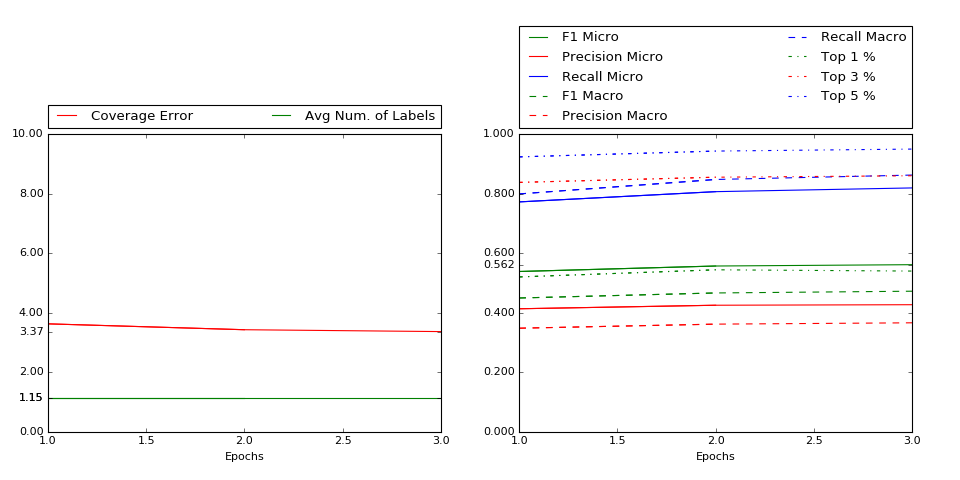

2017-01-20 20:18:46,752 : INFO : ****************** Epoch 1 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1 *******************
2017-01-20 20:18:46,761 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model
2017-01-20 20:19:07,886 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.docvecs.* with mmap=None
2017-01-20 20:19:07,897 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-20 20:19:11,000 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_sea

[[0 0 0 ..., 0 1 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 1 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.634, Avg Labels: 1.150, 
		 Top 1: 0.521, Top 3: 0.839, Top 5: 0.924, 
		 F1 Micro: 0.539, F1 Macro: 0.450, Total Pos: 689,413


/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1, right=1
  'left=%s, right=%s') % (left, right))
2017-01-20 20:44:53,611 : INFO : ****************** Epoch 2 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2 *******************
2017-01-20 20:44:53,613 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model
2017-01-20 20:45:18,499 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model.docvecs.* with mmap=None
2017-01-20 20:45:18,502 : INFO : loading doctag_syn0 from /mnt/d

[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.437, Avg Labels: 1.150, 
		 Top 1: 0.545, Top 3: 0.856, Top 5: 0.944, 
		 F1 Micro: 0.558, F1 Macro: 0.467, Total Pos: 700,050


2017-01-20 21:10:57,231 : INFO : ****************** Epoch 3 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3 *******************
2017-01-20 21:10:57,232 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model
2017-01-20 21:11:16,975 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model.docvecs.* with mmap=None
2017-01-20 21:11:16,986 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-20 21:11:19,050 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_sea

[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 0 ..., 1 0 0]
 [1 0 0 ..., 0 1 0]
 [1 1 1 ..., 0 0 0]]


2017-01-20 21:34:40,248 : INFO : ****************** Epoch 4 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4 *******************
2017-01-20 21:34:40,249 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4/model


** Validation Metrics: Cov Err: 3.374, Avg Labels: 1.150, 
		 Top 1: 0.541, Top 3: 0.861, Top 5: 0.951, 
		 F1 Micro: 0.562, F1 Macro: 0.473, Total Pos: 707,978


In [ ]:
%%time
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph(len(classifications) +2)
# when resuming, resume from an epoch with a previously created doc2vec model to get the learning rate right
start_from = 1
for epoch in range(start_from, DOC2VEC_MAX_EPOCHS+1):
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))
    
    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
    else:
        break
        
    info('Getting training Data')
    X, y = get_training_data(doc2vec_model, classifications)
    
    
    ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                             GLOBAL_VARS.SVM_MODEL_NAME))
    
    # try warm start and evaluate after every iter
    
    if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, CLASSIFIER)):
        info('Training Classifier')
        clf = OneVsRestClassifier(linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                                             #alpha is the 1/C parameter
                                                             alpha=SVM_REG, fit_intercept=True, n_iter=SVM_ITERATIONS,
                                                             #n_jobs=-1 means use all cpus
                                                             shuffle=True, verbose=0, n_jobs=1,
                                                             #eta0 is the learning rate when we use constant configuration
                                                             random_state=SVM_SEED, learning_rate='optimal', eta0=0.0, 
                                                             class_weight=SVM_CLASS_WEIGHTS, warm_start=False), n_jobs=1)


        # Training of a classifier
        clf.fit(X,y)
        pickle.dump(clf, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                              GLOBAL_VARS.SVM_MODEL_NAME, CLASSIFIER), 'w'))
    else:
        info('Loading Classifier')
        clf = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, CLASSIFIER), 'r'))
    
#     # Training Metrics
#     info('Evaluating on Training Data')
#     yp = clf.predict(X)
#     yp_score = clf.decision_function(X)
#     print yp
#     training_metrics = get_metrics(y, yp, yp)
#     print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
#         training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
#         training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
#         training_metrics['f1_micro'], training_metrics['f1_macro'], training_metrics['total_positive'])
    
#     epoch_training_metrics.append(training_metrics)
    
    del X,y
    
    # Validation Metrics
    info('Getting Validation Embeddings')
    Xv, yv = get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                                    validation_docs_list, validation_preprocessed_files_prefix,
                                                    validation_preprocessed_docids_files_prefix)
    info('Evaluating on Validation Data')
    yvp = clf.predict(Xv)
    yvp_score = clf.decision_function(Xv)
    print yvp
    validation_metrics = get_metrics(yv, yvp, yvp)
    print "** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
        validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
        validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive'])
    
    graph.add_metrics_to_graph(validation_metrics, epoch)
    
    epoch_validation_metrics.append(validation_metrics)
    
    
    # Saving the metrics
#     pickle.dump(training_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                                           GLOBAL_VARS.SVM_MODEL_NAME, TRAINING_METRICS_FILENAME), 'w'))
    pickle.dump(validation_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, VALIDATION_METRICS_FILENAME), 'w'))


In [75]:
from multiprocessing.dummy import Pool as ThreadPool 

In [43]:
import thesis.utils.metrics

In [84]:
validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
i=0
doc_contents = []
for (doc_id, doc_contents_array) in validation_docs_iterator:
    i += 1
    doc_contents.append((doc_id, doc_contents_array))
    if i > 100:
        break

2016-12-28 22:22:21,536 : INFO : Loading new batch
2016-12-28 22:22:27,109 : INFO : Finished loading new batch


In [133]:
def infer_one_doc(doc):
    #doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
    rep = doc2vec_model.infer_vector(doc[1])
    return (doc[0], rep)

Threaded Version

In [114]:
%%time
pool = ThreadPool(16)
doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
threaded_reps = pool.map(infer_one_doc, doc_contents)


CPU times: user 1min 41s, sys: 620 ms, total: 1min 41s
Wall time: 9.83 s


Non-Threaded Version

In [112]:
%%time
reps = []
doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
for doc in doc_contents:
    reps.append((doc[0], doc2vec_model.infer_vector(doc[1])))

CPU times: user 14 s, sys: 44 ms, total: 14.1 s
Wall time: 13.9 s


In [100]:
np.array_equal([d[0] for d in reps], [d[0] for d in threaded_reps])

True

More advanced threading

In [140]:
def nothing_func(doc):
    1 + 1

In [139]:
len(validation_docs_list)

12412

In [138]:
len(threaded_reps)

13000

#### Prepare Training Data

In [31]:
%%time
classifications = sections

NN_OUTPUT_NEURONS = len(classifications)
one_hot_encoder = OneHotEncoder(classifications)
training_data = []
training_labels = []
for doc_id in training_docs_list:
    # converting from memmap to a normal array
    normal_array = []
    normal_array[:] = doc2vec_model.docvecs[doc_id][:]
    training_data.append(normal_array)
    eligible_classifications = [clssf for clssf in doc_classification_map[doc_id] if clssf in classifications]
    training_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))

CPU times: user 1.61 s, sys: 520 ms, total: 2.13 s
Wall time: 1.93 s


#### Create Keras NN

In [173]:
import itertools
from keras.layers import Dropout

In [186]:
pickle.dump(history_list, open('/mnt/data2/shalaby/history_list_sample_0.0001.pickle','w'))

In [181]:
print len(history_list)

100


In [147]:
doc_input = Input(shape=(DOC2VEC_SIZE,), name='doc_input')
hidden = Dense(NN_HIDDEN_NEURONS, activation='relu', name='hidden_layer')(doc_input)
softmax_output = Dense(NN_OUTPUT_NEURONS, activation='sigmoid', name='softmax_output')(hidden)
model = Model(input=doc_input, output=softmax_output)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', 'fbeta_score', theano_coverage_error])

In [148]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 3000)          0                                            
____________________________________________________________________________________________________
hidden_layer (Dense)             (None, 4500)          13504500    doc_input[0][0]                  
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 8)             36008       hidden_layer[0][0]               
Total params: 13540508
____________________________________________________________________________________________________


In [162]:
model.fit(x=training_data, y=training_labels, 
          validation_data=(validation_data, validation_labels), 
          nb_epoch=1, verbose=1)

Train on 8979 samples, validate on 1969 samples
Epoch 1/1
8979/8979 [==============================] - 4s - loss: 0.0427 - acc: 0.9835 - fbeta_score: 0.9504 - coverage error: 1.4936 - val_loss: 2.1309 - val_acc: 0.8531 - val_fbeta_score: 0.4738 - val_coverage error: 3.4474


In [143]:
val_prediction = model.predict(validation_data)

In [144]:
val_prediction[:2]

array([[  2.70263344e-01,   3.49998474e-02,   3.13610617e-05,
          1.08150870e-03,   3.11665332e-07,   7.09001958e-01,
          4.97711152e-02,   2.63609409e-01],
       [  1.70166213e-02,   5.36046147e-01,   2.61311390e-04,
          4.87348643e-06,   1.27638310e-01,   9.57404263e-03,
          3.39831635e-02,   2.13784515e-03]], dtype=float32)